In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

%matplotlib notebook

In [2]:
B_INC = 0.0000000001

In [3]:
FONT_SIZE = 18

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title

### Базовая функция эволюции

In [25]:
def evolve3D(grid, b, num_steps=1):
    '''simple evolution function'''
    L = grid.shape[0]
    current = np.zeros((L, L, L), dtype=int)
    scores = np.zeros((L, L, L), dtype=float)
    for step in range(num_steps):
        current = grid.copy()
        scores = np.zeros((L, L, L), dtype=float)
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i) % L
                                jy = (y + j) % L
                                kz = (z + k) % L
                                scores[x, y, z] += (1 - grid[ix, jy, kz])
                    if grid[x, y, z] == 1:
                        scores[x, y, z] *= b
        
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    bestX = x
                    bestY = y
                    bestZ = z
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i) % L
                                jy = (y + j) % L
                                kz = (z + k) % L
                                if (scores[bestX, bestY, bestZ] < scores[ix, jy, kz]):
                                    bestX = ix
                                    bestY = jy
                                    bestZ = kz
                    grid[x, y, z] = current[bestX, bestY, bestZ]
    return grid

Функция визуализаации поля в разных форматах

In [4]:
def show_grid(grid, d3 = False, slises=False):
    ''' 
    Show grid in different formats 
    by default shows projection of sums by axes 
    '''
    L = grid.shape
    
    ''' Show 3D plot '''
    if d3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # ax.grid(False)
        # ax.set_axis_off()
        colors = {0:'b', 1:'r'}
        for i in range(L[0]):
            for j in range(L[1]):
                for k in range(L[2]):
                    ax.scatter(i, j, k, c=colors[grid[i,j,k]], s=5) # s=np.sqrt(((i+1)**2 + (k + 1)**2 + (L-j)**2)/3) show depth through size

        plt.show()

    ''' supporting lines '''            
    # for i in range(L):
    #     for j in range(L):
    #         ax.plot([i,i], [j,j], [0, L - 1], c='0.5', linewidth=0.5)
    #         ax.plot([0, L - 1], [j,j], [i,i], c='0.5', linewidth=0.5)
    #         ax.plot([j,j], [0, L - 1], [i,i], c='0.5', linewidth=0.5)
    
    ''' Show slices '''
    if slises:
        rows = L
        columns = 3
        fig = plt.figure()
        for i in range(L):
            fig.add_subplot(rows, columns, i*3 + 1)
            plt.imshow(grid[i,:,:], cmap=plt.get_cmap('Paired'))
            fig.add_subplot(rows, columns, i*3 + 2)
            plt.imshow(grid[:,i,:], cmap=plt.get_cmap('Paired'))
            fig.add_subplot(rows, columns, i*3 + 3)
            plt.imshow(grid[:,:,i], cmap=plt.get_cmap('Paired'))
        plt.show()

    ''' Shows projection of sums by axes '''
    rows = 1
    columns = 3
    fig = plt.figure()
    Px = np.zeros((L[1], L[2]), dtype=int)
    Py = np.zeros((L[0], L[2]), dtype=int)
    Pz = np.zeros((L[0], L[1]), dtype=int)
    for i in range(L[0]):
        Px += grid[i, :, :]
    for i in range(L[1]):
        Py += grid[:, i, :]
    for i in range(L[2]):
        Pz += grid[:, :, i]
    Px = Px / L[0]
    Py = Py / L[1]
    Pz = Pz / L[2]
    fig.add_subplot(rows, columns, 1)
    plt.imshow(Px)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(Py)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(Pz)
    plt.show()
#     TODO: fix slices

In [7]:
L = 60
b = 1.3
C_prob = 0.1

grid = np.random.choice(2, (L, L, L), p=[C_prob, 1 - C_prob])

# grid = np.zeros((L, L, L), dtype=int)
# grid[L//2, L//2, L//2] = 1

grid = grid.astype('int16')

In [7]:
%timeit evolve3D(grid, b, num_steps=1)

40.8 s ± 1.67 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Очевидно, что 40 секунд для одного шага - лишком много

In [5]:
%load_ext cython

In [6]:
%%cython -a
import numpy as np
import cython
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def evolve3D_c(short[:, :, :] grid, double b, int num_steps=1):
    
    cdef int x, y, z, L, i, j, k, ix, jy, kz, step, bestX, bestY, bestZ
    
    L = grid.shape[0]
    cdef double[:, :, :] scores = np.zeros((L, L, L), dtype=float)
    
    cdef double[:, :, :] _zeros = np.zeros((L, L, L), dtype=float)
    cdef short[:, :, :] current = grid.copy()
    
    for step in range(num_steps):
        current = grid.copy()
        scores[...] = _zeros
        
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i + L) % L
                                jy = (y + j + L) % L
                                kz = (z + k + L) % L
                                scores[x, y, z] += (1 - grid[ix, jy, kz])
                                
                    if grid[x, y, z] == 1:
                        scores[x, y, z] *= b
                    
                        
        for x in range(L):
            for y in range(L):
                for z in range(L):
                    bestX = x
                    bestY = y
                    bestZ = z
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            for k in range(-1, 2):
                                ix = (x + i + L) % L
                                jy = (y + j + L) % L
                                kz = (z + k + L) % L
                                if (scores[bestX, bestY, bestZ] < scores[ix, jy, kz]):
                                    bestX = ix
                                    bestY = jy
                                    bestZ = kz
                                    
                    grid[x, y, z] = current[bestX, bestY, bestZ]
                    
    return grid

In [8]:
L = 60
b = 1.3
C_prob = 0.1

grid = np.random.choice(2, (L, L, L), p=[C_prob, 1 - C_prob])

# grid = np.zeros((L, L, L), dtype=int)
# grid[L//2, L//2, L//2] = 1

grid = grid.astype('int16')
grid =  np.array(evolve3D_c(grid, b, num_steps=100))

<IPython.core.display.Javascript object>


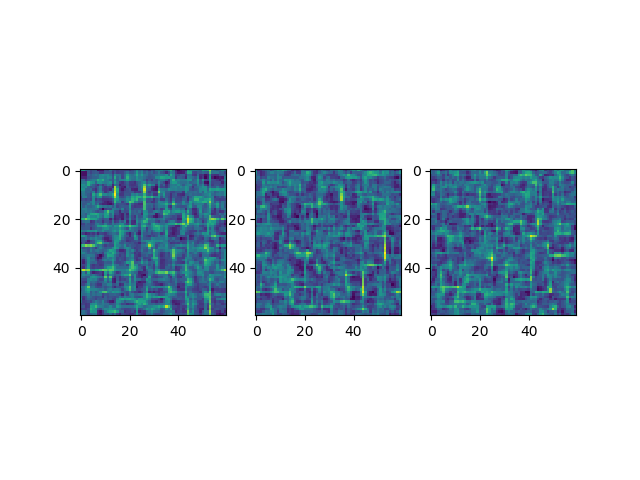

In [14]:
grid =  np.array(evolve3D_c(grid, b, num_steps=1))
show_grid(grid)

In [13]:
%timeit evolve3D_c(grid, b, num_steps=1)

127 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
40 * 1000/127

314.96062992125985

Преимущество во времени работы функции с Cython порядка нескольких сотен

In [15]:
B = set()
for i in range(28):
    for j in range(1, 28):
        B.add(i/j + B_INC)
B = list(B)
len(B)

460

# Tabulate the neighbors

Возникло предположение что заранее заговоленный список соседий может ускорить программу

In [5]:
NUM_NEIGHB = 27

def get_site(coord, L):
    """Get the site index from the 3-vector of coordinates."""
    # XXX: 3D hardcoded, can do N-D
    return coord[0] * L[1] * L[2] + coord[1] * L[2] + coord[2]


def get_coord(site, L):
    """Get the 3-vector of coordinates from the site index."""
    # XXX: 3D hardcoded, can do N-D
    x = site // (L[1]*L[2])
    yz = site % (L[1]*L[2])
    y = yz // L[2]
    z = yz % L[2]
    return [x, y, z]


def get_neighbors(site, L):
    neighb = set()
    x, y, z = get_coord(site, L)
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            for k in [-1, 0, 1]:
                x1 = (x + i) % L[0]
                y1 = (y + j) % L[1]
                z1 = (z + k) % L[2]
                neighb.add(get_site([x1, y1, z1], L))
    
    return list(neighb)
    
def tabulate_neighbors(L):
    """Tabulate the root-2 neighbors on the 3D cubic lattice with PBC."""
    Nsite = L[0]*L[1]*L[2]
    neighb = np.empty((Nsite, NUM_NEIGHB), dtype=int)
    for site in range(Nsite):
        neighb[site, :] = get_neighbors(site, L)
    return neighb



def tabulate_neighbors_small_L(L):
    """
    Tabulate the root-2 neighbors on the 3D cubic lattice with PBC.
    Must be used when L[0], L[1] or L[2] < 3 
    """
    Nsite = L[0]*L[1]*L[2]
    neighb = [[]] * Nsite
    for site in range(Nsite):
        neighb[site] = get_neighbors(site, L)
    return neighb

In [28]:
# Test conversion sites <--> coords

from numpy.testing import assert_equal

L = (5, 5, 5)
for site in range(L[0] * L[1] * L[2]):
    xyz = get_coord(site, L)
    site1 = get_site(xyz, L)
    #print(site, xyz, site1)
    assert_equal(site, site1)

# TODO: test neighbors (distance w/PBC?)

In [17]:
for nghb in get_neighbors(get_site((2, 2, 2), L), L):
    print(nghb, get_coord(nghb, L), end=" -- ")

31 [1, 1, 1] -- 32 [1, 1, 2] -- 33 [1, 1, 3] -- 36 [1, 2, 1] -- 37 [1, 2, 2] -- 38 [1, 2, 3] -- 41 [1, 3, 1] -- 42 [1, 3, 2] -- 43 [1, 3, 3] -- 56 [2, 1, 1] -- 57 [2, 1, 2] -- 58 [2, 1, 3] -- 61 [2, 2, 1] -- 62 [2, 2, 2] -- 63 [2, 2, 3] -- 66 [2, 3, 1] -- 67 [2, 3, 2] -- 68 [2, 3, 3] -- 81 [3, 1, 1] -- 82 [3, 1, 2] -- 83 [3, 1, 3] -- 86 [3, 2, 1] -- 87 [3, 2, 2] -- 88 [3, 2, 3] -- 91 [3, 3, 1] -- 92 [3, 3, 2] -- 93 [3, 3, 3] -- 

In [8]:
def evolve3D_2(grid, neighbors, b, num_steps=1):
    
    L = grid.shape
    
    grid = grid.flatten()
    SIZE = len(grid)
    current = np.zeros((SIZE), dtype=int)
    scores = np.zeros((SIZE), dtype=float)
    for step in range(num_steps):
        current = grid.copy()
        scores = np.zeros((SIZE), dtype=float)
        for site in range(SIZE):
            # TODO: 
            #       5. cythonize
            for site1 in neighbors[site]:
                scores[site] += (1 - grid[site1])
                
            if grid[site] == 1:
                scores[site] *= b
                
        for site in range(SIZE):
            best_site = site
            for site1 in neighbors[site]:
                if (scores[best_site] < scores[site1]):
                    best_site = site1
                    
            grid[site] = current[best_site]
    return np.reshape(grid, L)

In [19]:
# check that the dynamics is identical
L = (20, 20, 20)

neighbors = tabulate_neighbors_small_L(L)

rndm = np.random.RandomState(12345)

B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i / j < 1.5:
            B.add((i/j) + B_INC)
B = sorted(list(B))

N = 5

for i in range(0, len(B), len(B)//10):
    b = B[i]
    field = (rndm.uniform(size=L) > 0.5).astype(int)
    field2 = field.copy()
    field = evolve3D(field.copy(), b, num_steps=N)
    field2 = evolve3D_2(field2.copy(), neighbors, b, num_steps=N)
    assert_equal(field, field2)
    print('Game stabilized:', field.all())

Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: True
Game stabilized: True
Game stabilized: True


# Test times

In [20]:
L = (60, 60, 60)

neighbors = tabulate_neighbors(L)

rndm = np.random.RandomState(12345)

N = 1

field = (rndm.uniform(size=L) > 0.5).astype(int)

In [29]:
%timeit evolve3D(field, 1.3, num_steps=N)

36.7 s ± 1.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit evolve3D_2(field, neighbors, 1.3, num_steps=N)

11.4 s ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Check that the dynamics is identical to 2D

In [11]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [12]:
%%cython -a

import numpy as np

import cython

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve2_1(long[:, ::1] field, double b, int num_steps=1):
    
    cdef int x, y, L, i, j, ix, jy, step
    
    L = field.shape[0]
    cdef double[:, ::1] scores = np.zeros((L, L), dtype=float)
    
    cdef double[:, ::1] _zeros = np.zeros((L, L), dtype=float)
    cdef long[:, ::1] current = field.copy()
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
        
        for x in range(L):
            for y in range(L):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        scores[x, y] += (1 - field[ix, jy])
                        
                if field[x, y] == 1:
                    scores[x, y] *= b
        
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        if (scores[bestX, bestY] < scores[ix, jy]):
                            bestX = ix
                            bestY = jy
                
                field[x, y] = current[bestX, bestY]
    return field

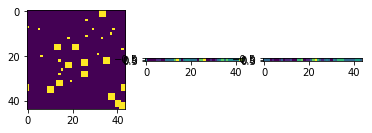

Game stabilized: False


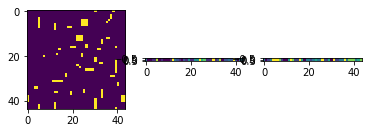

Game stabilized: False


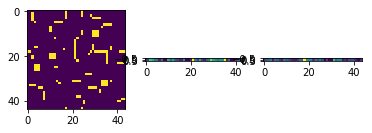

Game stabilized: False


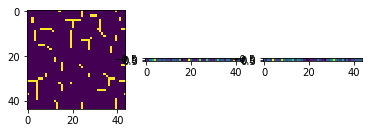

Game stabilized: False


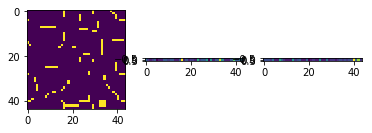

Game stabilized: False


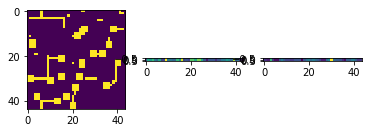

Game stabilized: False


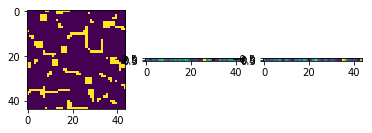

Game stabilized: False


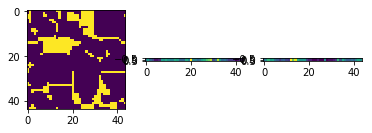

Game stabilized: False


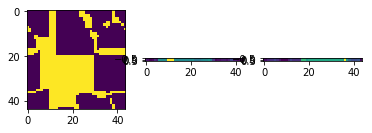

Game stabilized: False


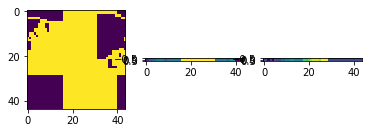

Game stabilized: False


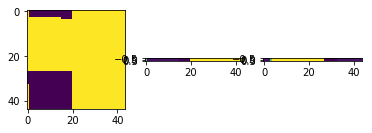

Game stabilized: False


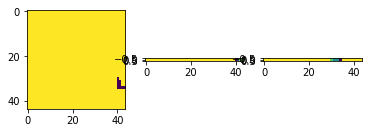

Game stabilized: False


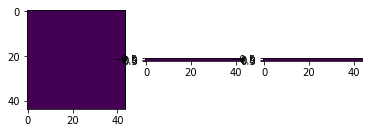

Game stabilized: True


In [15]:

L = (1, 44, 44)

neighbors = tabulate_neighbors_small_L(L)

rndm = np.random.RandomState(12345)

B = set()
for i in range(1, 10):
    for j in range(1, 10):
        if i/j > 1 and i / j < 2:
            B.add((i/j) + B_INC)
B = sorted(list(B))

N = 10

for b in B:
    field = (rndm.uniform(size=L) > 0.5).astype(int)
    field2 = field[0, :, :].copy()
    field = evolve3D_2(field, neighbors, b, num_steps=N)
    field2 = np.array(evolve2_1(field2, b, num_steps=N))
    assert_equal(field[0, :, :], field2)
    show_grid(field)
    print('Game stabilized:', field.all())

# Cythonised function

In [6]:
%load_ext cython

In [7]:
%%cython -a

import numpy as np

import cython

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def evolve3D_2_C(grid_orig, long[:, :] neighbors, double b, int num_steps=1):
    
    cdef int N_NEIGHB = 27 
    L = grid_orig.shape
    cdef short[:] grid = grid_orig.flatten()
    
    cdef int SIZE, step, site, site1, best_site, i
    SIZE = L[0] * L[1] * L[2]
    cdef short[:] current = grid.copy()
    cdef double[:] _zeros = np.zeros((SIZE), dtype=float)
    cdef double[:] scores = np.zeros((SIZE), dtype=float)
    
    for step in range(num_steps):
        current = grid.copy()
        scores[...] = _zeros
        for site in range(SIZE):
            for i in range(N_NEIGHB):
                site1 = neighbors[site,i]
                scores[site] += (1 - grid[site1])
                
            if grid[site] == 1:
                scores[site] *= b
        
        for site in range(SIZE):
            best_site = site
            for i in range(N_NEIGHB):
                site1 = neighbors[site,i]
                if (scores[best_site] < scores[site1]):
                    best_site = site1
                    
            grid[site] = current[best_site]
    grid_orig = np.array(grid)
    return np.reshape(grid_orig, L)

In [24]:
# check that the dynamics is identical
L = (10, 10, 10)

neighbors = tabulate_neighbors(L)

rndm = np.random.RandomState(12345)

B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i / j < 1.5:
            B.add((i/j) + B_INC)
B = sorted(list(B))

N = 5

for i in range(0, len(B), len(B)//10):
    b = B[i]
    print('b = ', b)
    field = (rndm.uniform(size=L) > 0.5).astype('int16')
    field2 = field.copy()
    field = evolve3D_2_C(field.copy(), neighbors, b, num_steps=N)
    field2 = evolve3D_2(field2.copy(), neighbors, b, num_steps=N)
    assert_equal(field, field2)
    print('Game stabilized:', field.all())

b =  1.0384615385615386
Game stabilized: False
b =  1.0526315790473684
Game stabilized: False
b =  1.0800000001
Game stabilized: False
b =  1.1111111112111112
Game stabilized: False
b =  1.1500000001
Game stabilized: False
b =  1.1875000001
Game stabilized: False
b =  1.2307692308692308
Game stabilized: True
b =  1.2777777778777777
Game stabilized: True
b =  1.3333333334333333
Game stabilized: True
b =  1.3846153847153846
Game stabilized: True
b =  1.4375000001
Game stabilized: True


# Time comparison

In [8]:
import timeit

In [26]:
rndm = np.random.RandomState(12345)
N = 1
N_repeats = 3
times = list()
times_C = list()
for size in range(10, 80, 10):
    L = (size, size, size)
    print(L)
    neighbors = tabulate_neighbors(L)
    field = (rndm.uniform(size=L) > 0.5).astype('int16')
    times_C.append(timeit.timeit('evolve3D_2_C(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    times.append(timeit.timeit('evolve3D_2(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    print(times_C[-1])
    print(times[-1])

(10, 10, 10)
0.00029086666654620785
0.18951250000009168
(20, 20, 20)
0.0020295333333706367
1.418038466666682
(30, 30, 30)
0.006763766666457134
4.765700366666654
(40, 40, 40)
0.01802013333326613
11.439154333333136
(50, 50, 50)
0.03230970000004163
22.53323443333314
(60, 60, 60)
0.05562596666671501
37.96290136666661
(70, 70, 70)
0.08851346666657871
59.94401139999991


<IPython.core.display.Javascript object>


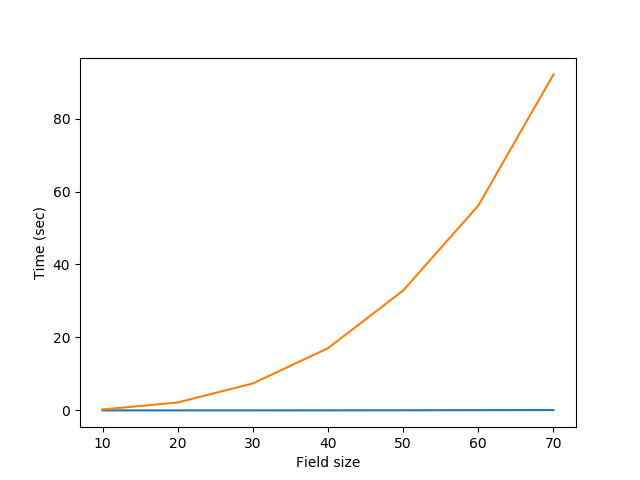

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Field size')
ax.set_ylabel('Time (sec)')
ax.plot([10, 20, 30, 40, 50, 60, 70], times_C)
ax.plot([10, 20, 30, 40, 50, 60, 70], times)


plt.show()

In [68]:
time_div = list()
for i in range(len(times)):
    time_div.append(times[i] / times_C[i])

<IPython.core.display.Javascript object>


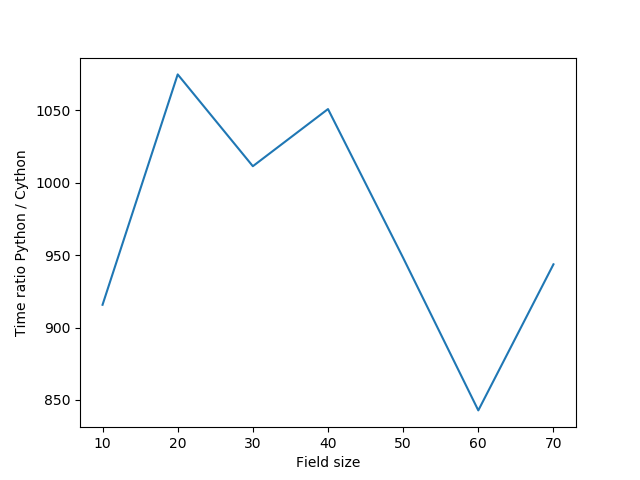

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Field size')
ax.set_ylabel('Time ratio Python / Cython')
ax.plot([10, 20, 30, 40, 50, 60, 70], time_div)


plt.show()

# Numba jit

In [11]:
import numba

In [12]:
def evolve3D_3(grid, neighbors, b, num_steps=1):
    L = field.shape
    grid = grid.flatten().astype(int)
    SIZE = len(grid)
    _zeros = np.zeros((SIZE), dtype=float)
    _int_zeros = np.zeros((SIZE), dtype=int)
    evolve3D_impl(grid, neighbors, b, num_steps, _zeros, _int_zeros)
    
    return np.reshape(grid, L)

@numba.jit(nopython=True)
def evolve3D_impl(grid, neighbors, b, num_steps, _zeros, _int_zeros):
    
    L = grid.shape
    
    SIZE = len(grid)
    current = _int_zeros.copy()
    scores = _zeros.copy()
    for step in range(num_steps):
        current = grid.copy()
        scores = _zeros.copy()
        for site in range(SIZE):
            for site1 in neighbors[site]:
                scores[site] += (1 - grid[site1])
                
            if grid[site] == 1:
                scores[site] *= b
                
        for site in range(SIZE):
            best_site = site
            for site1 in neighbors[site]:
                if (scores[best_site] < scores[site1]):
                    best_site = site1
                    
            grid[site] = current[best_site]
    return grid

In [14]:
import timeit
rndm = np.random.RandomState(12345)
N = 1
Size = 60
L = (Size, Size, Size)
print(L)
neighbors = tabulate_neighbors(L)
field = (rndm.uniform(size=L) > 0.5).astype(int)
field = evolve3D_3(field, neighbors, 1.3, num_steps=N)

(60, 60, 60)


In [15]:
field = evolve3D_3(field, neighbors, 1.3, num_steps=100)

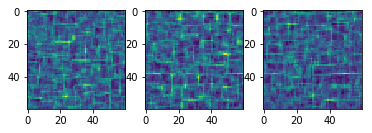

In [16]:
show_grid(field)

In [47]:
%timeit evolve3D_3(field, neighbors, 1.3, num_steps=1)

70.6 ms ± 5.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Time comparison

In [52]:
rndm = np.random.RandomState(12345)
N = 1
N_repeats = 10
times = list()
times_C = list()
for size in range(10, 80, 10):
    L = (size, size, size)
    print(L)
    neighbors = tabulate_neighbors(L)
    field = (rndm.uniform(size=L) > 0.5).astype('int16')
    times_C.append(timeit.timeit('evolve3D_2_C(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    times.append(timeit.timeit('evolve3D_3(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    print(times_C[-1])
    print(times[-1])

(10, 10, 10)
0.0004658899999867572
0.000349850000020524
(20, 20, 20)
0.002833390000023428
0.0016478800000186312
(30, 30, 30)
0.01025168000001031
0.006889130000035948
(40, 40, 40)
0.03010255999997753
0.024888719999989917
(50, 50, 50)
0.045702889999984106
0.04808189999998831
(60, 60, 60)
0.07996495000002142
0.07435855000003358
(70, 70, 70)
0.12066221000000041
0.10780005999999957


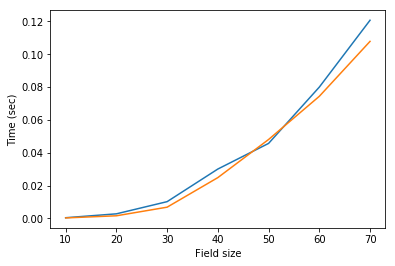

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Field size')
ax.set_ylabel('Time (sec)')
ax.plot([10, 20, 30, 40, 50, 60, 70], times_C)
ax.plot([10, 20, 30, 40, 50, 60, 70], times)


plt.show()

In [54]:
time_div = list()
for i in range(len(times)):
    time_div.append(times[i] / times_C[i])

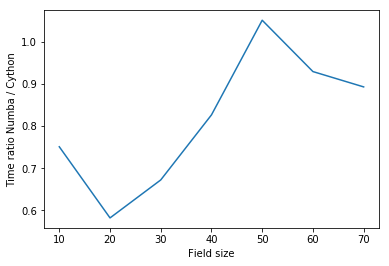

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Field size')
ax.set_ylabel('Time ratio Numba / Cython')
ax.plot([10, 20, 30, 40, 50, 60, 70], time_div)


plt.show()

# Main run code

In [8]:
B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 2:
            B.add(i/j + B_INC)
B = sorted(list(B))
len(B)

114

In [11]:
SIZE = 60
L = (SIZE, SIZE, SIZE)
neighbors = tabulate_neighbors(L)

In [ ]:
# код используемый для замеров на кластере
rndm = np.random.RandomState(17)
C_PROB = 0.9 # test 0.1, 0.5, 0.9
N_STEPS = 100 
N_MEASUR = 100 
N_FIELDS = 1 
BURN_IN_STEPS = 2000
DIR_NAME = "RUN_10_all_B"

for i in range(len(B)):
    b = B[i]
    for k in range(N_FIELDS):
        results = np.zeros((N_MEASUR), dtype=float)
        field = (rndm.uniform(size=L) > C_PROB).astype('int16')
        field = evolve3D_2_C(field, neighbors, b, num_steps=BURN_IN_STEPS)
        for measure in range(N_MEASUR):
            field = evolve3D_2_C(field, neighbors, b, num_steps=N_STEPS)
            results[measure] =  1 - (field.sum() / (L[0] * L[1] * L[2]))
        fname = DIR_NAME + "/" + str(i) + "_" + str(k)
        np.save(fname, results) 




# Исследование результатов замеров

## Замеры на больших временах с начальной плотностью кооператоров 0.5

In [5]:
f1= np.load("results/C_0.5/D_densities12.npy")
f2= np.load("results/C_0.5/D_densities34.npy")
f3= np.load("results/C_0.5/D_densities56.npy")
f4= np.load("results/C_0.5/D_densities78.npy")
f5= np.load("results/C_0.5/D_densities910.npy")
# в каждом файле записаны средние плотность по двум полям для каждого значения b
#TODO: повторить замеры , сохранив результаты для каждого отдельного поля

In [6]:
result = (f1 + f2 + f3 + f4 + f5) / 5
for i in range(len(result)):
    result[i] = 1 - result[i]

<IPython.core.display.Javascript object>


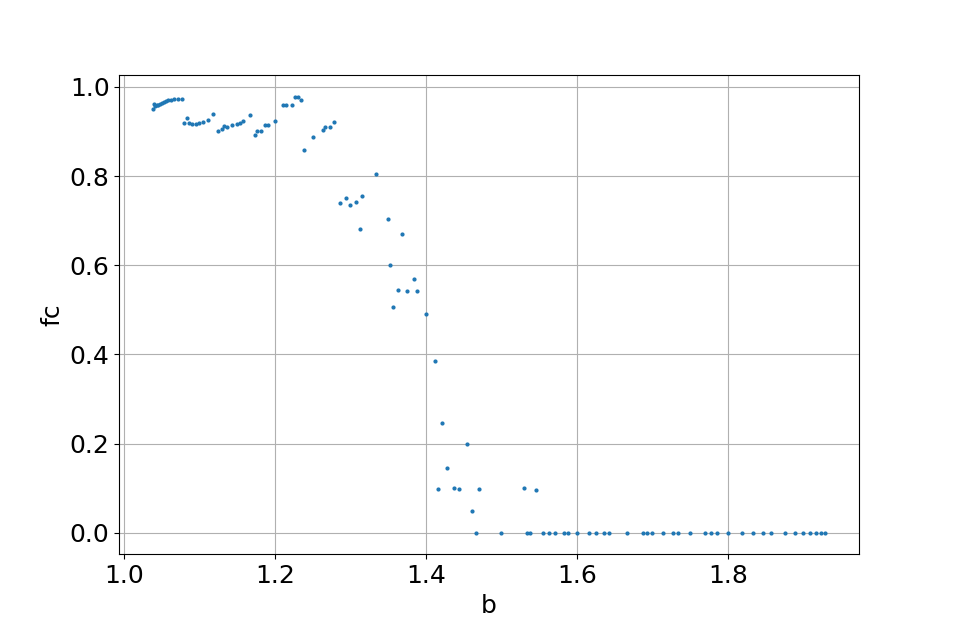

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, result, 'o', markersize = 2)

plt.grid(True)
plt.show()

In [5]:
B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 1.6:
            B.add(i/j + B_INC)
B = sorted(list(B))
len(B)

86

In [14]:
r1 = result[:86]

<IPython.core.display.Javascript object>


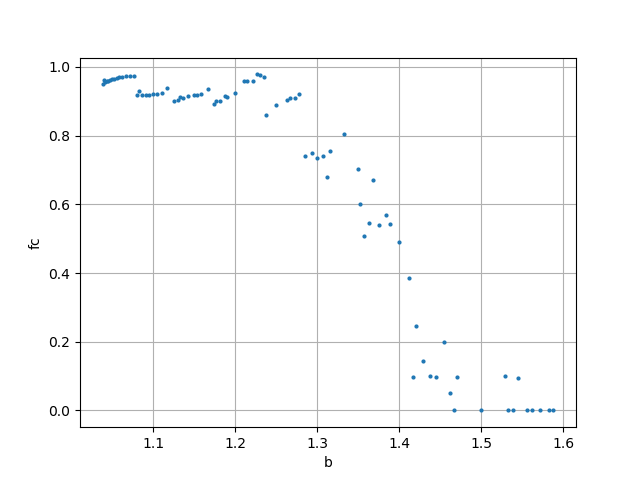

In [45]:

plt.plot(B, r1, 'o', markersize = 2)
plt.xlabel('b')
plt.ylabel('fc')
plt.grid(True)
plt.show()

In [46]:
for i in range(len(r1) - 1):
    print(i, ":", r1[i+1] - r1[i])

0 : 0.010324814814814842
1 : -0.004791481481481563
2 : 0.0026025925925926563
3 : 0.0008374537037036944
4 : 0.0017319444444444665
5 : 0.002975601851851861
6 : 0.001345138888888875
7 : 0.002507175925925864
8 : 0.0011418055555555418
9 : 0.0015027314814815007
10 : 0.001281944444444516
11 : 0.00018564814814814312
12 : 0.0005541666666666334
13 : -0.05364379629629634
14 : 0.011152083333333396
15 : -0.01118467592592598
16 : -0.0020659259259259155
17 : 0.0001487037037036787
18 : 0.002176018518518563
19 : 0.0006319444444444766
20 : 0.004516990740740745
21 : 0.014144537037036997
22 : -0.03704833333333335
23 : 0.0029993518518518503
24 : 0.007869583333333319
25 : -0.0031710648148147724
26 : 0.0043809259259258715
27 : 0.0029943981481481696
28 : 0.0012441203703703607
29 : 0.00405759259259264
30 : 0.013564027777777765
31 : -0.044914953703703686
32 : 0.00896643518518514
33 : 0.0016901388888889146
34 : 0.01257435185185185
35 : -0.0007919444444444146
36 : 0.009795138888888832
37 : 0.03614657407407407
38 

In [47]:
r1[13]

0.9733449074074074

In [49]:
r1[14]

0.9197011111111111

In [32]:
B.index(27/22 + B_INC)
27/22

1.2272727272727273

In [31]:
for i in range(28):
    for j in range(1, 28):
        b = (i/j + B_INC)
        if b == B[13]:
            print(i, '/', j)

14 / 13


In [52]:
r1[22]

0.939220787037037

In [53]:
r1[23]

0.9021724537037037

In [61]:
for i in range(28):
    for j in range(1, 28):
        b = (i/j + B_INC)
        if b == B[22]:
            print(i, '/', j)

19 / 17


In [62]:
r1[31]

0.9361113888888889

In [64]:
r1[32]

0.8911964351851852

In [12]:
B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 2:
            B.add(i/j + B_INC)
B = sorted(list(B))
len(B)

114

In [13]:
f1= np.load("results/С_0.1/D_densities12.npy")
f2= np.load("results/С_0.1/D_densities34.npy")
f3= np.load("results/С_0.1/D_densities56.npy")
f4= np.load("results/С_0.1/D_densities78.npy")
f5= np.load("results/С_0.1/D_densities910.npy")


In [14]:
result = (f1 + f2 + f3 + f4 + f5) / 5
for i in range(len(result)):
    result[i] = 1 - result[i]

In [15]:
r2 = result

<IPython.core.display.Javascript object>


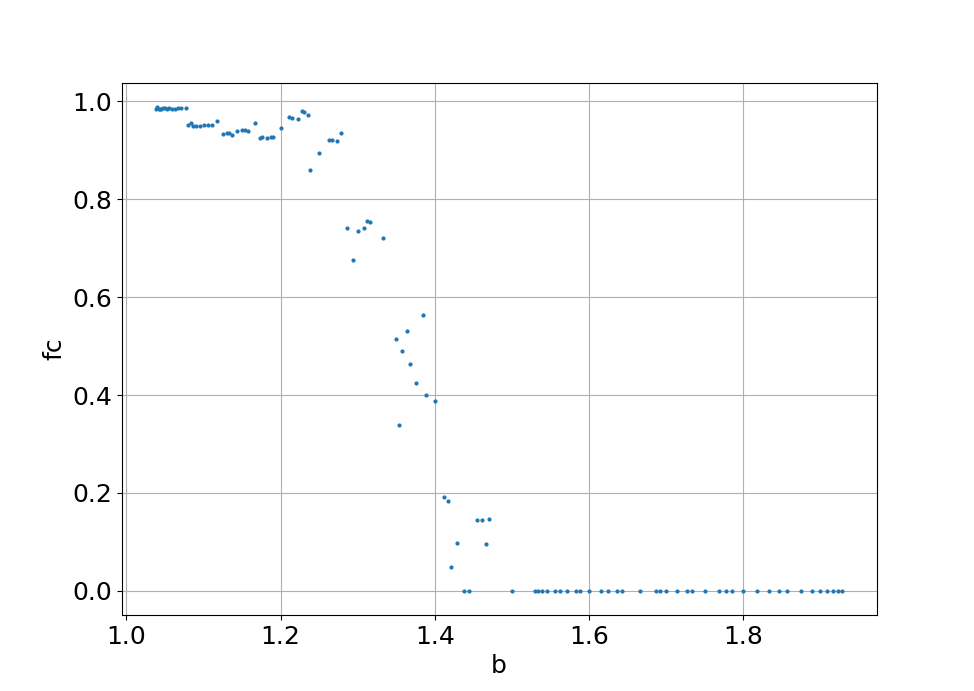

In [16]:
# plt.plot(B, r1, 'o', markersize = 2)
plt.plot(B, r2, 'o', markersize = 2)
plt.xlabel('b')
plt.ylabel('fc')
plt.grid(True)
plt.show()

In [25]:
r = (r1 + r2) / 2

<IPython.core.display.Javascript object>


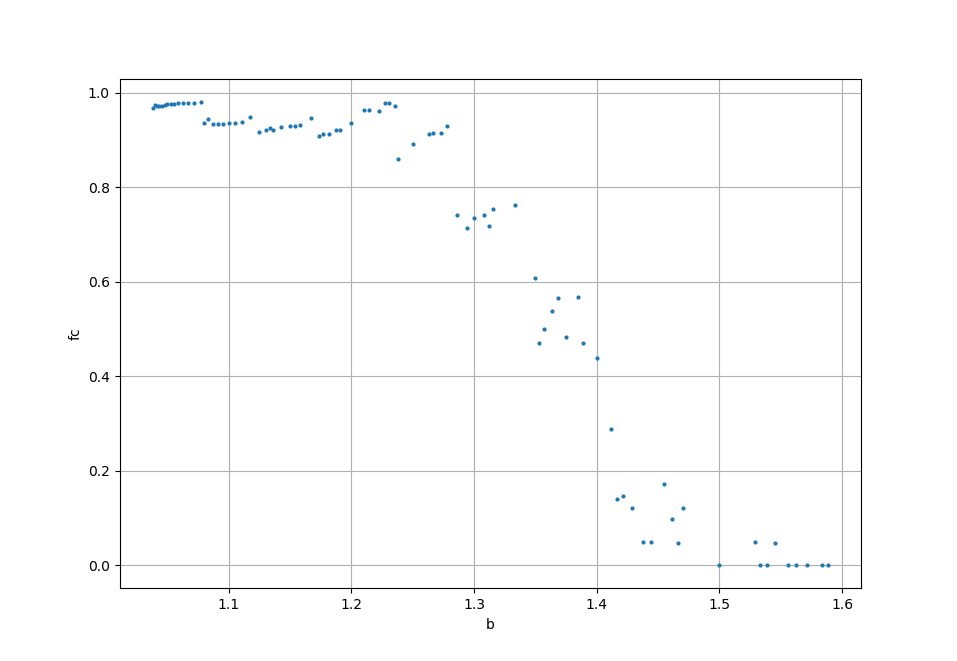

In [27]:
plt.plot(B, r, 'o', markersize = 2)
plt.xlabel('b')
plt.ylabel('fc')
plt.grid(True)
plt.show()

In [13]:
B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 2:
            B.add(i/j + B_INC)
B = sorted(list(B))
len(B)

114

In [14]:
B[50]

1.2857142858142858

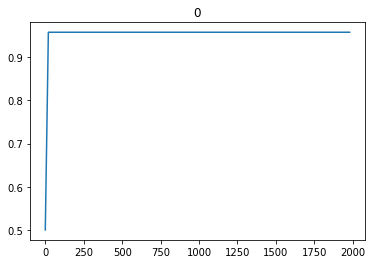

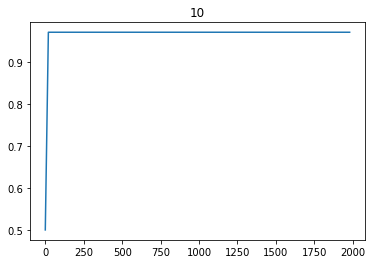

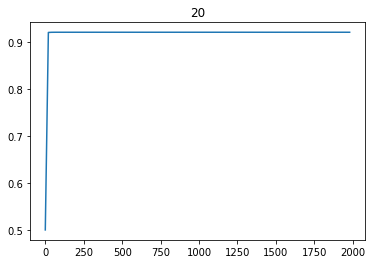

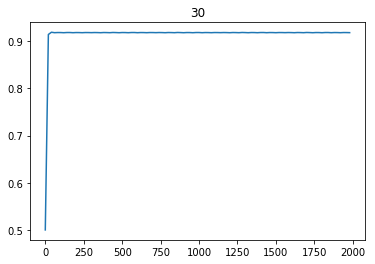

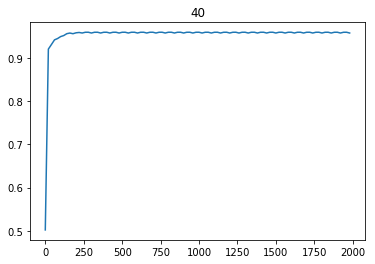

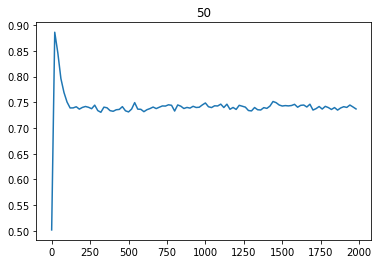

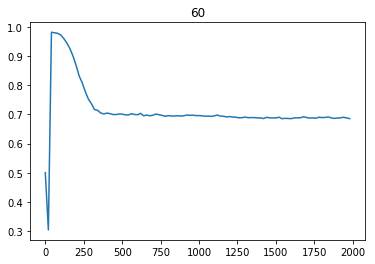

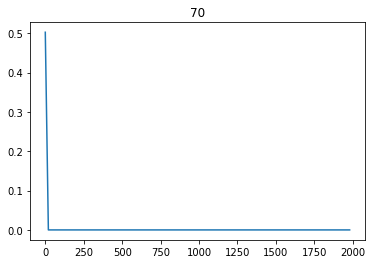

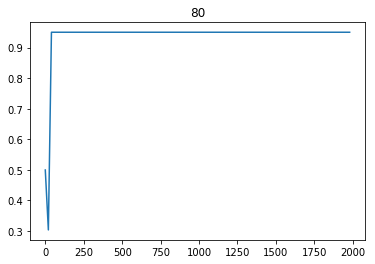

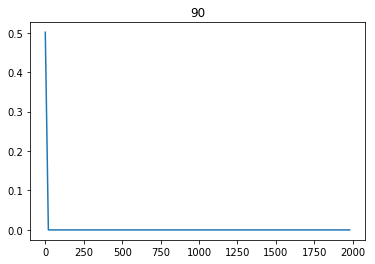

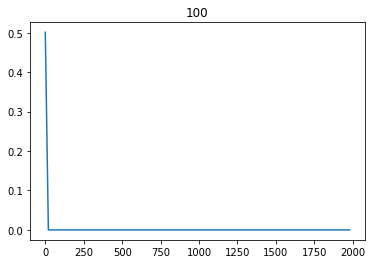

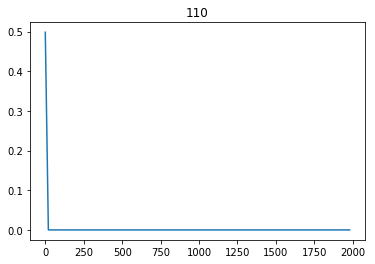

In [9]:
FNAME = 'results/Frequent_measurs/Fc_'
N = 100
for i in range(0, len(B), 10):
    r = np.load(FNAME + str(i) + '.npy')[:N]
    plt.plot(range(0, N*20, 20), r)
    plt.title(str(i))
    plt.show()
    continue

In [15]:
B[57]

1.3500000001

## Проверка времени стабилизации поля

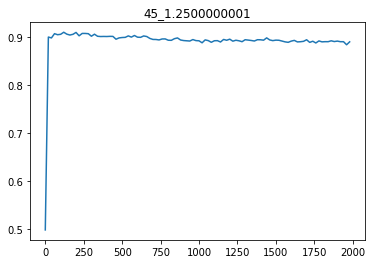

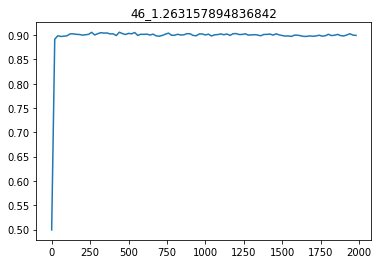

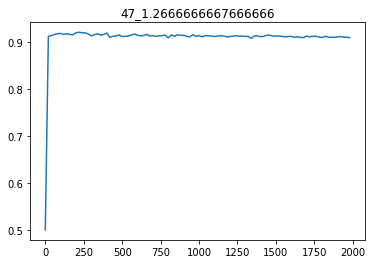

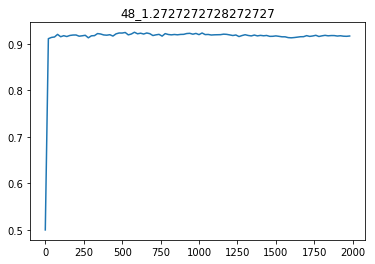

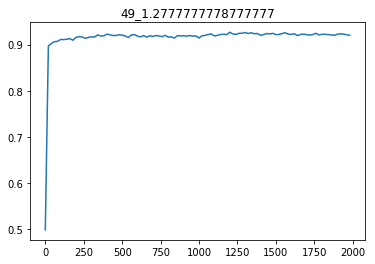

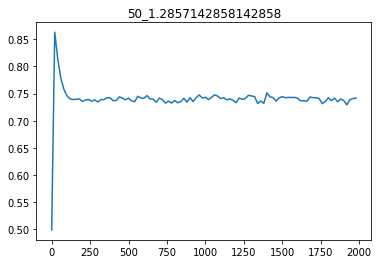

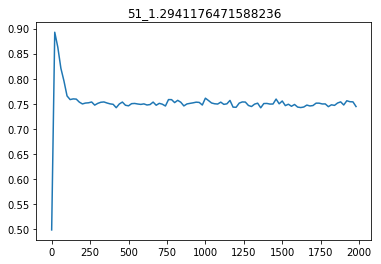

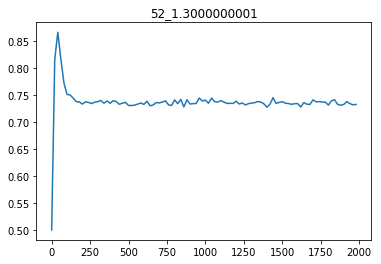

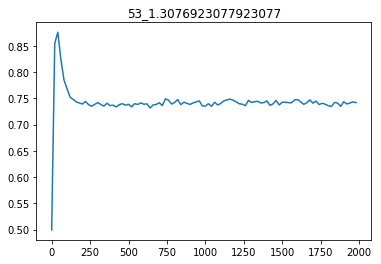

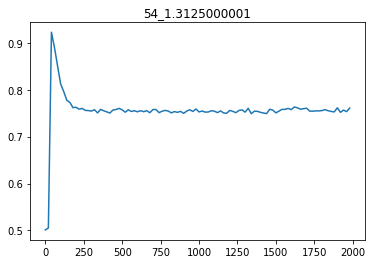

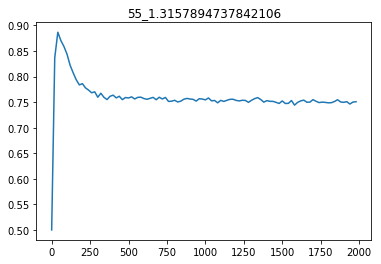

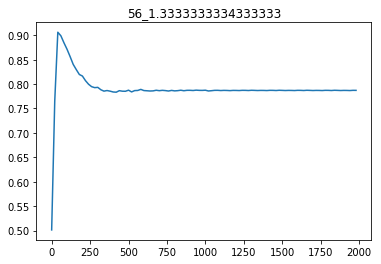

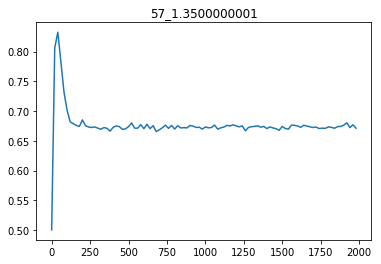

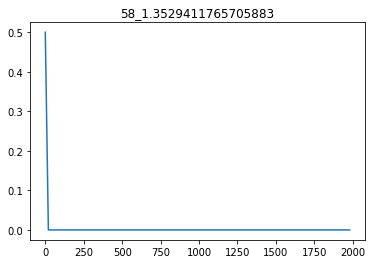

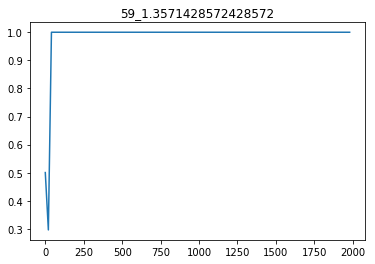

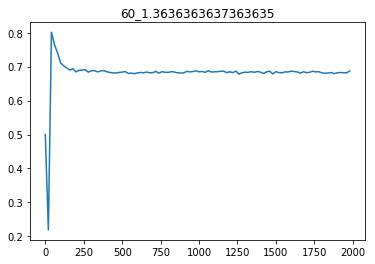

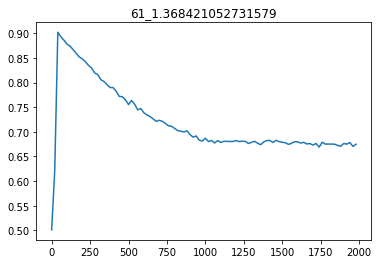

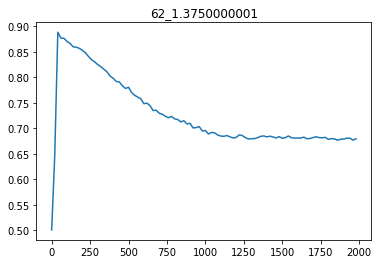

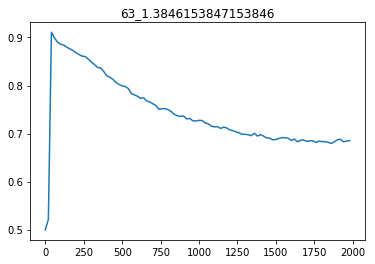

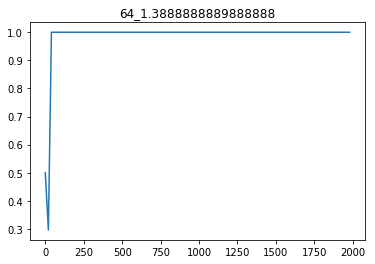

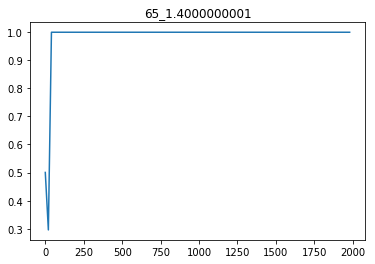

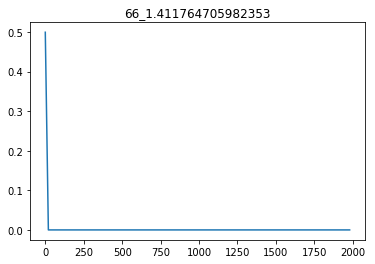

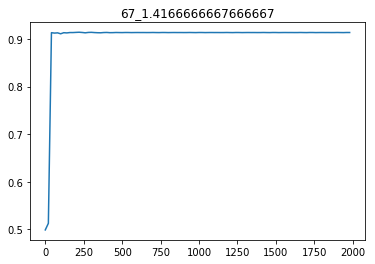

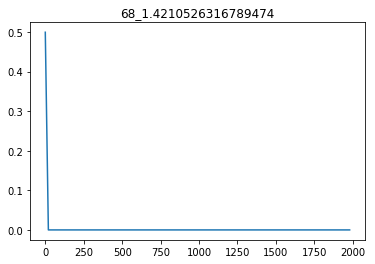

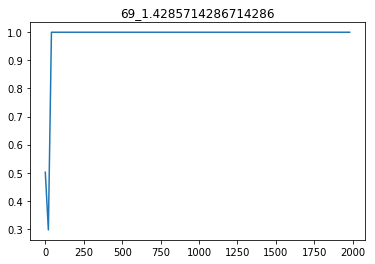

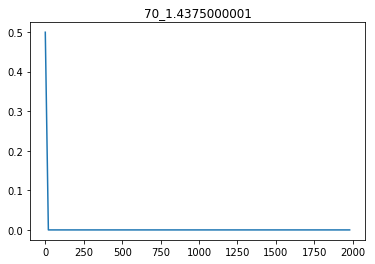

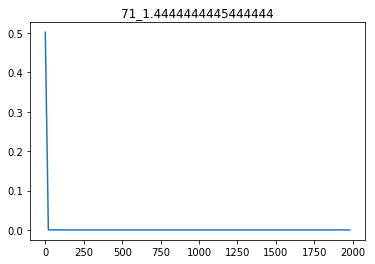

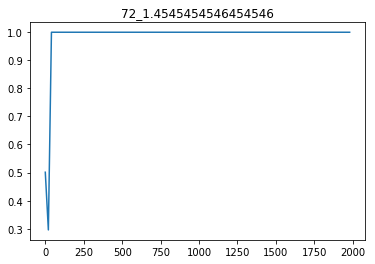

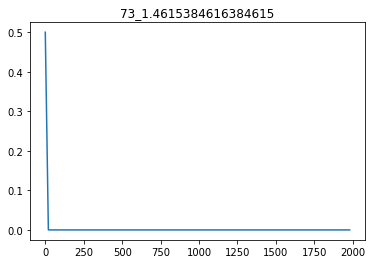

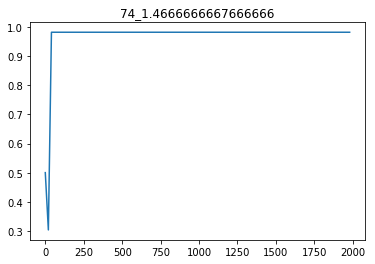

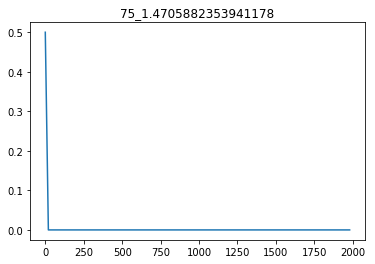

In [93]:
FNAME = 'results/Frequent_measurs2/Fc_'
N = 100
for i in range(0, len(B)):
    if B[i] < 1.25 or B[i] > 1.5:
        continue
    r = np.load(FNAME + str(i) + '.npy')[:N]
    plt.plot(range(0, N*20, 20), r)
    plt.title(str(i) + '_' + str(B[i]))
    plt.show()


В большинстве случаев поля стабилизируются меньше чем за 250 шагов, но в промежутке 1.363 - 1.3846 дохлдит до 2000

## Замеры на больших временах с начальной плотностью кооператоров 0.9

In [10]:
B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1:
            B.add(i/j + B_INC)
B = sorted(list(B))
len(B)

229

In [11]:
Fc = np.zeros((len(B), 100), dtype=float)
N_FIELDS = 10
for i in range(len(B)):
    for j in range(1, N_FIELDS + 1):
        
        fname = 'results/C_0.9/' + str(i) + '_' + str(j) + '.npy'
        f = np.load(fname)
        # plt.plot(range(len(f)), f)
        Fc[i] += f
    Fc[i] = Fc[i] / N_FIELDS

# plt.show()

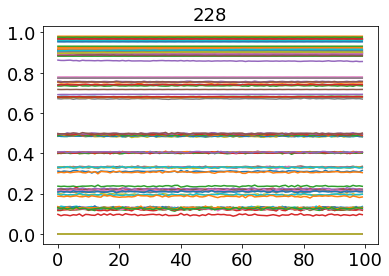

In [12]:
k = 0;
for f in Fc:
    plt.plot(range(len(f)), f)
    plt.title(k)
    k += 1
plt.show()

In [13]:
Fc_mean = np.zeros((len(B)), dtype=float)
for i in range(len(B)):
    Fc_mean[i] = (Fc[i].sum() / len(Fc[i]))

In [14]:
NUM_B = 114
B = B[:NUM_B]
Fc_mean = Fc_mean[:NUM_B]

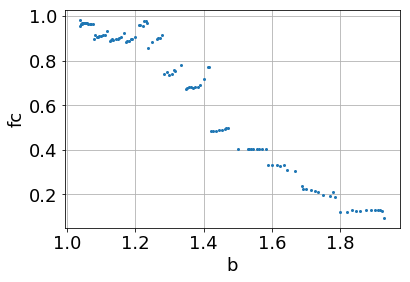

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, Fc_mean, 'o', markersize = 2)

plt.grid(True)
plt.show()

In [27]:
L = (60, 60, 60)

neighbors = tabulate_neighbors(L)

rndm = np.random.RandomState(12345)




In [35]:
field = (rndm.uniform(size=L) > 0.9).astype('int16')

## Исследование флуктуаций

Для нескольких значений b, при которых на больших временах при начальной плотности 0.9, плотность не приближается к 0 или 1, сделаны замеры на 100 независсимых полях, 
2500 начальных шагов
10 замеров через каждые 100 шагов 

In [5]:
B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 2:
            B.add(i/j + B_INC)
B = sorted(list(B))
len(B)

114

In [6]:
Fluct1 = np.zeros((len(B), 100), dtype=float)
for i in range(50, len(B), 5):
    for k in range(100):
        fname = "results\Fields_for_fluctuations_C_0.1/" + str(i) + "_" + str(k) + ".npy"
        f = np.load(fname)
        Fluct1[i][k] = f.mean()


In [7]:
Fluct5 = np.zeros((len(B), 100), dtype=float)
for i in range(50, len(B), 5):
    for k in range(100):
        fname = "results\Fields_for_fluctuations_C_0.5/" + str(i) + "_" + str(k) + ".npy"
        f = np.load(fname)
        Fluct5[i][k] = f.mean()


In [8]:
Fluct9 = np.zeros((len(B), 100), dtype=float)
for i in range(50, len(B), 5):
    for k in range(100):
        fname = "results\Fields_for_fluctuations_C_0.9/" + str(i) + "_" + str(k) + ".npy"
        f = np.load(fname)
        Fluct9[i][k] = f.mean()


На гистаграммах указано количество полей, плотность кооператоров в которых приблезительно равна соответсвующим значениям

In [9]:
N_BINS = 20

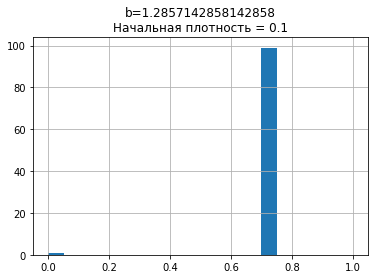

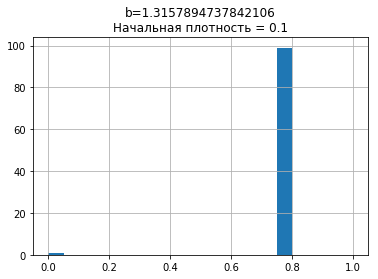

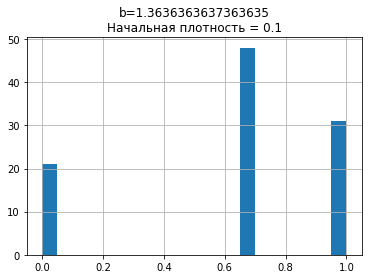

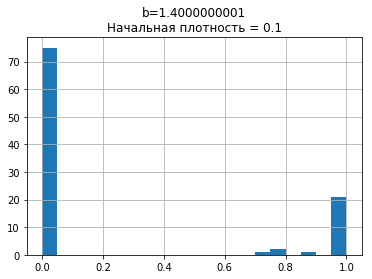

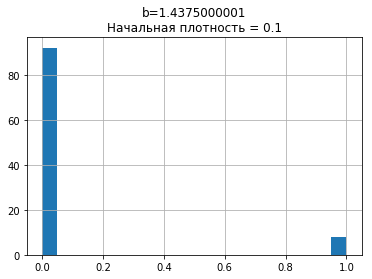

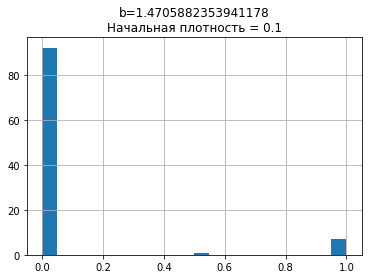

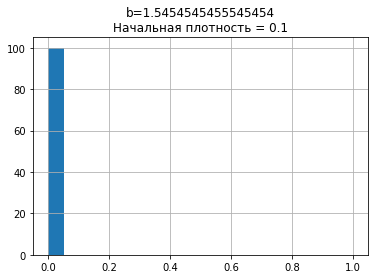

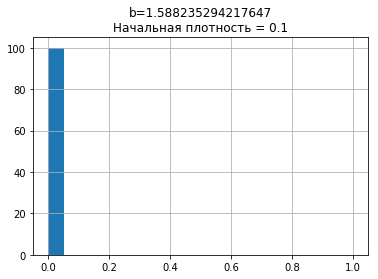

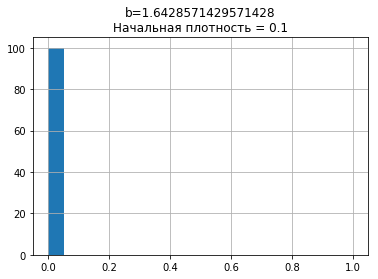

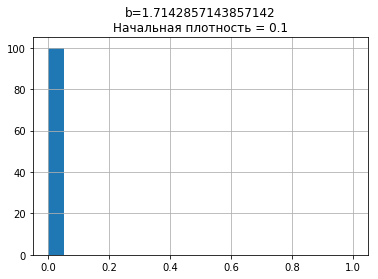

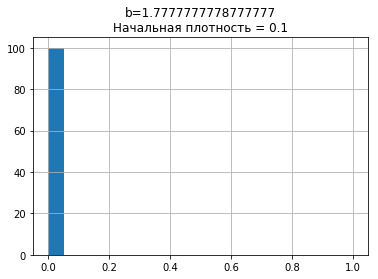

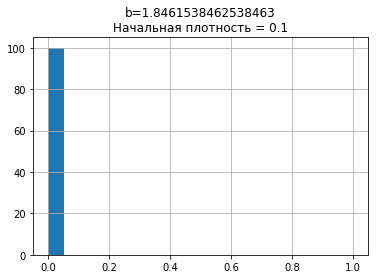

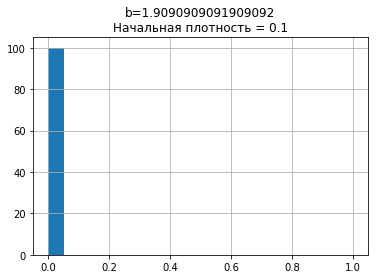

In [18]:
for i in range(50, len(B), 5):
    plt.hist(Fluct1[i], bins=N_BINS, range=(0, 1))
    plt.title("b=" +  str(B[i]) +  "\nНачальная плотность = 0.1")
    plt.grid(True)
    plt.show()

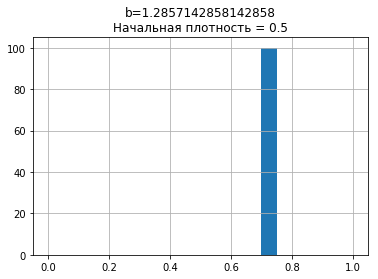

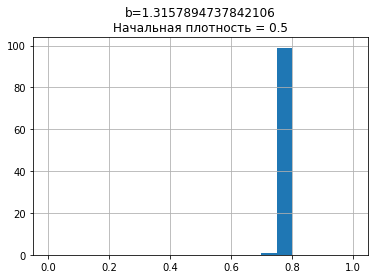

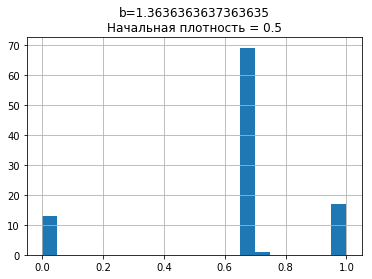

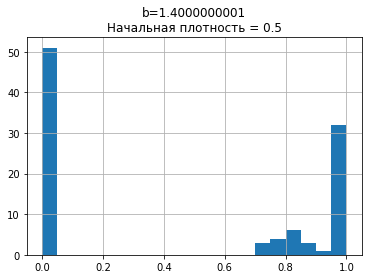

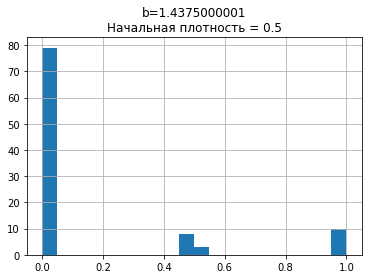

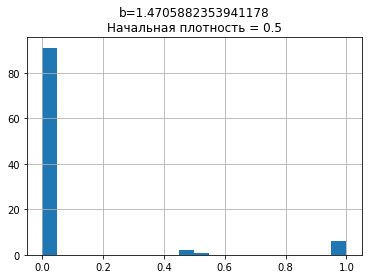

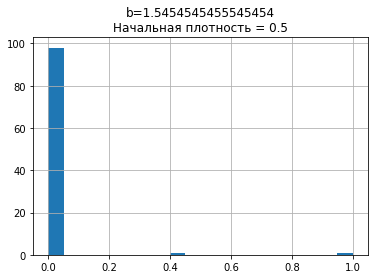

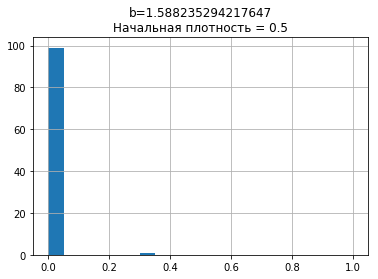

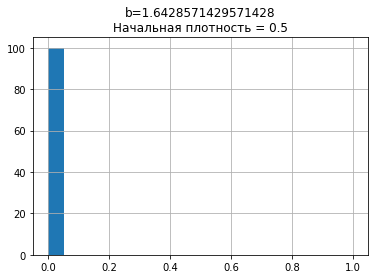

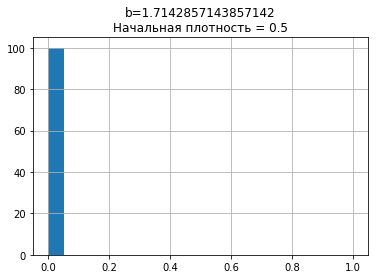

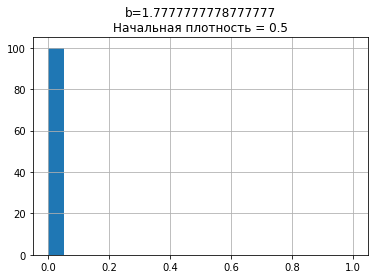

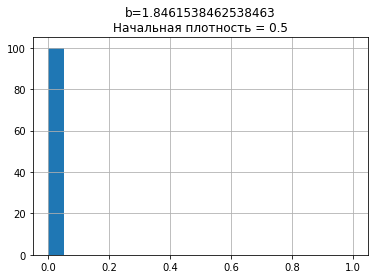

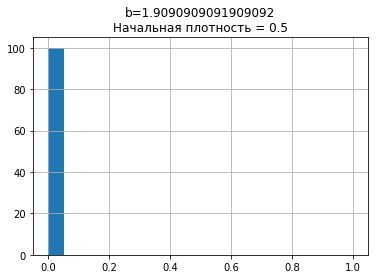

In [21]:
for i in range(50, len(B), 5):
    plt.hist(Fluct5[i], bins=N_BINS, range=(0, 1))
    plt.title("b=" +  str(B[i]) +  "\nНачальная плотность = 0.5")
    plt.grid(True)
    plt.show()

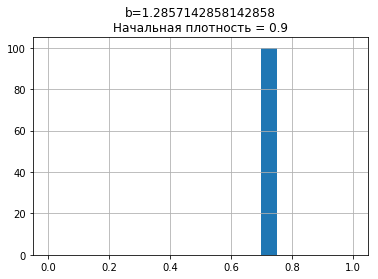

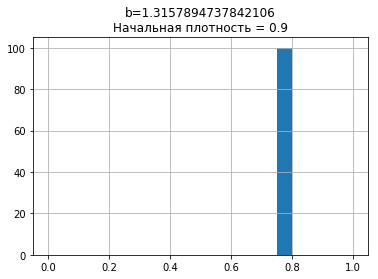

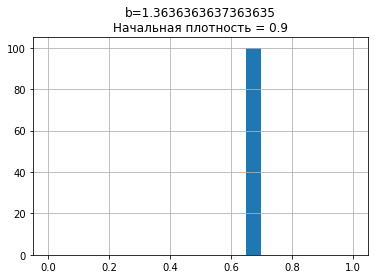

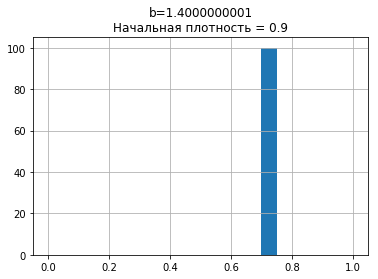

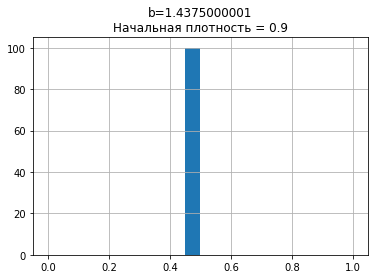

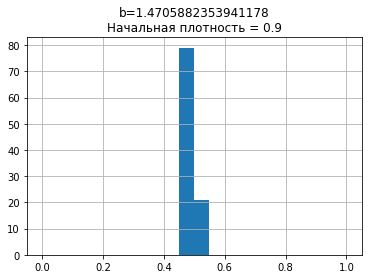

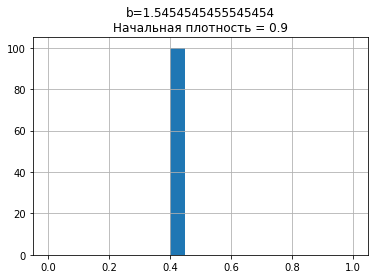

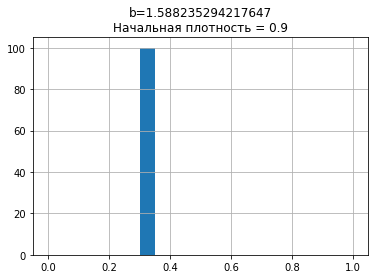

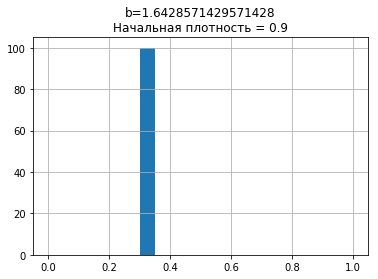

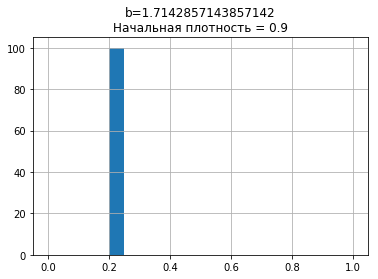

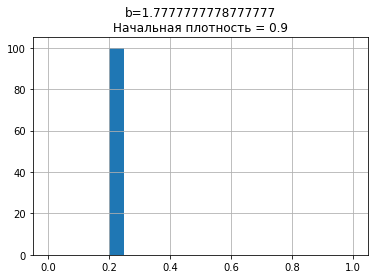

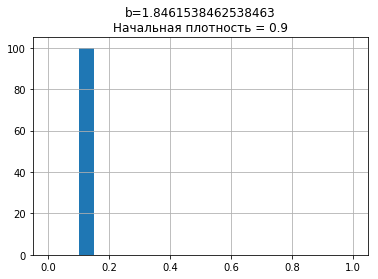

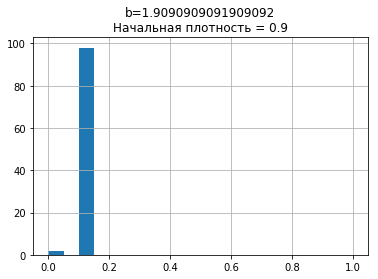

In [22]:
for i in range(50, len(B), 5):
    plt.hist(Fluct9[i], bins=N_BINS, range=(0, 1))
    plt.title("b=" +  str(B[i]) +  "\nНачальная плотность = 0.9")
    plt.grid(True)
    plt.show()

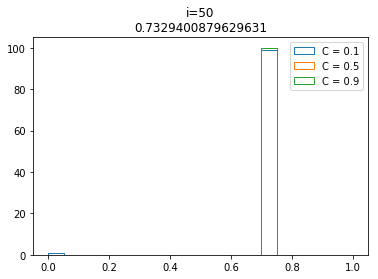

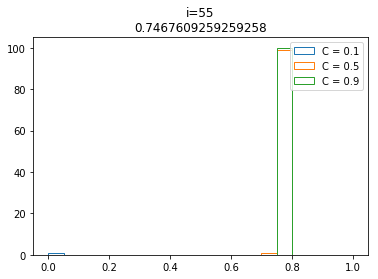

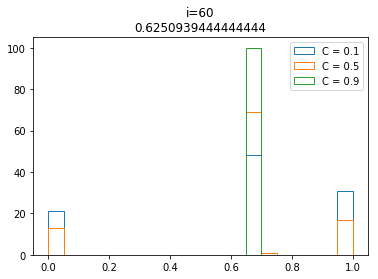

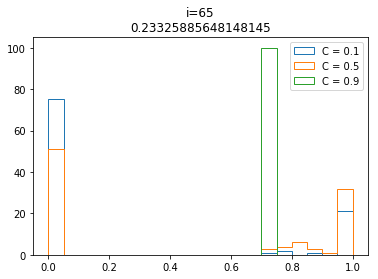

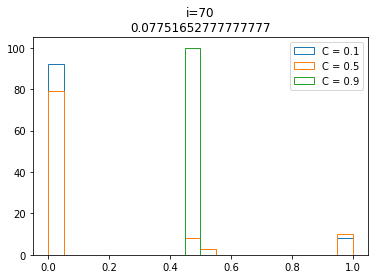

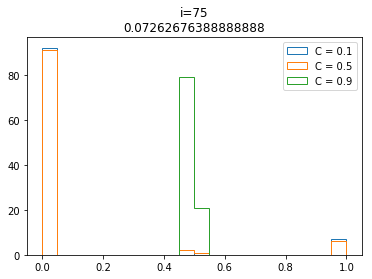

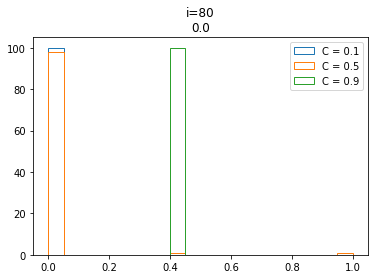

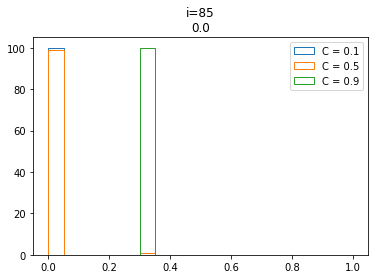

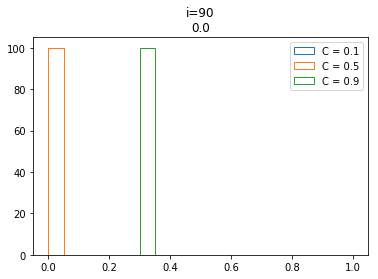

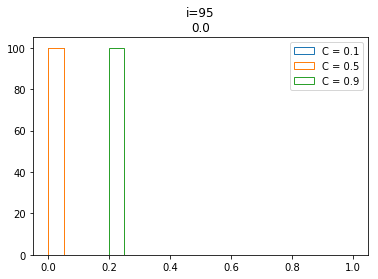

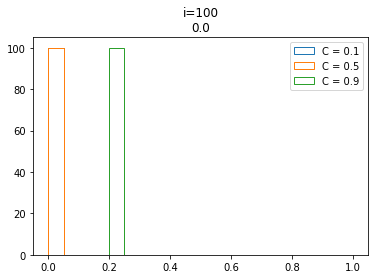

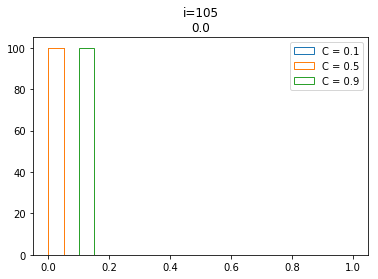

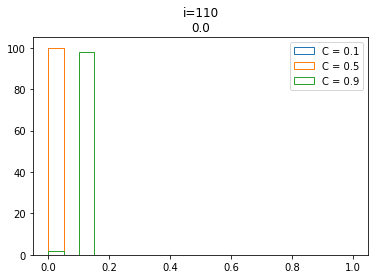

In [59]:

for i in range(50, len(B), 5):
    plt.hist(Fluct1[i], bins=N_BINS, range=(0, 1), histtype= 'step')
    plt.hist(Fluct5[i], bins=N_BINS, range=(0, 1), histtype= 'step')
    plt.hist(Fluct9[i], bins=N_BINS, range=(0, 1), histtype= 'step')
    plt.legend(("C = 0.1", "C = 0.5", "C = 0.9"))
    plt.title("i=" +  str(i) +  "\n" + str(Fluct1[i].mean()))
    plt.show()

In [60]:
F1 = np.zeros(len(B), dtype=float)
for i in range(50, len(B), 5):
    k = 0
    for Fc in Fluct1[i]:
        if Fc > 0.05 and Fc < 0.95:
            k += 1
            F1[i] += Fc
    F1[i] = F1[i] / k
    
F5 = np.zeros(len(B), dtype=float)
for i in range(50, len(B), 5):
    k = 0
    for Fc in Fluct5[i]:
        if Fc > 0.05 and Fc < 0.95:
            k += 1
            F5[i] += Fc
    F5[i] = F5[i] / k
    
F9 = np.zeros(len(B), dtype=float)
for i in range(50, len(B), 5):
    k = 0
    for Fc in Fluct9[i]:
        if Fc > 0.05 and Fc < 0.95:
            k += 1
            F9[i] += Fc
    F9[i] = F9[i] / k

for i in range(50, len(B), 5):
    print(F1[i], F5[i], F9[i])
    
# Выведены средние значения плотности буз учёта полей плотность которых < 0.05 или > 0.95
# 

0.7402999859708194 0.7405189398148144 0.74043687037037
0.7542574354657691 0.7538694907407408 0.7546650092592594
0.6818019483024691 0.6822455886243386 0.6804644074074071
0.7808490740740741 0.813334368191721 0.7177889583333336
nan 0.49254179292929295 0.48519509722222226
0.5110236111111112 0.49803410493827166 0.4987455462962962
nan 0.4131611111111111 0.4055964212962964
nan 0.3349486111111111 0.33231658796296304
nan nan 0.3101447962962963
nan nan 0.2185393796296297
nan nan 0.20971830092592583
nan nan 0.1270033333333333
nan nan 0.13042191043083906


C:\Users\romic\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\romic\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Независсимо от начальной плотности кооператоров, если исключить поля, в которых плотность принимает значеиния близкие к 0 и 1, средние плотности будут примерно одинаковые.

Флуктуации от реплики к реплике

In [73]:
for i in range(50, len(B), 5):
    print(np.std(Fluct9[i]))


0.0013405368081425102
0.0017585110911308756
0.0016260828476119202
0.00418802872477203
0.0016657463921411436
0.0017603818966542193
0.0020145408202507666
0.0023204237426384866
0.00219192932531619
0.0024174155509349084
0.002310183659406272
0.0033360780944799713
0.018251692194927976


Флуктуации от реплики к реплике не превышают 0.012

Флуктуации на одной реплике

In [11]:
B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1:
            B.add(i/j + B_INC)
B = sorted(list(B))
len(B)

229

In [27]:
N_FIELDS = 10
Fluct = np.zeros((len(B), N_FIELDS), dtype=float)
for i in range(len(B)):
    for j in range(1, N_FIELDS + 1):
        
        
        fname = 'results/C_0.9/' + str(i) + '_' + str(j) + '.npy'
        f = np.load(fname)
        # plt.plot(range(len(f)), f)
        Fluct[i,j - 1] = np.std(f)
    print(i, Fluct[i].mean())

# plt.show()

0 1.2212453270876723e-16
1 5.747270780515412e-07
2 2.2651083760361527e-06
3 7.522257783295761e-07
4 1.7424383287157443e-06
5 5.747270780071322e-07
6 2.2622980289981737e-06
7 1.554312234475219e-16
8 1.6653345369377348e-16
9 1.5381810164970454e-06
10 1.5156929448778385e-06
11 7.578464725166126e-07
12 1.554312234475219e-16
13 3.7892323638826476e-07
14 3.2530769577918034e-06
15 1.5184748583310303e-05
16 2.986068339555993e-05
17 1.5245716494821182e-05
18 1.0577774163277748e-05
19 3.0398222737452264e-05
20 2.6224226743663435e-05
21 1.810278705468572e-05
22 4.125040350109057e-05
23 1.6910990237522662e-05
24 5.488512071712204e-05
25 5.5195604976351475e-05
26 5.708323834378088e-05
27 4.805054633602132e-05
28 5.553247352819135e-05
29 6.527523206541663e-05
30 7.422921876172568e-05
31 9.335136096702131e-05
32 0.00010732481307322347
33 0.00012032924737518942
34 0.00011231237781219556
35 0.00011128274178182547
36 0.0001225715007568133
37 0.00010152904104110303
38 0.0007116588368842366
39 0.000736052

In [45]:
np.max(Fluct)

0.011460891663892536

Флуктуации на одной реплике не превышают 0.012

## Хаотические режимы

In [18]:
B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 2:
            B.add(i/j + B_INC)
B = sorted(list(B))
len(B)

114

In [13]:
SIZE = 60
L = (SIZE, SIZE, SIZE)
neighbors = tabulate_neighbors(L)

In [30]:
# код используемый для замеров на кластере
rndm = np.random.RandomState(17)
C_PROB = 0.9 # test 0.1, 0.5, 0.9
N_STEPS = 1
N_MEASUR = 1000
N_FIELDS = 1 
BURN_IN_STEPS = 1
DIR_NAME = "chaotic"

for i in range(len(B)):
    b = B[i]
    for k in range(N_FIELDS):
        results = np.zeros((N_MEASUR), dtype=int)
        field = (rndm.uniform(size=L) > C_PROB).astype('int16')
        field = evolve3D_2_C(field, neighbors, b, num_steps=BURN_IN_STEPS)
        for measure in range(N_MEASUR):
            field_old = field.copy()
            field = evolve3D_2_C(field, neighbors, b, num_steps=N_STEPS)
            results[measure] =  (abs(field - field_old)).sum()
        fname = DIR_NAME + "/" + str(i) + "_" + str(k)
        np.save(fname, results) 




KeyboardInterrupt: 

In [23]:
Chaotic_measures = np.zeros((len(B), 10))
for i in range(len(B)):
    for j in range(10):
        fname = 'results/chaotic/' + str(i) + '_' + str(j) + '.npy'
        f = np.load(fname)
        Chaotic_measures[i, j] = f.mean()

In [24]:
print(Chaotic_measures.argmax() // 10)
Chaotic_measures.max() / 60**3

68


0.3014762037037037

In [25]:
Chaotic_max = np.zeros(len(B))
for i in range(len(B)):
    Chaotic_max[i] = Chaotic_measures[i].max()

<IPython.core.display.Javascript object>


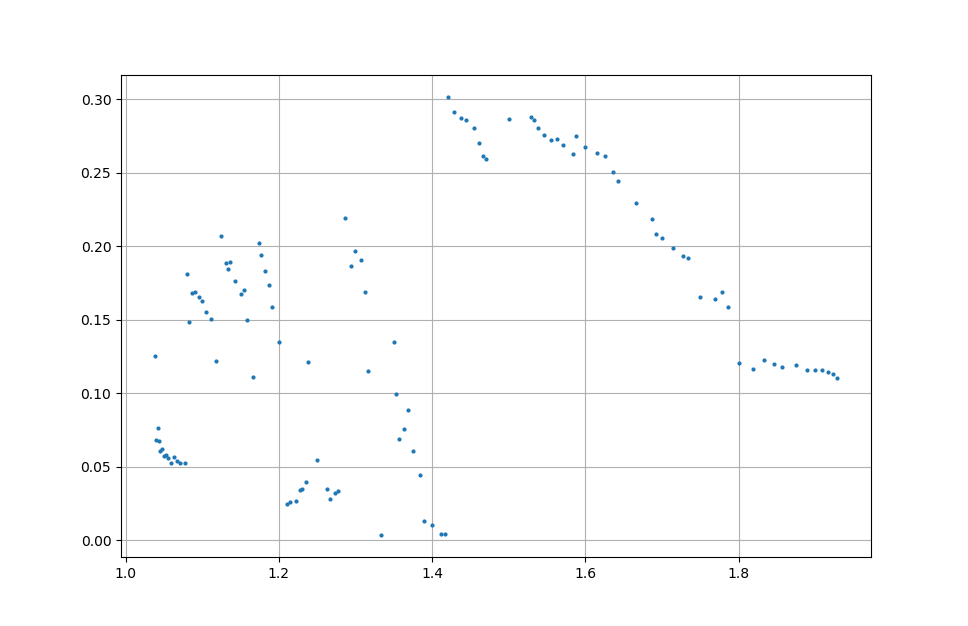

In [28]:
plt.plot(B, Chaotic_max / 60**3, 'o', markersize = 2)
plt.grid(True)
plt.show()

# Persistance 

In [10]:
B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 2:
            B.add(i/j + B_INC)
B = sorted(list(B))
len(B)

114

In [31]:
SIZE = 60
L = (SIZE, SIZE, SIZE)
neighbors = tabulate_neighbors(L)

In [48]:
# код используемый для замеров на кластере
rndm = np.random.RandomState(17)
C_PROB = 0.9 # test 0.1, 0.5, 0.9
N_MEASUR = 5000 
N_FIELDS = 1 
DIR_NAME = "PERSISTENCE"

for i in range(len(B)):
    b = B[i]
    for k in range(N_FIELDS):
        results = np.zeros((N_MEASUR), dtype=float)
        chenged = np.zeros(L, dtype=int)
        field = (rndm.uniform(size=L) > C_PROB).astype('int16')
        for measure in range(N_MEASUR):
            field_old = field.copy()
            field = evolve3D_2_C(field, neighbors, b, num_steps=1)
            chenged[abs(field - field_old) == 1] = 1
            results[measure] = 1 - chenged.sum() / (SIZE**3)
        fname = DIR_NAME + "/" + str(i) + "_" + str(k)
        np.save(fname, results) 




0.7371481481481481
0.6989722222222222
0.6841296296296296
0.6803703703703703
0.6798935185185185
0.6797962962962962
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296296296
0.6797546296

KeyboardInterrupt: 

In [43]:
b.sum()

1

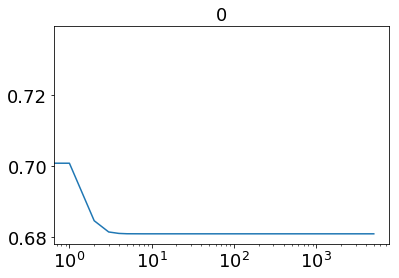

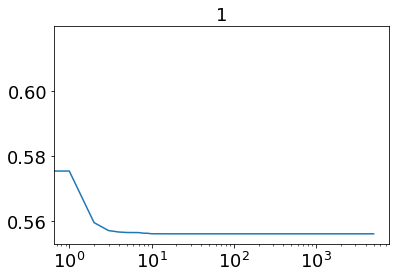

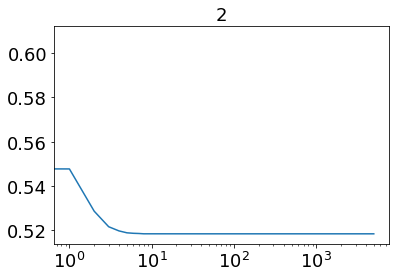

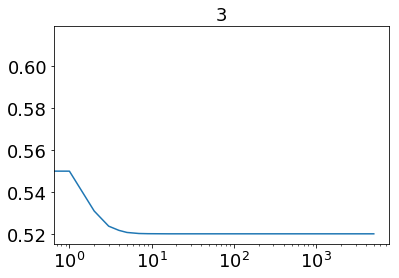

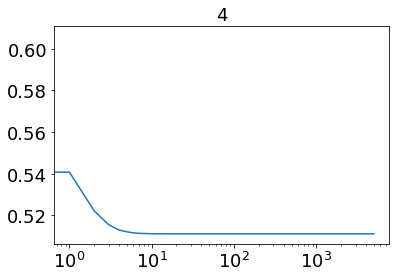

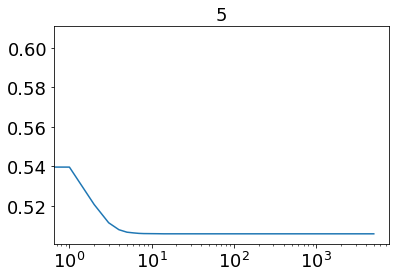

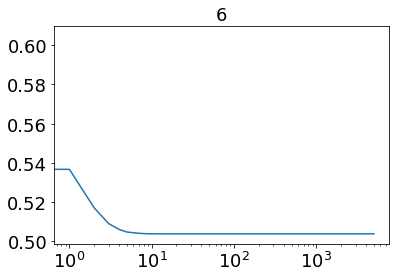

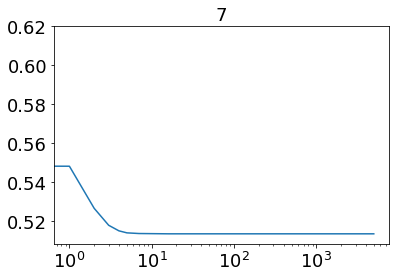

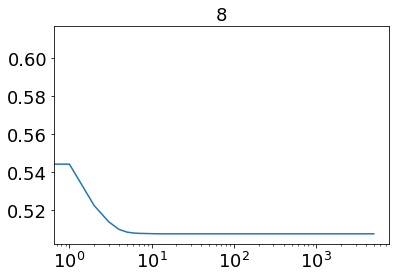

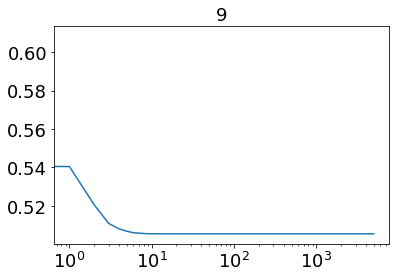

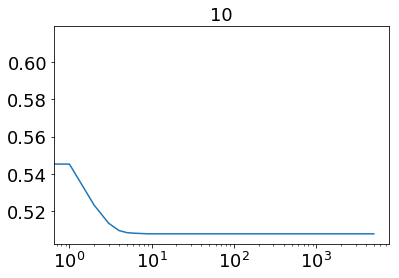

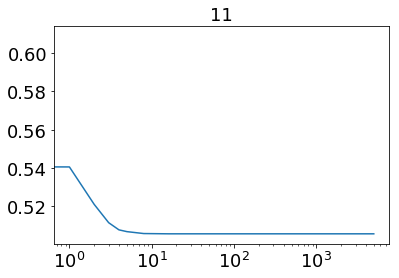

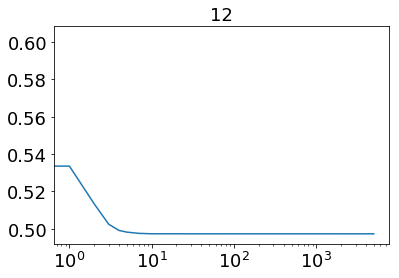

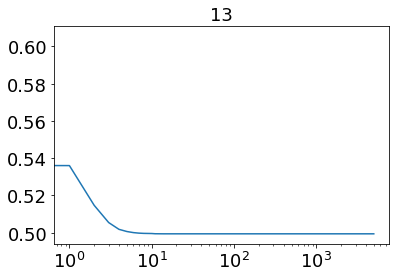

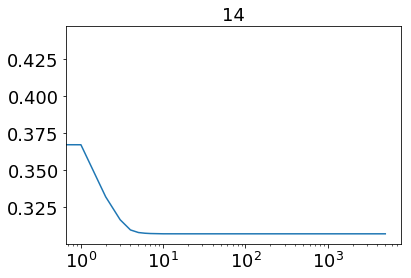

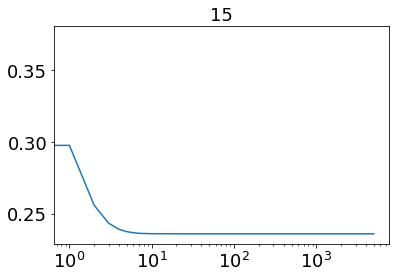

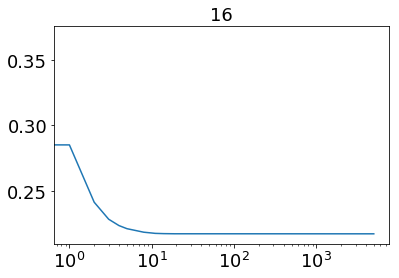

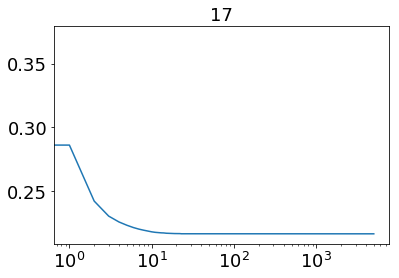

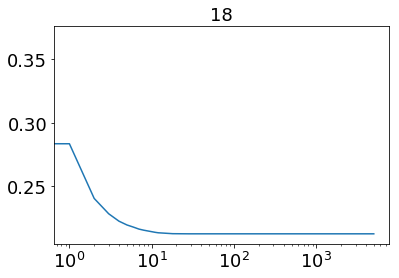

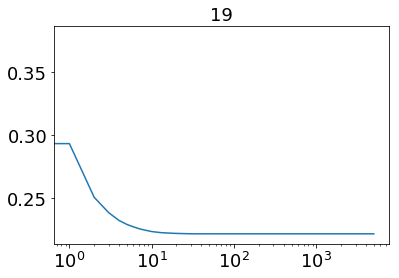

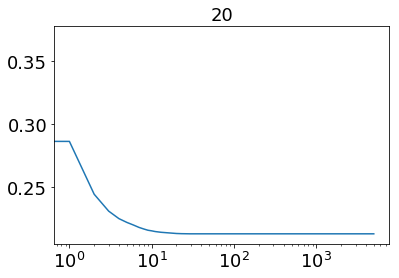

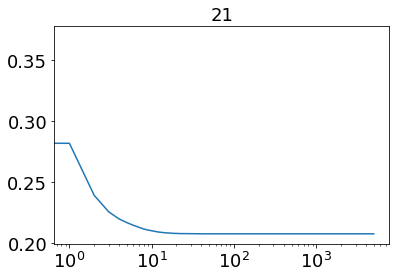

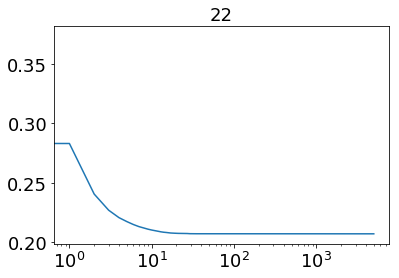

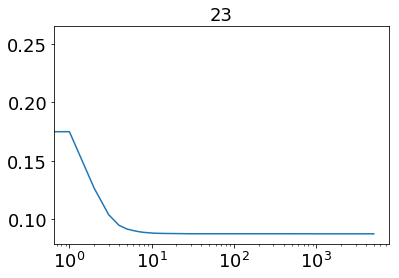

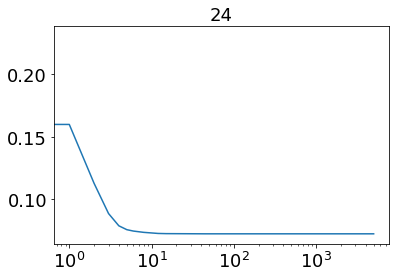

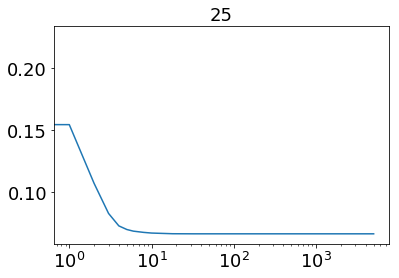

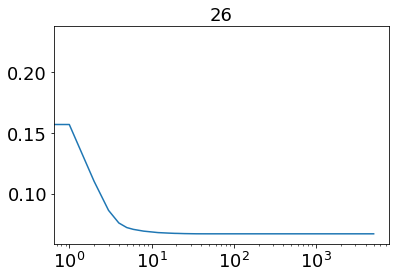

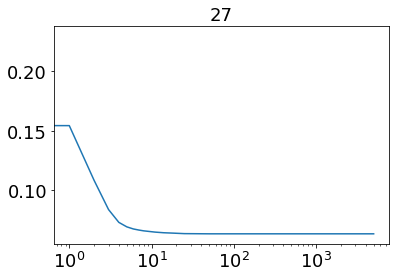

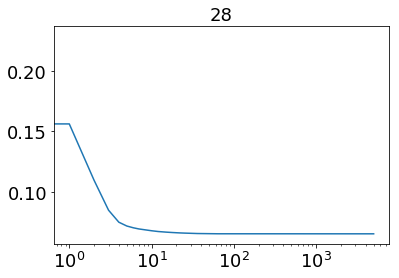

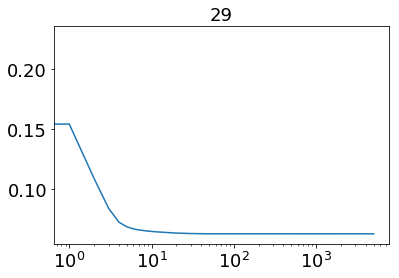

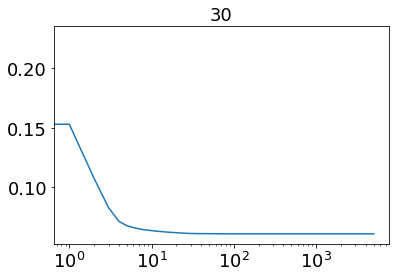

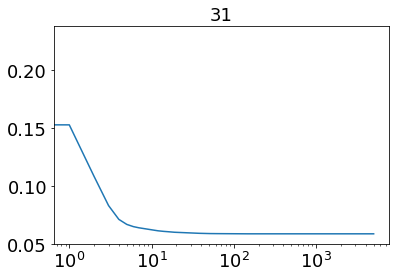

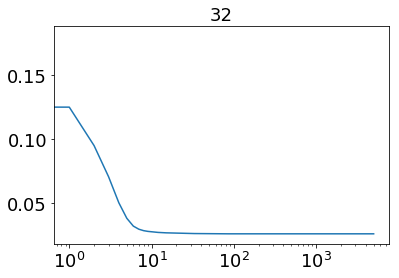

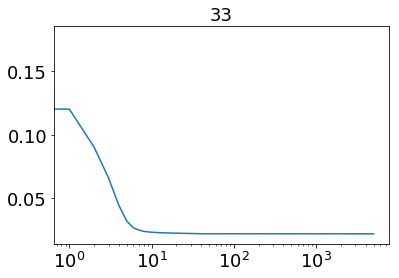

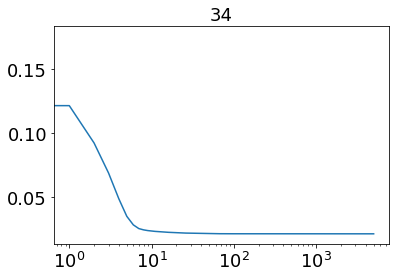

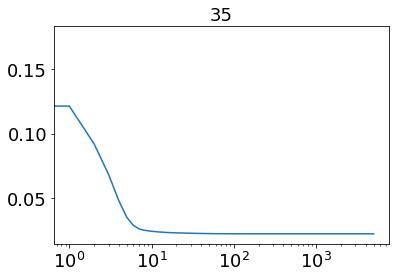

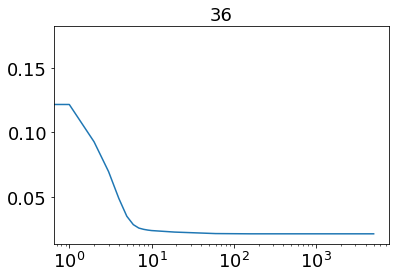

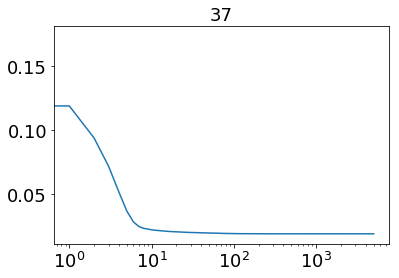

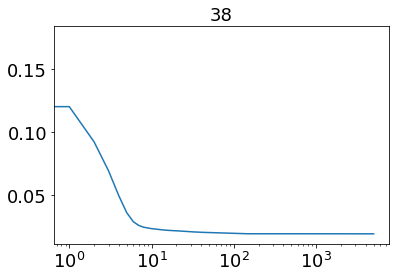

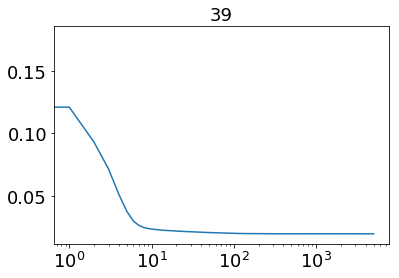

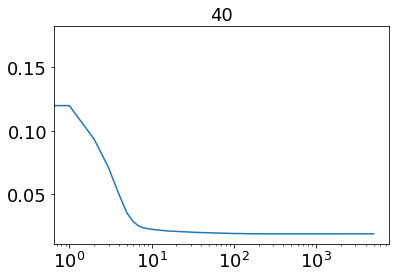

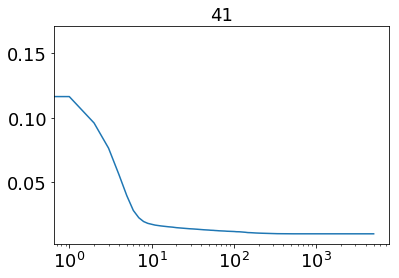

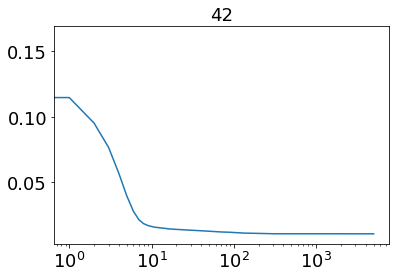

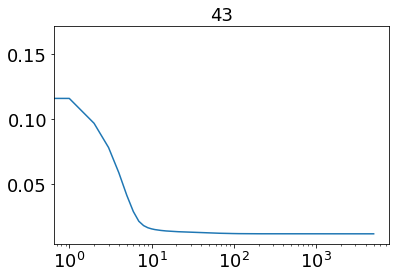

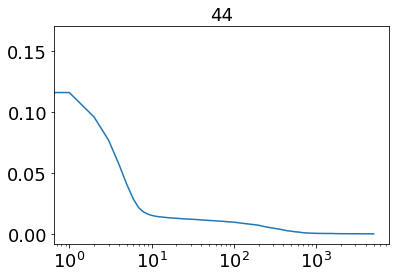

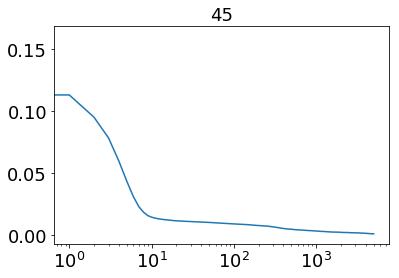

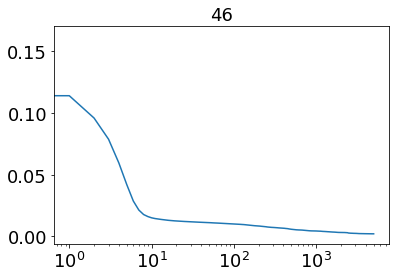

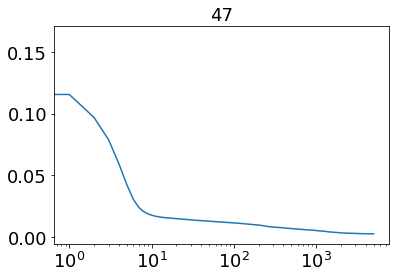

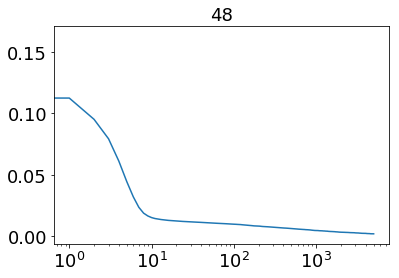

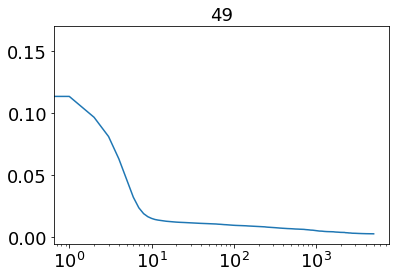

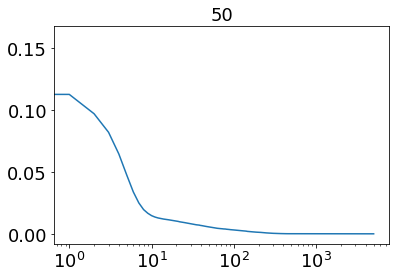

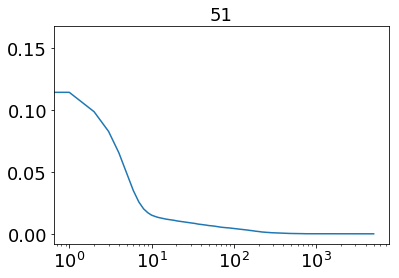

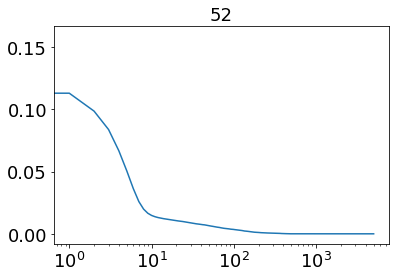

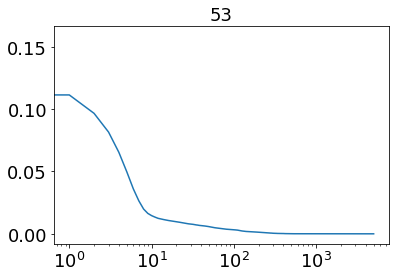

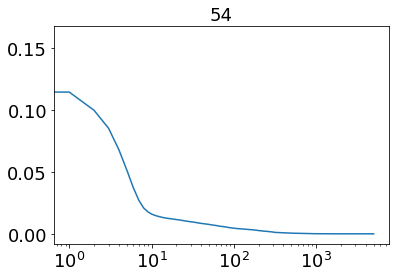

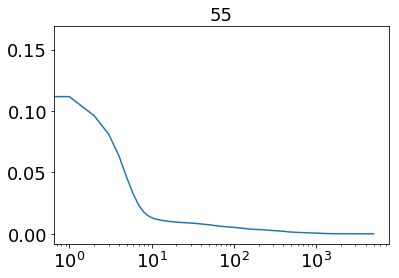

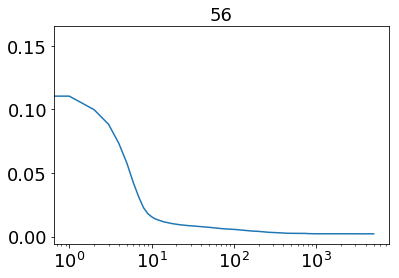

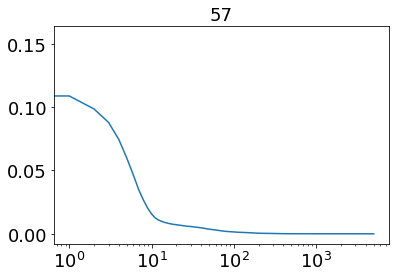

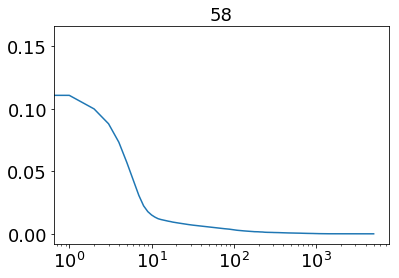

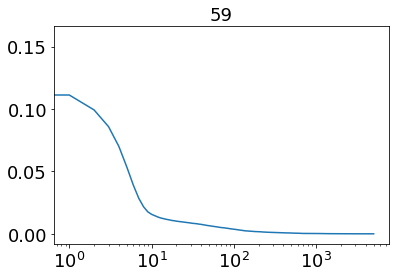

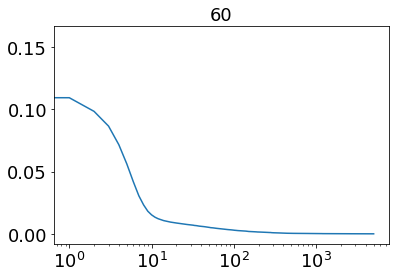

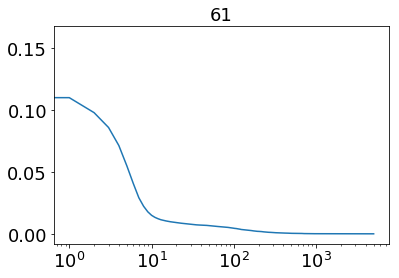

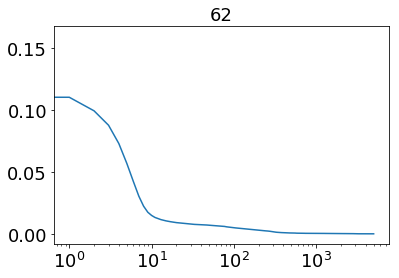

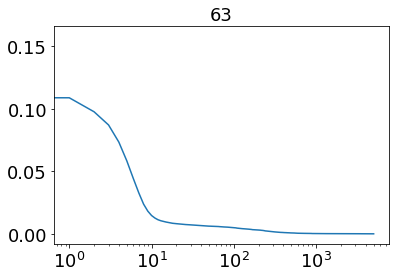

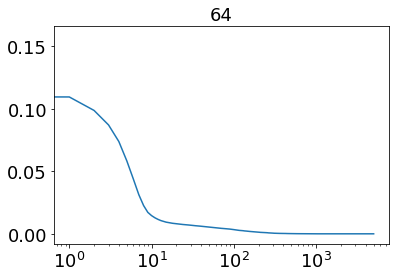

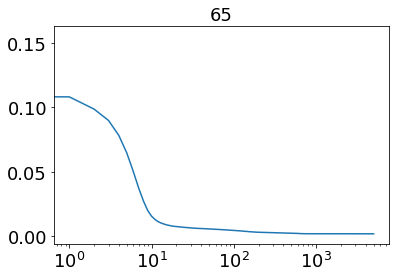

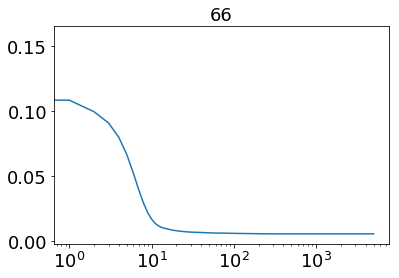

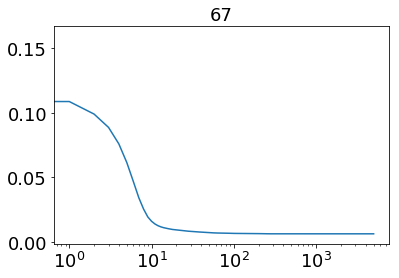

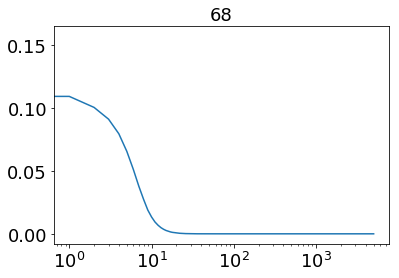

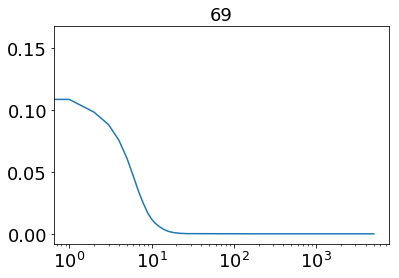

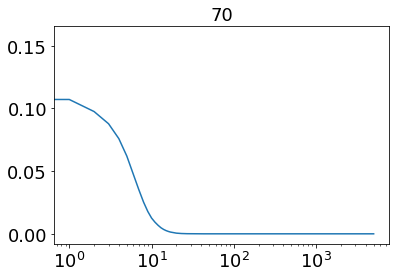

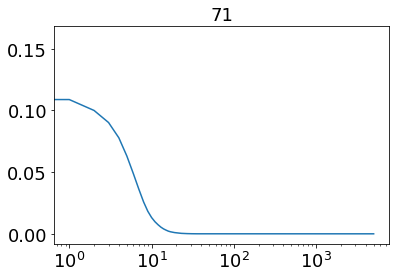

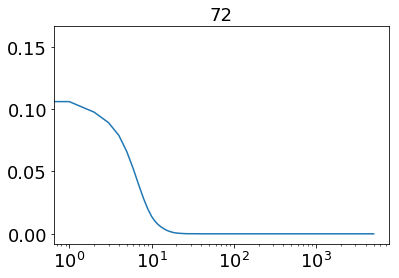

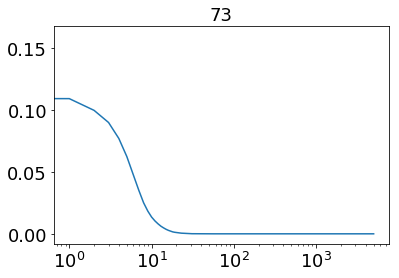

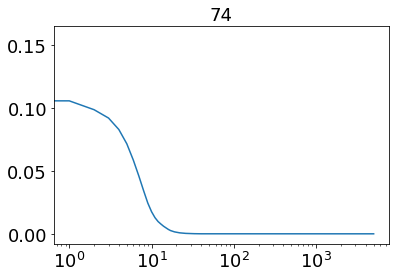

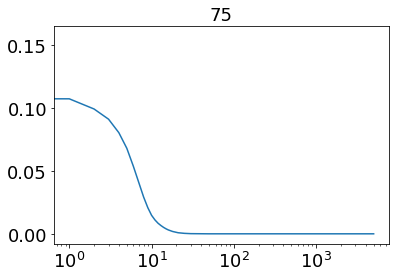

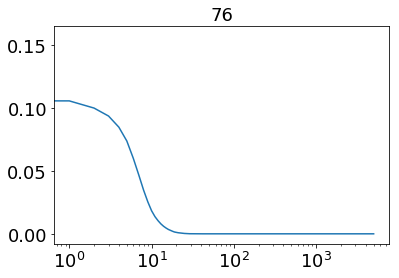

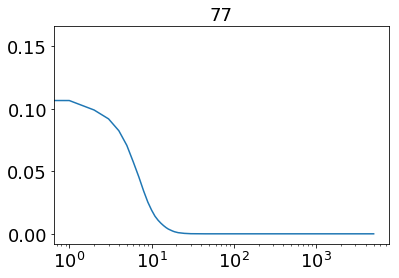

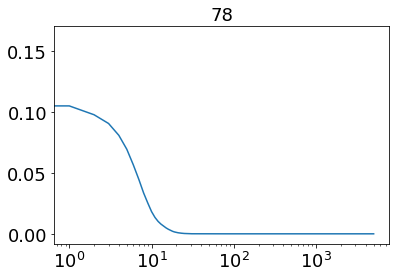

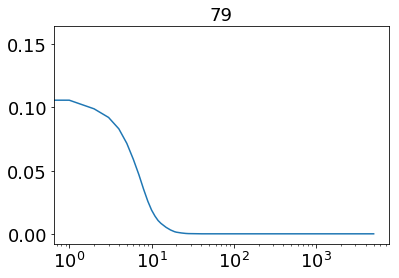

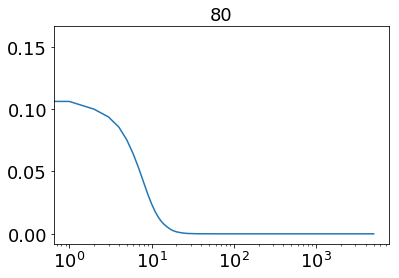

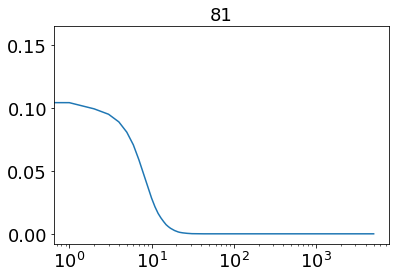

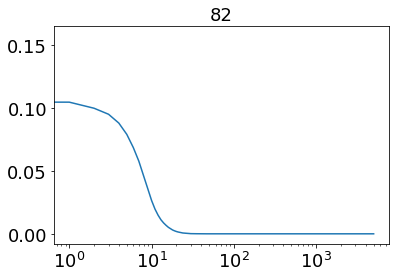

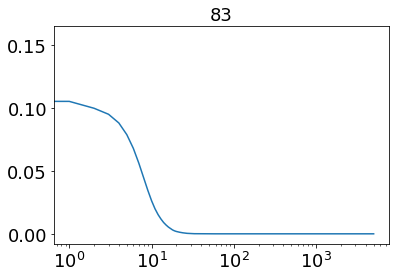

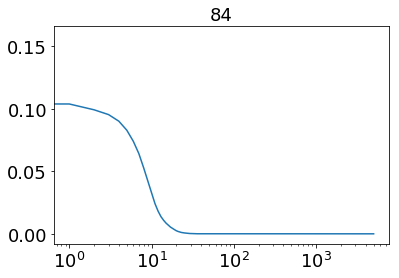

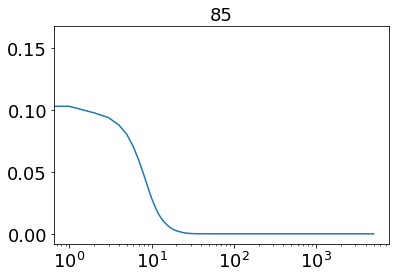

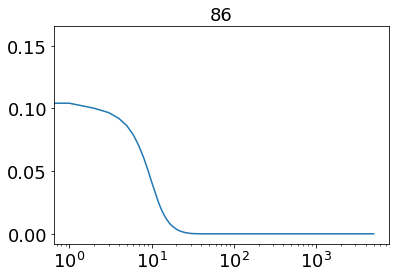

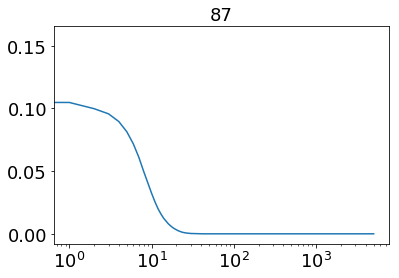

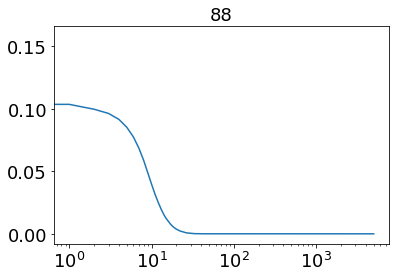

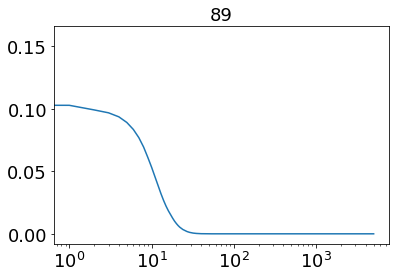

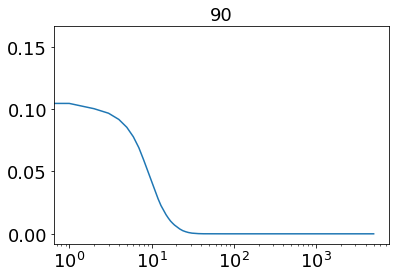

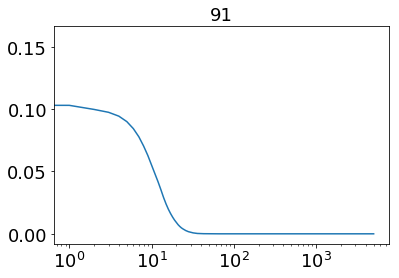

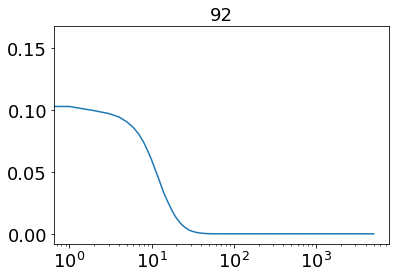

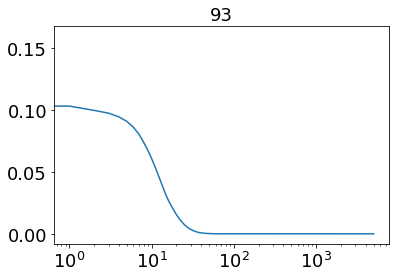

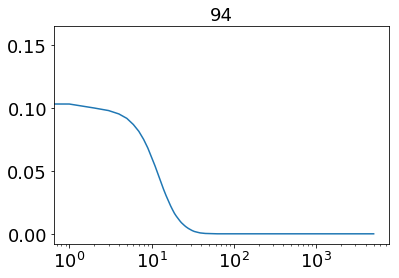

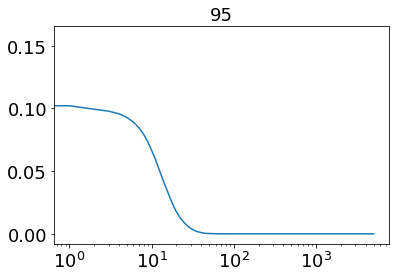

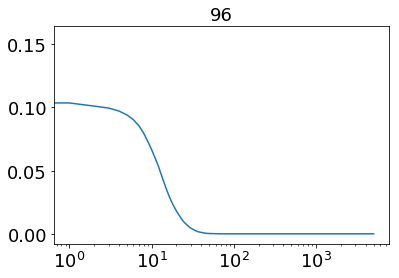

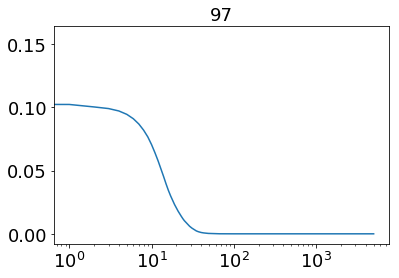

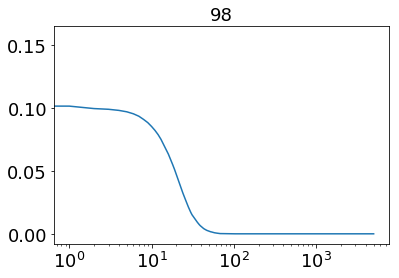

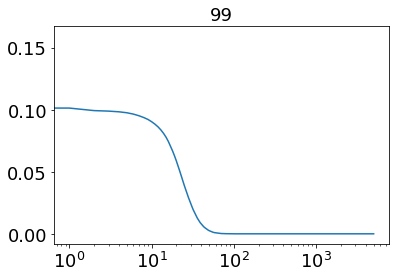

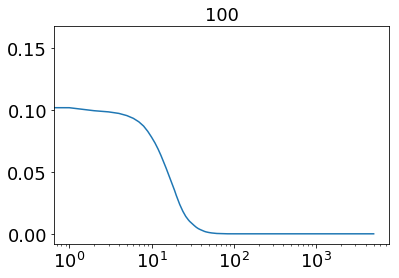

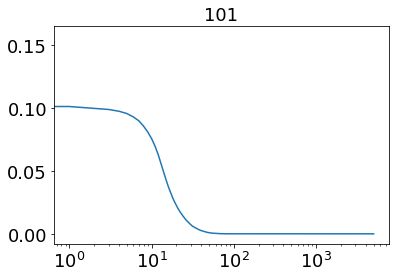

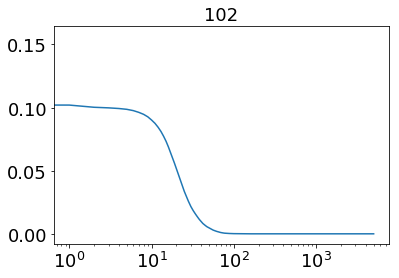

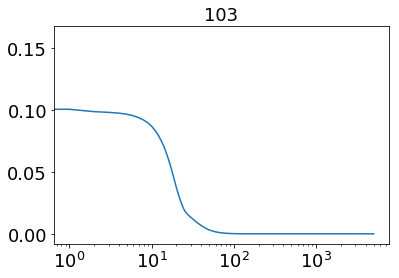

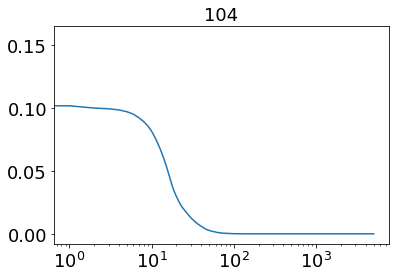

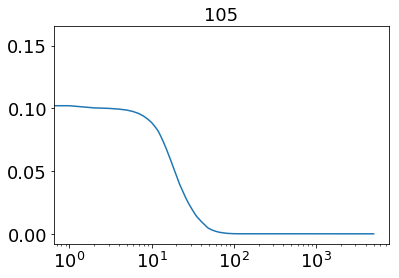

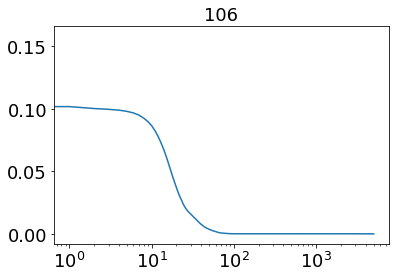

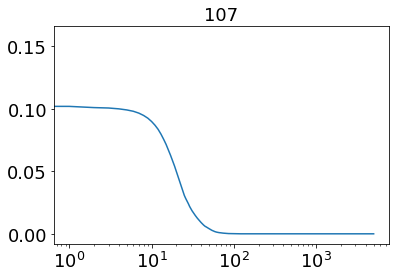

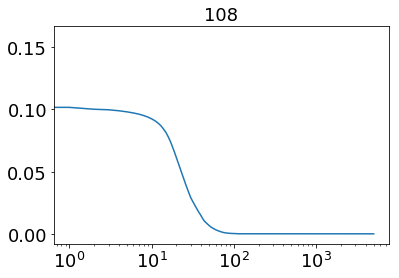

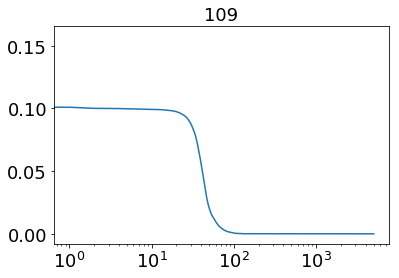

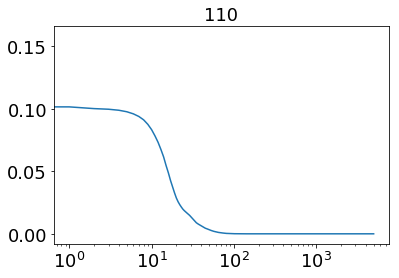

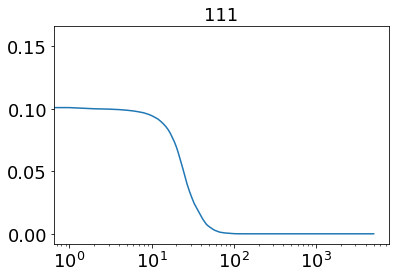

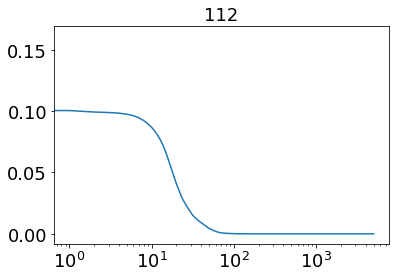

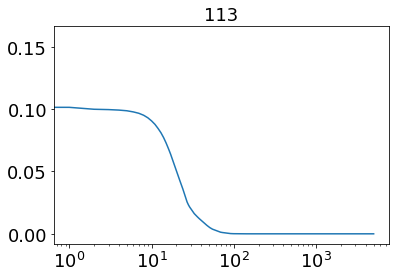

In [5]:
dir_name = 'results\\PERSISTENCE\\'
for i in range(len(B)):
    p = np.load(dir_name + str(i) + '_' + '0.npy')
    plt.plot(range(len(p)), p)
    plt.xscale('log')
    plt.title(str(i))
    plt.show()

<IPython.core.display.Javascript object>


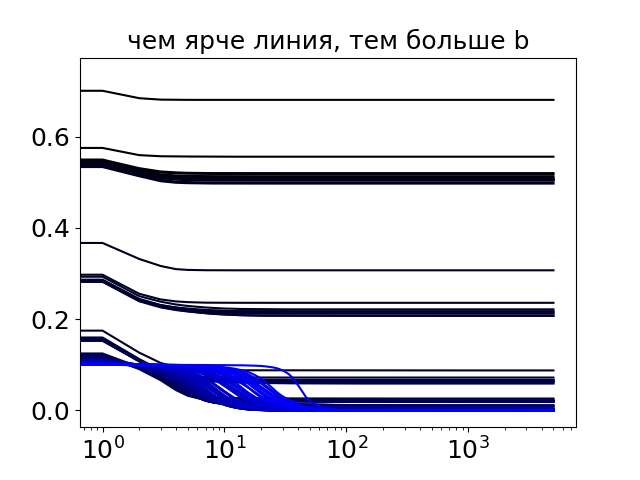

In [31]:
dir_name = 'results\\PERSISTENCE\\'
for i in range(len(B)):
    p = np.load(dir_name + str(i) + '_' + '0.npy')
    plt.plot(range(len(p)), p, color = (0, 0, i / len(B)))
    plt.xscale('log')
plt.title("чем ярче линия, тем больше b")
plt.show()

# Percistence после стабилизации

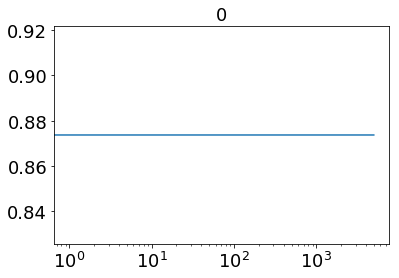

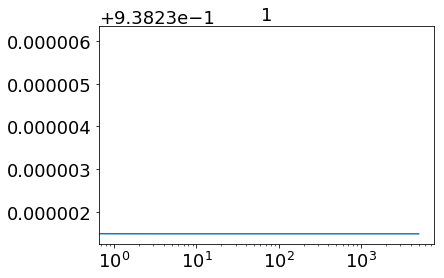

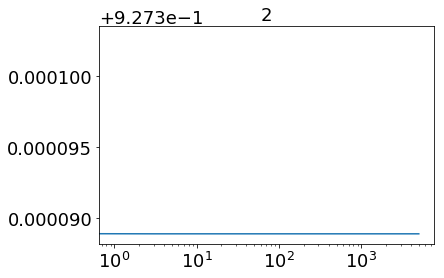

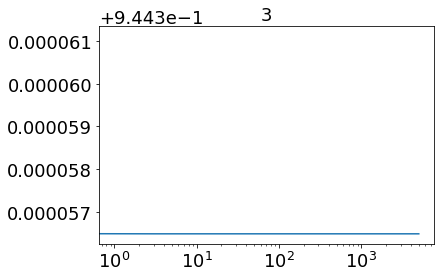

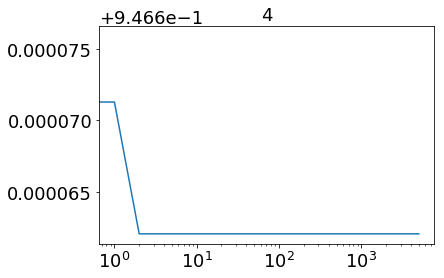

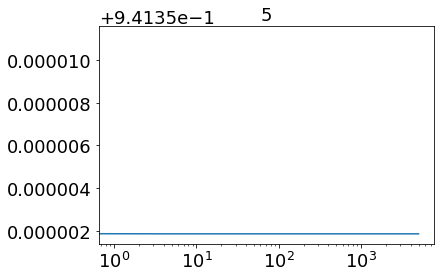

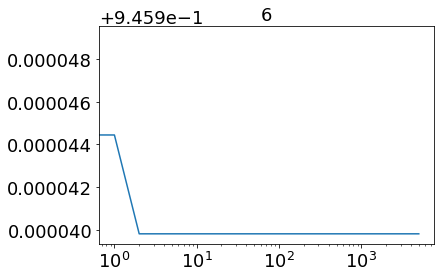

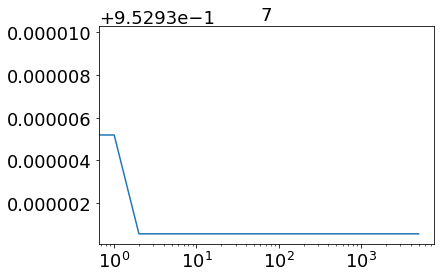

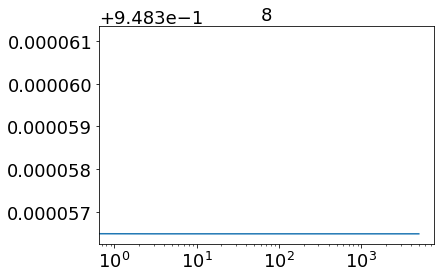

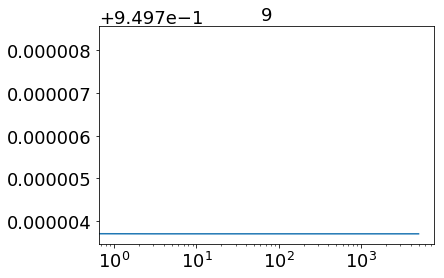

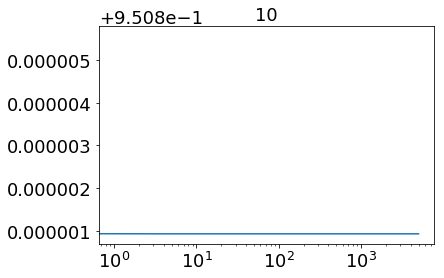

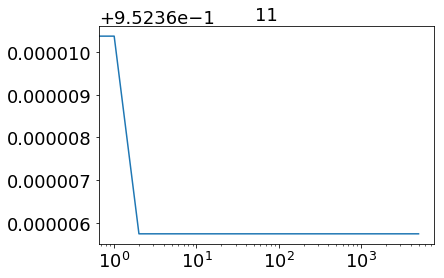

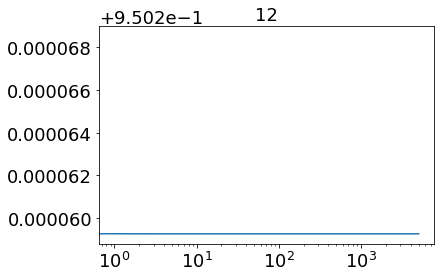

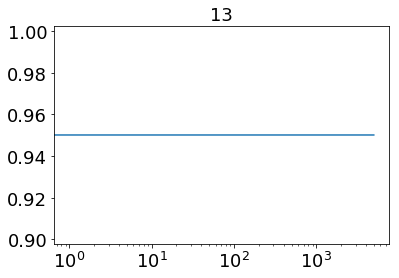

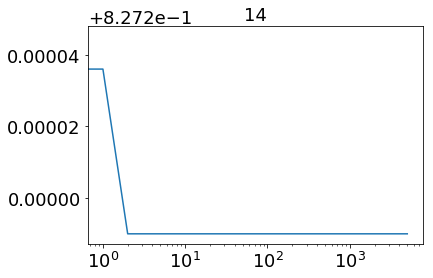

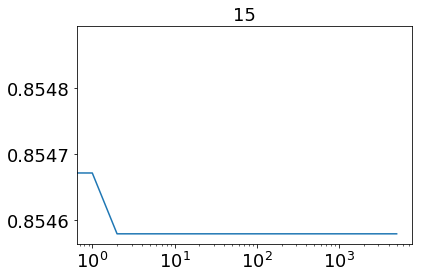

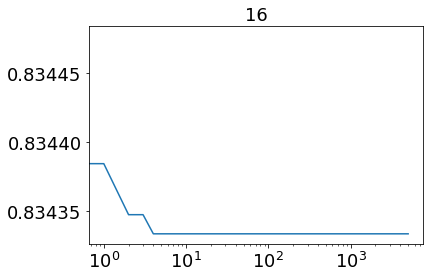

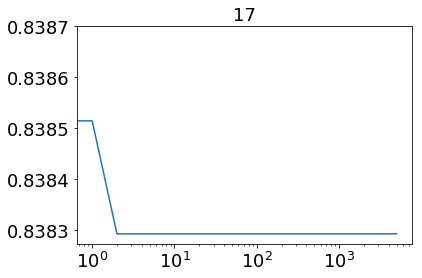

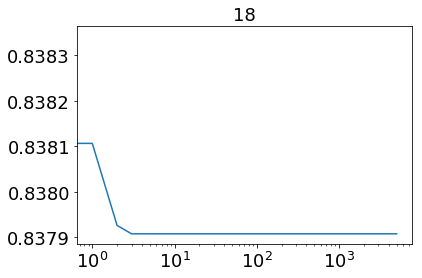

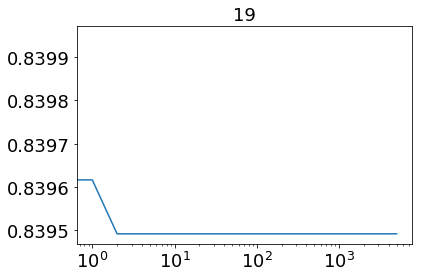

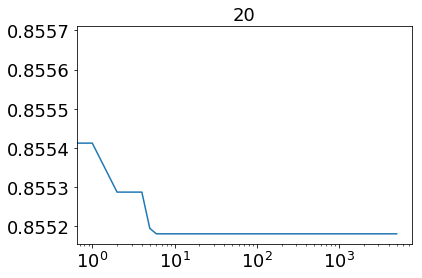

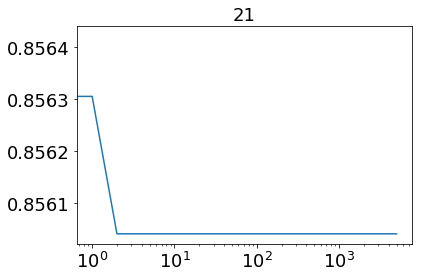

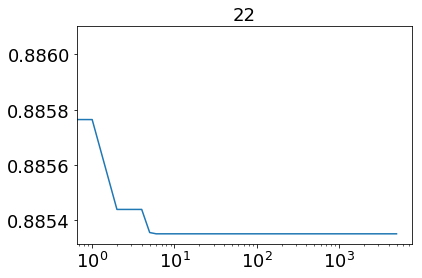

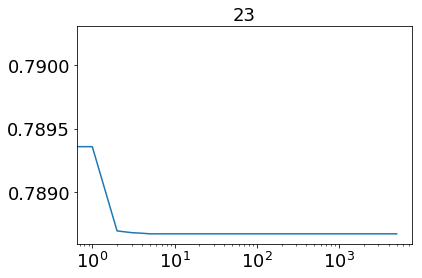

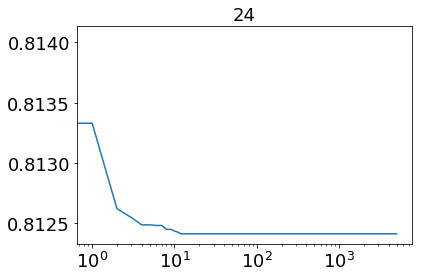

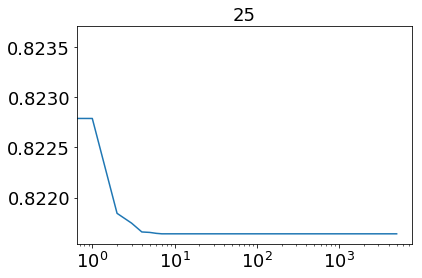

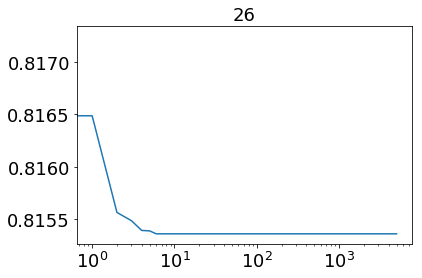

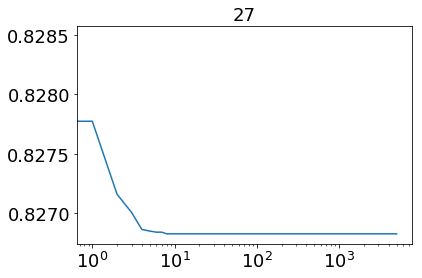

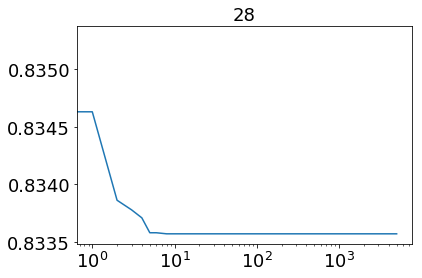

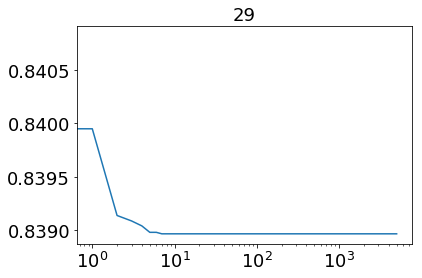

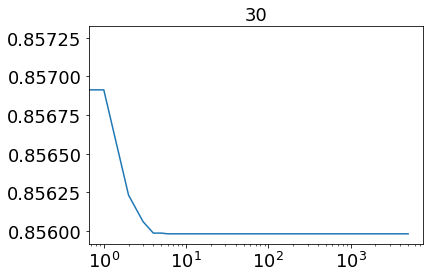

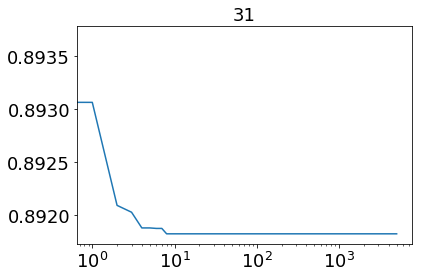

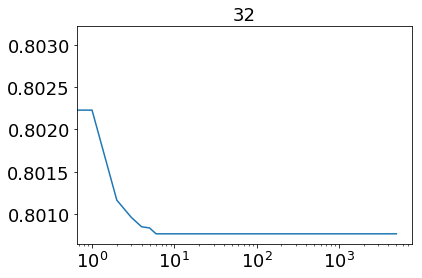

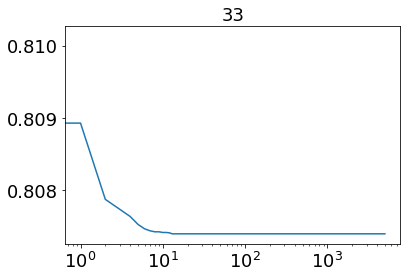

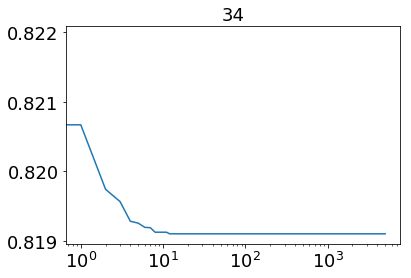

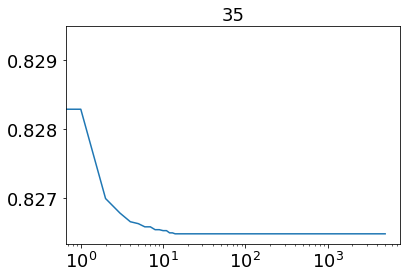

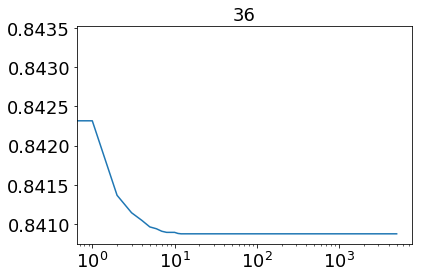

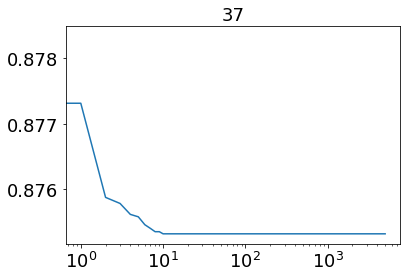

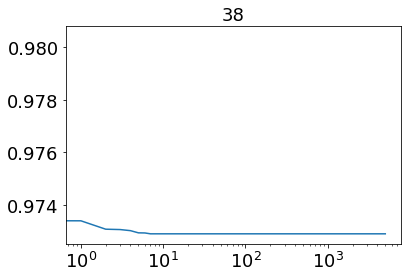

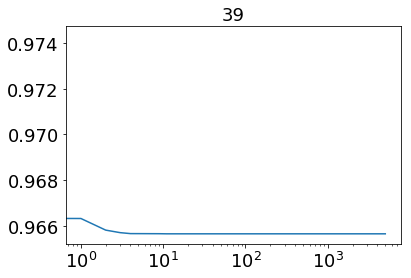

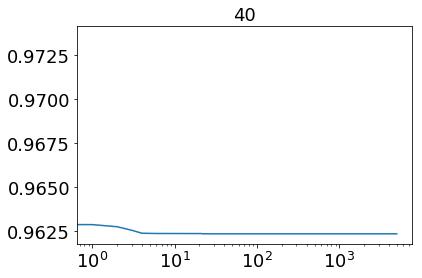

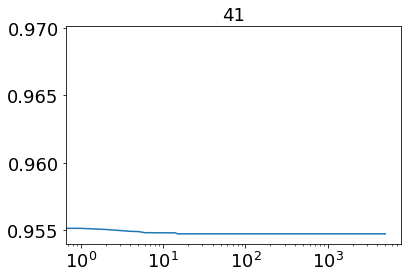

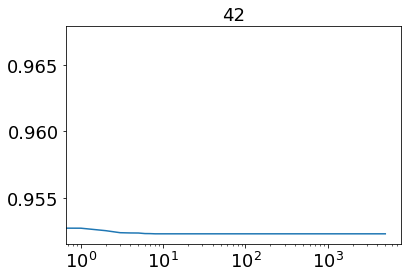

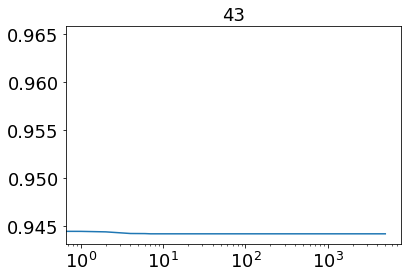

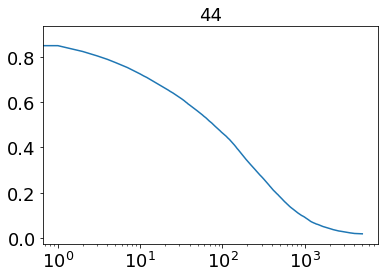

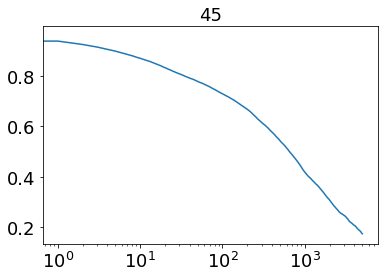

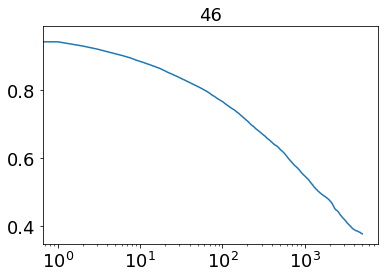

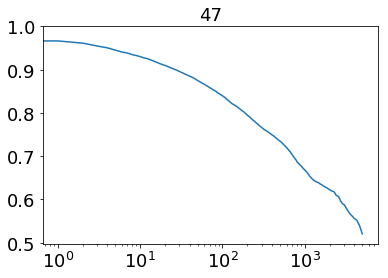

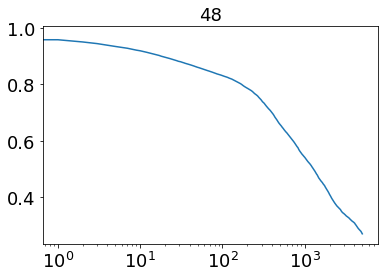

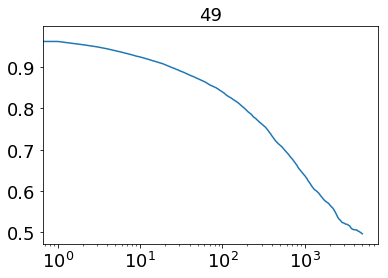

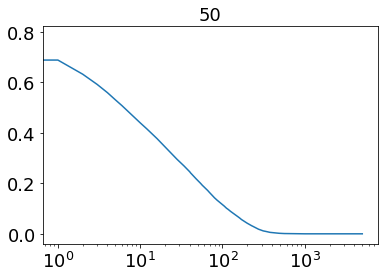

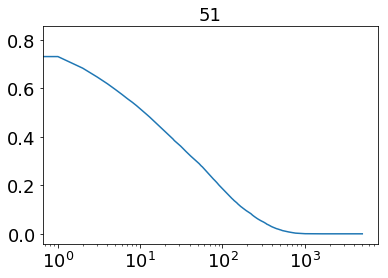

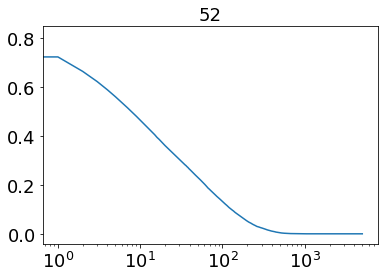

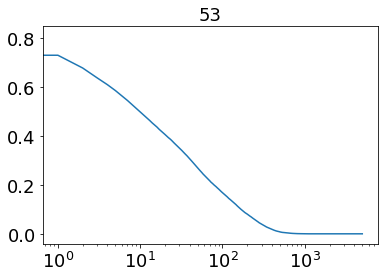

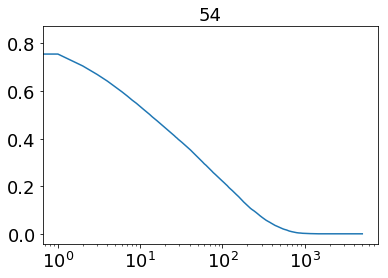

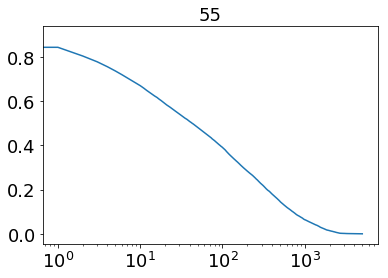

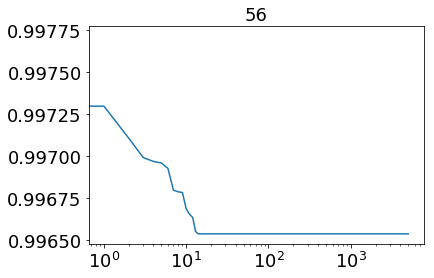

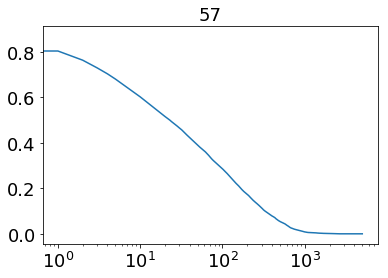

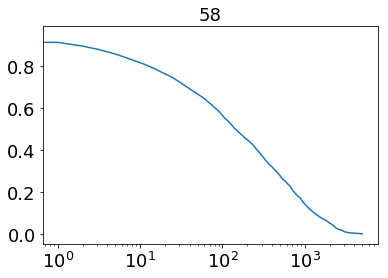

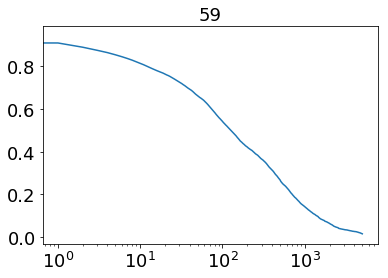

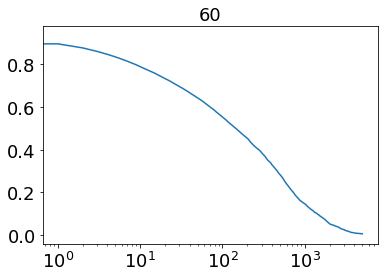

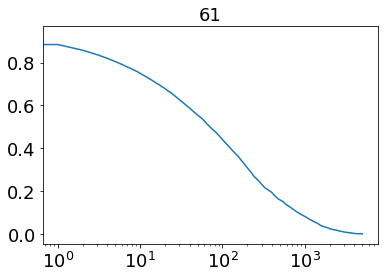

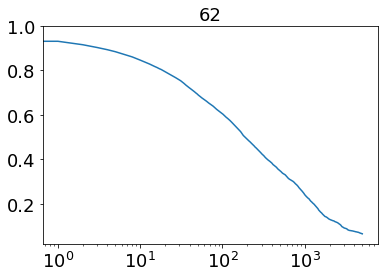

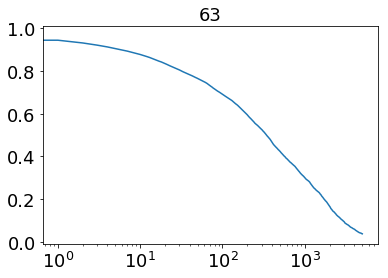

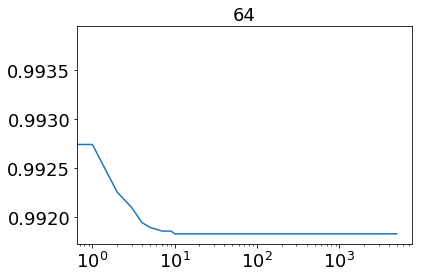

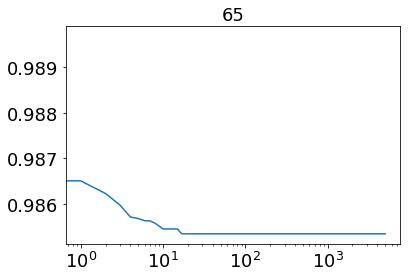

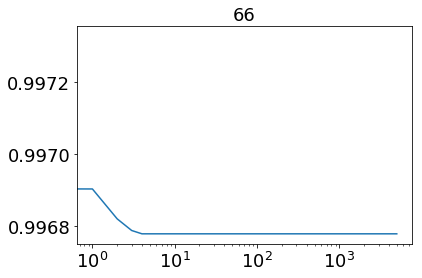

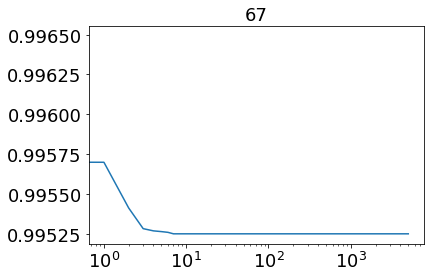

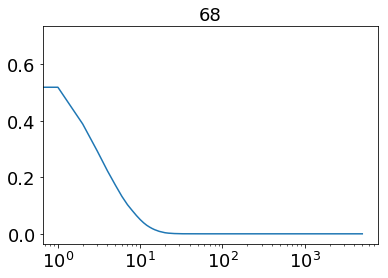

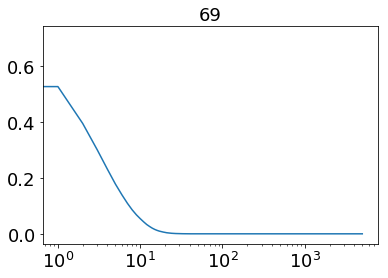

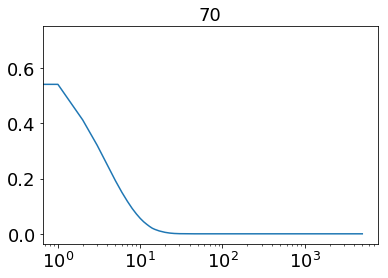

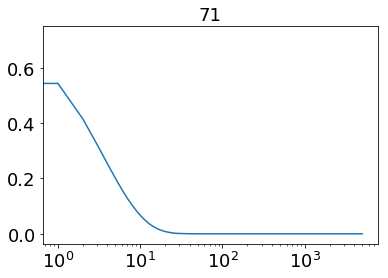

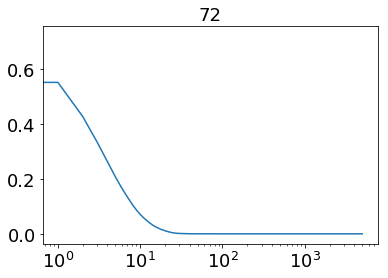

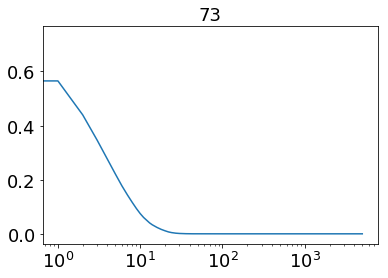

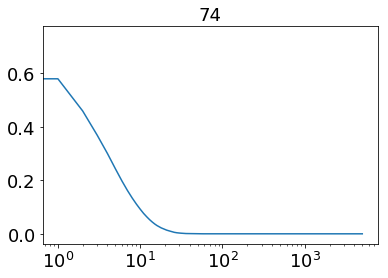

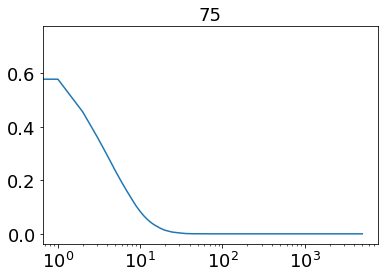

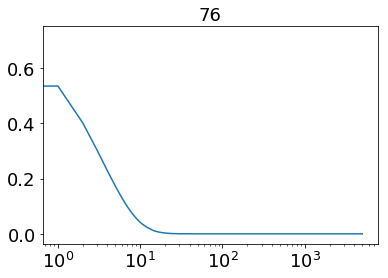

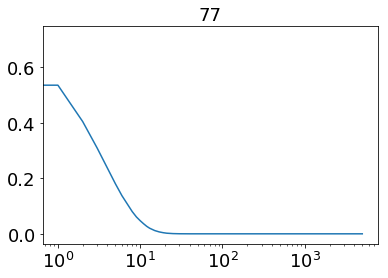

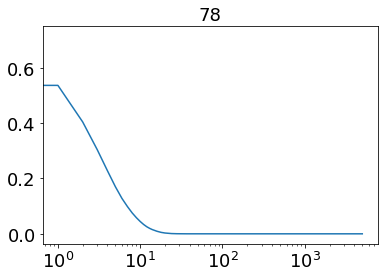

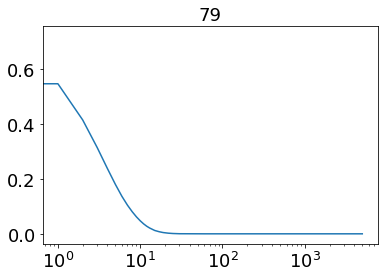

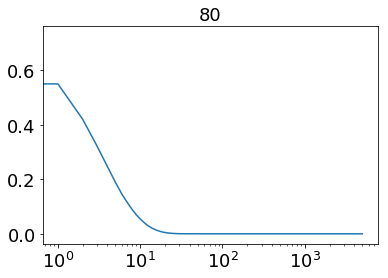

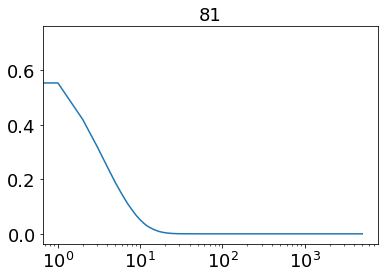

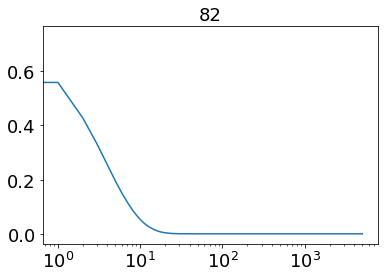

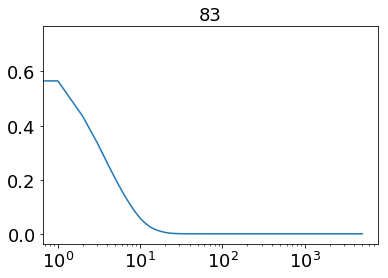

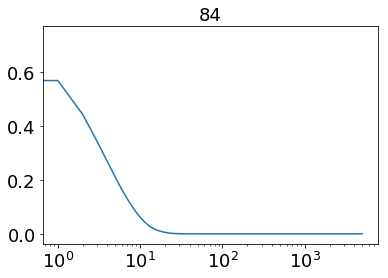

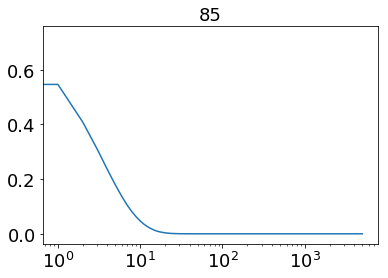

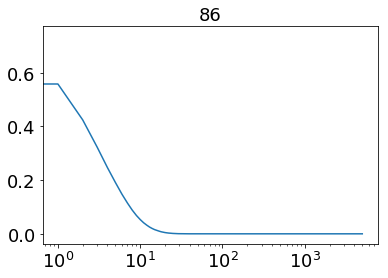

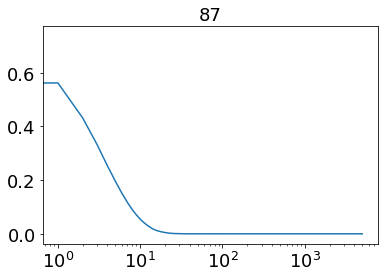

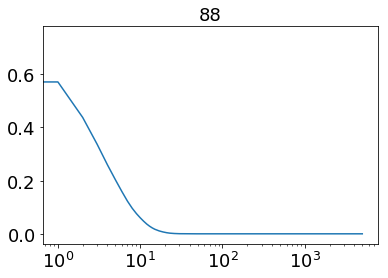

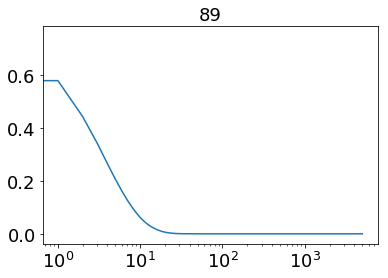

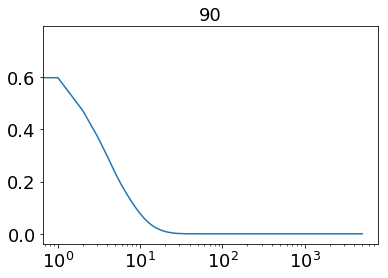

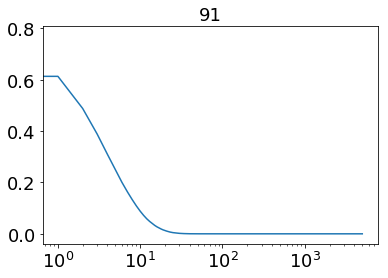

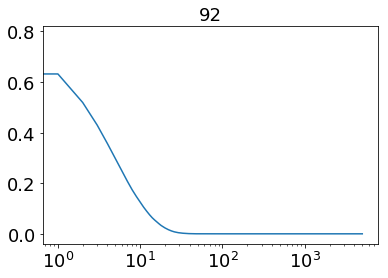

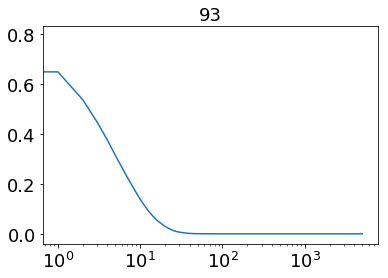

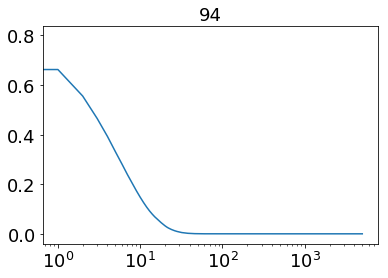

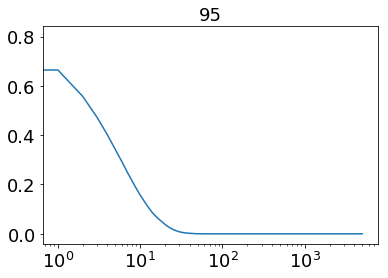

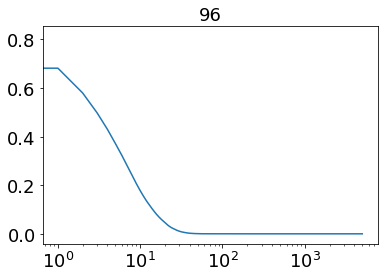

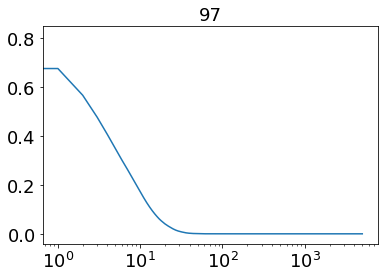

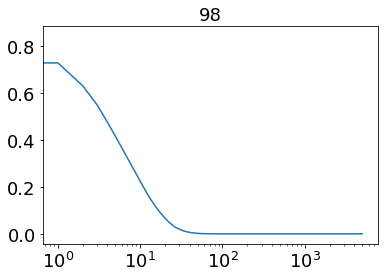

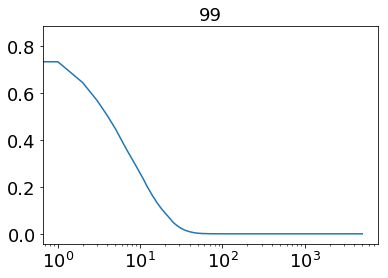

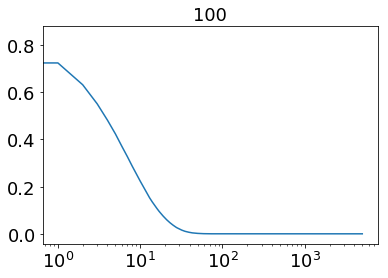

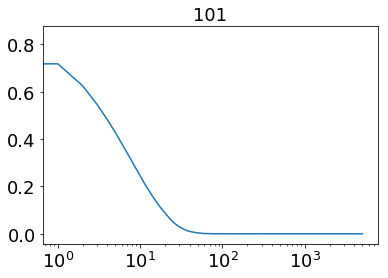

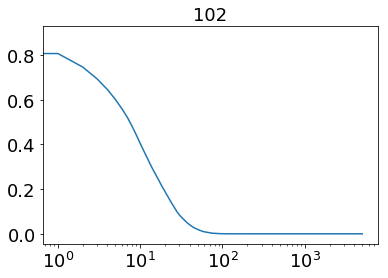

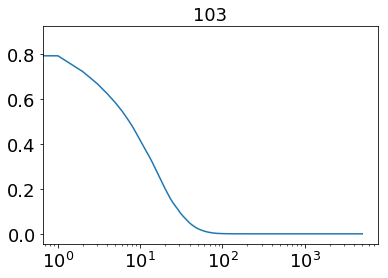

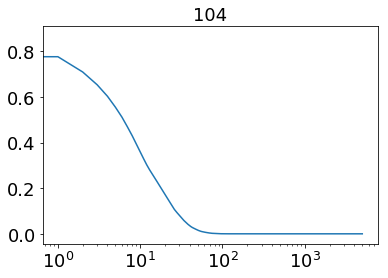

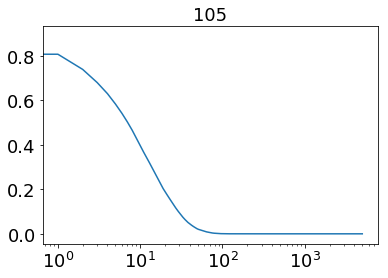

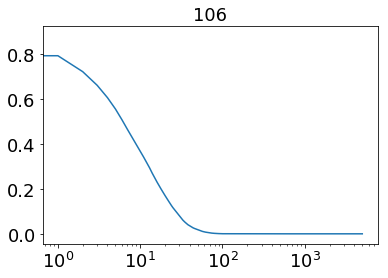

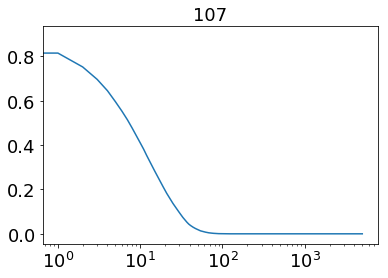

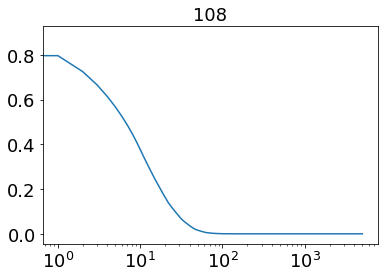

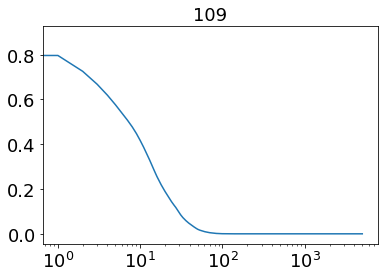

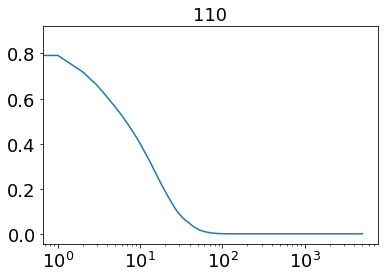

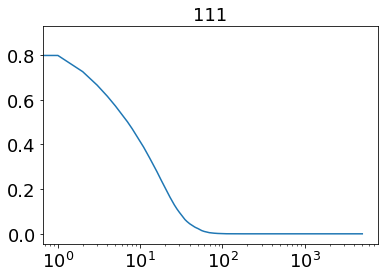

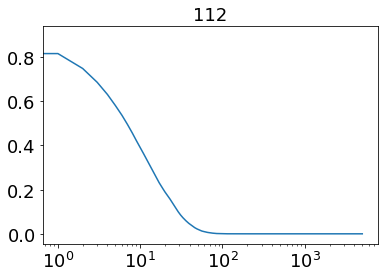

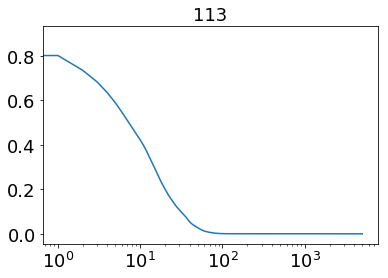

In [29]:
persistence = np.zeros((len(B)))
dir_name = 'results\\PERSISTENCE_AFTER_BURN\\'
for i in range(len(B)):
    p = np.load(dir_name + str(i) + '_' + '0.npy')
    plt.plot(range(len(p)), p)
    plt.xscale('log')
    plt.title(str(i))
    plt.show()
    persistence[i] = p[-1]

In [30]:
persistence.shape

(114,)

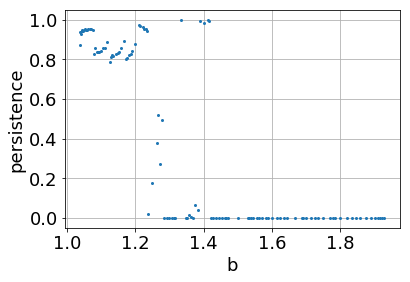

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('persistence')
ax.plot(B, persistence, 'o', markersize = 2)
plt.grid(True)
plt.show()

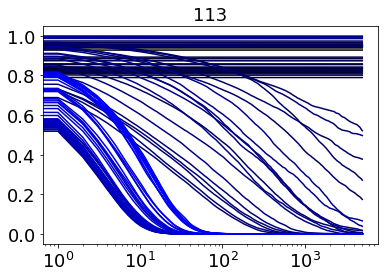

In [8]:
dir_name = 'results\\PERSISTENCE_AFTER_BURN\\'
for i in range(len(B)):
    p = np.load(dir_name + str(i) + '_' + '0.npy')
    plt.plot(range(len(p)), p, color = (0, 0, i / len(B)))
    plt.xscale('log')
    plt.title(str(i))
plt.show()

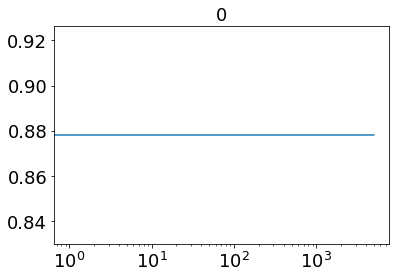

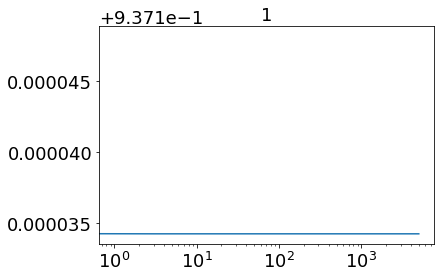

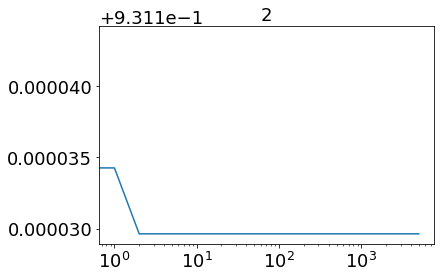

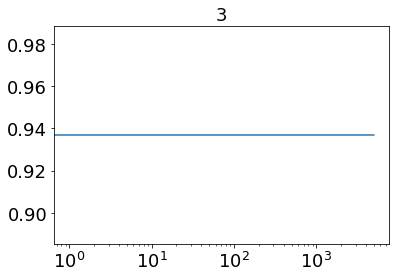

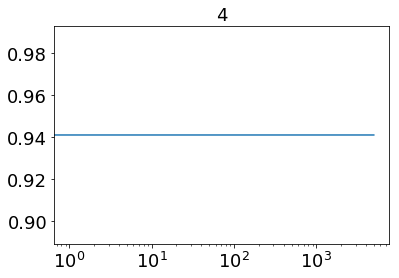

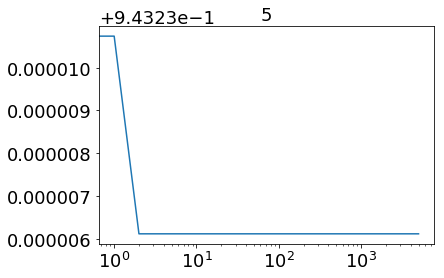

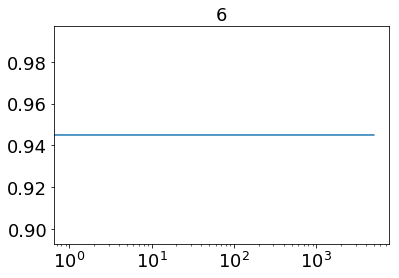

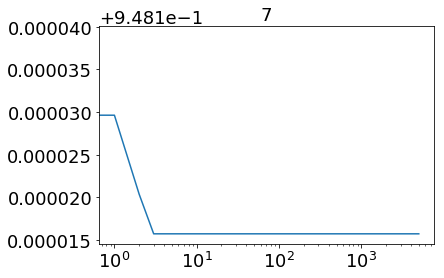

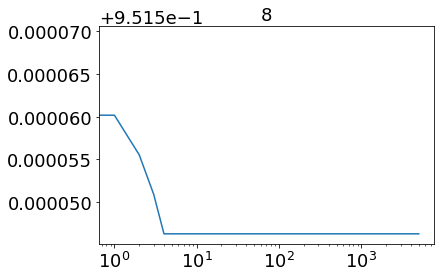

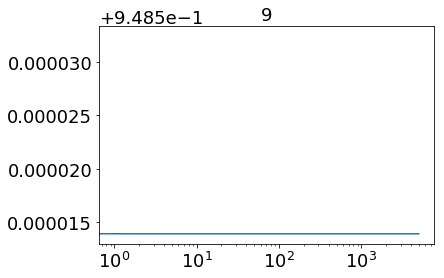

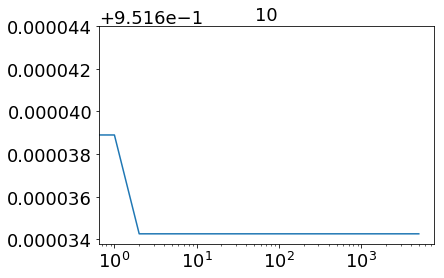

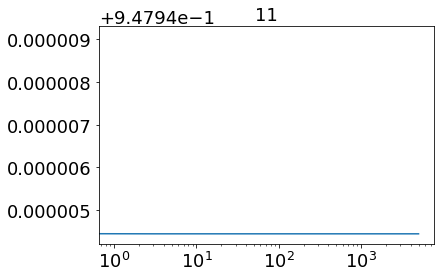

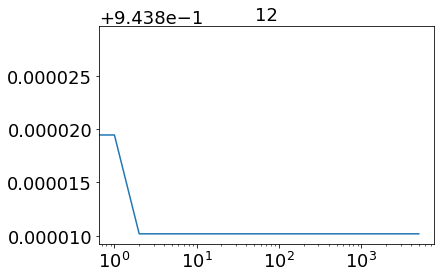

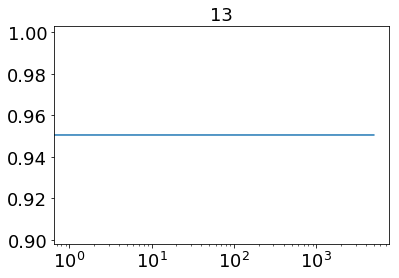

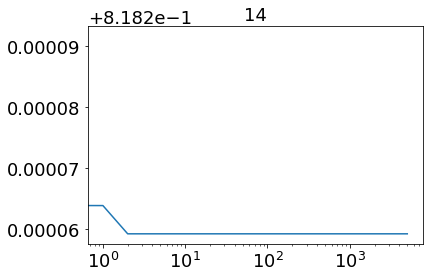

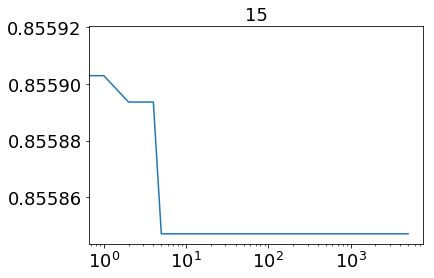

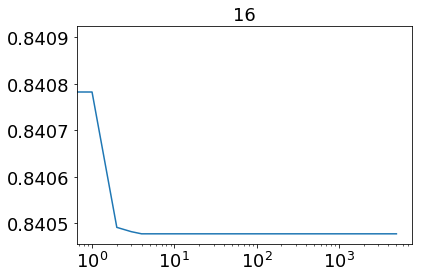

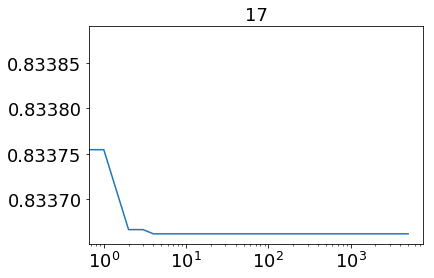

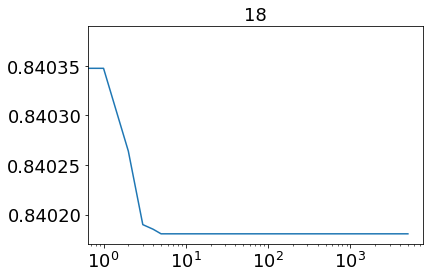

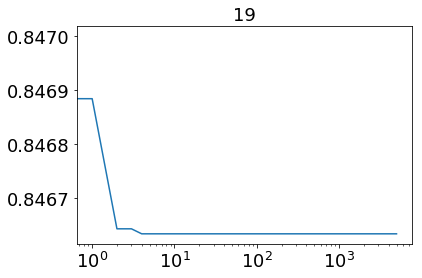

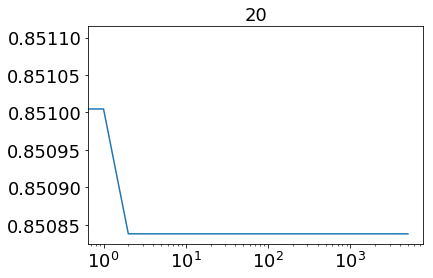

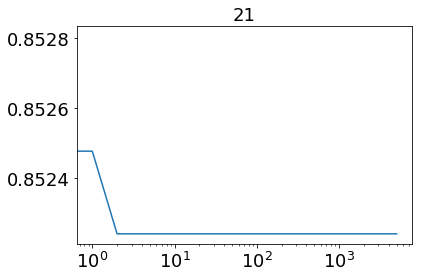

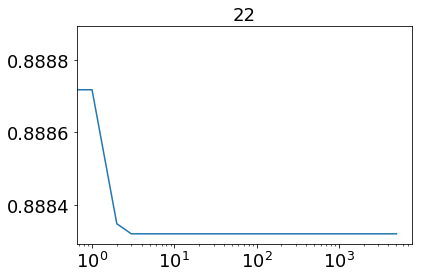

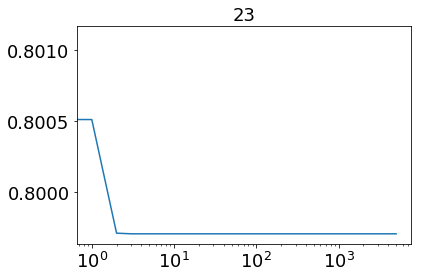

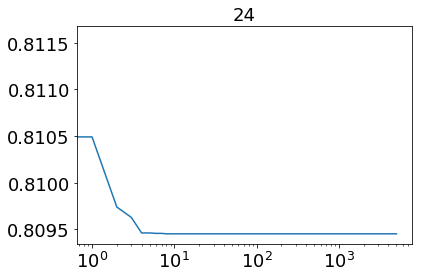

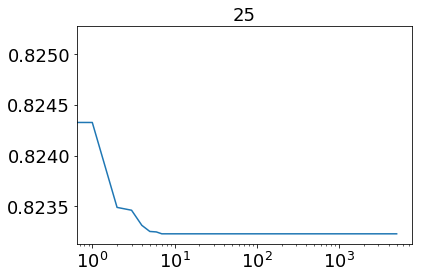

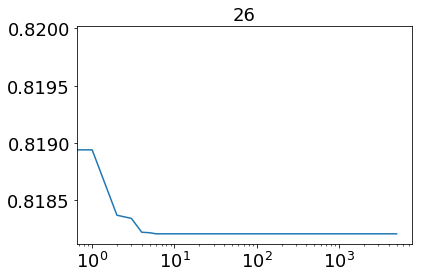

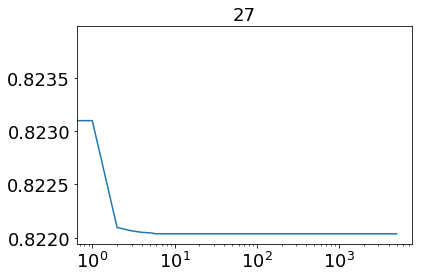

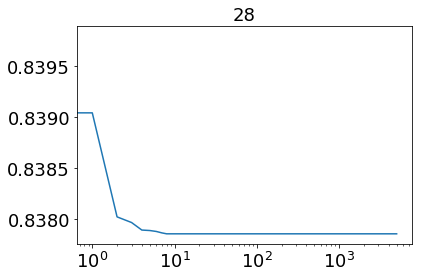

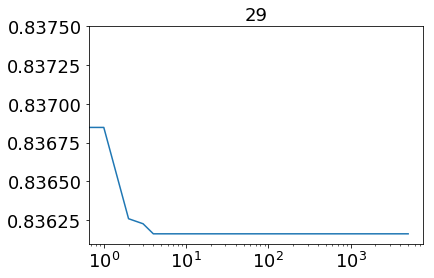

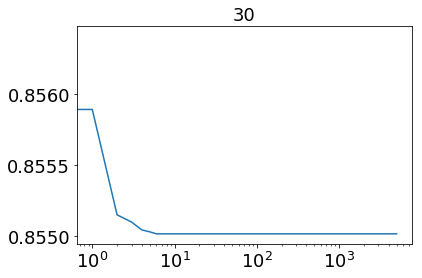

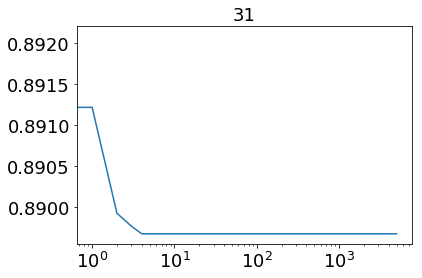

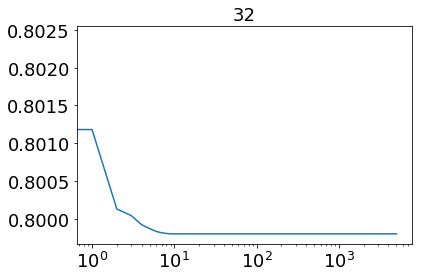

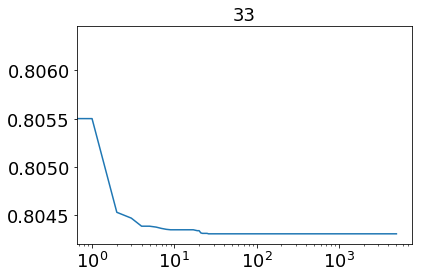

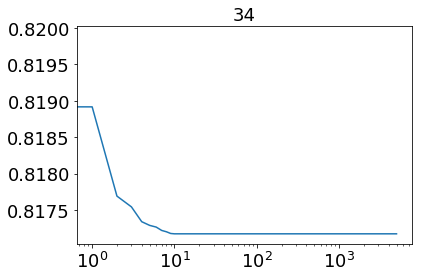

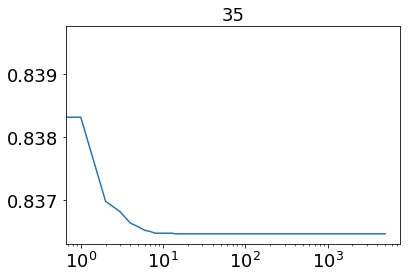

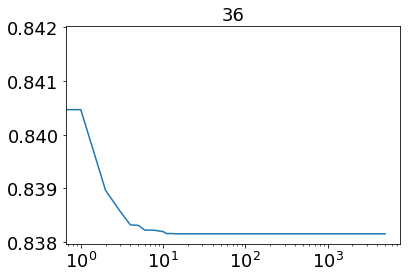

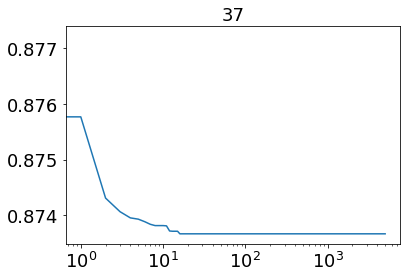

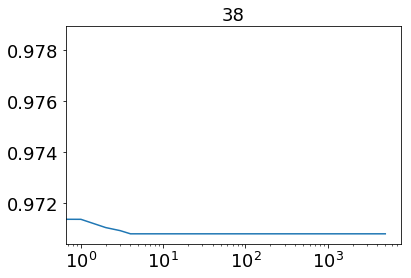

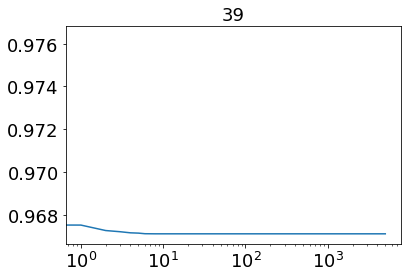

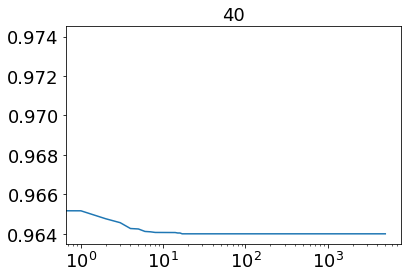

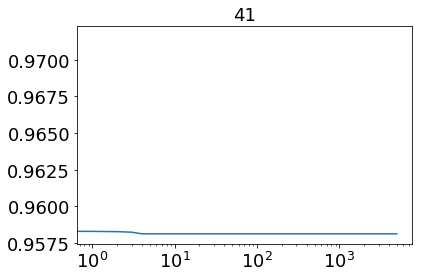

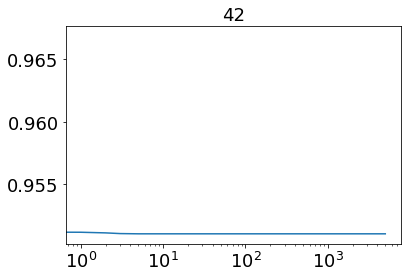

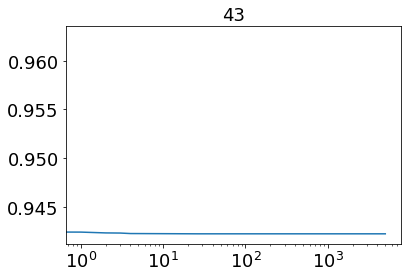

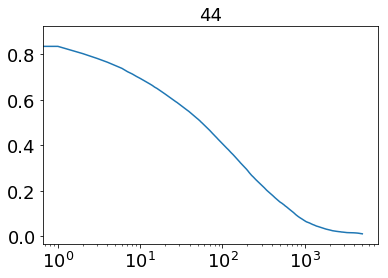

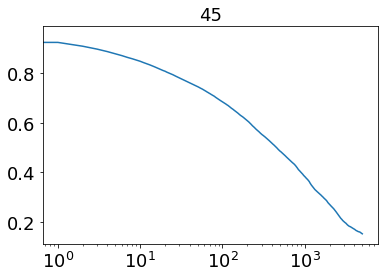

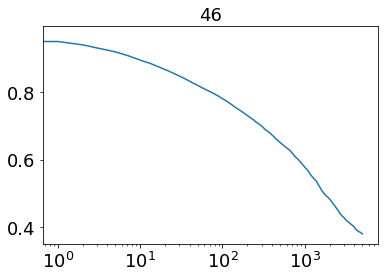

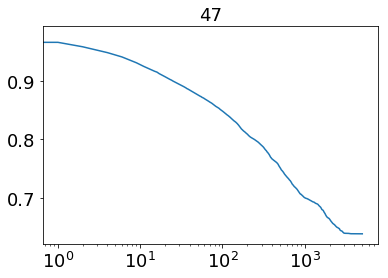

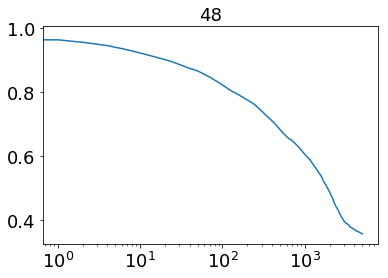

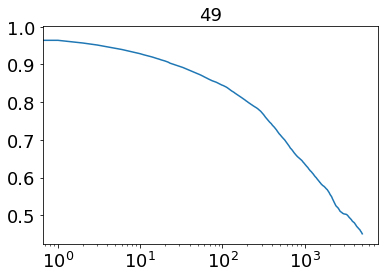

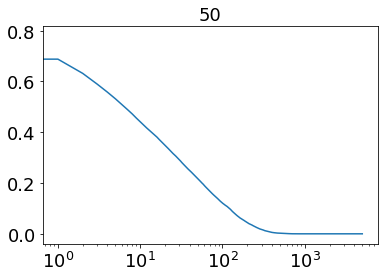

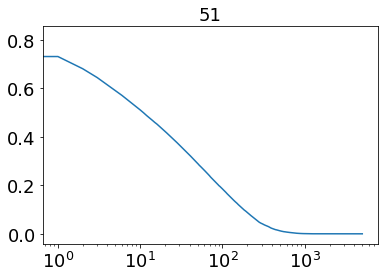

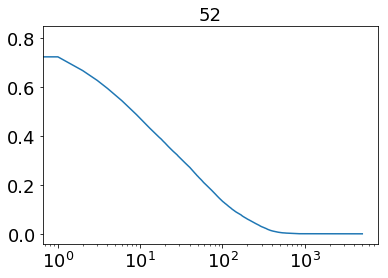

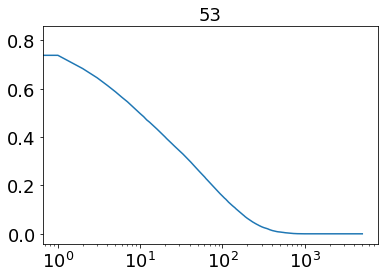

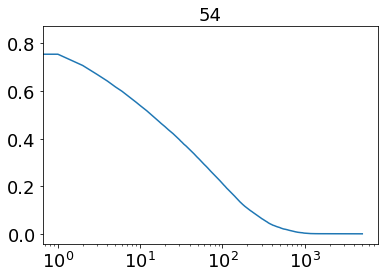

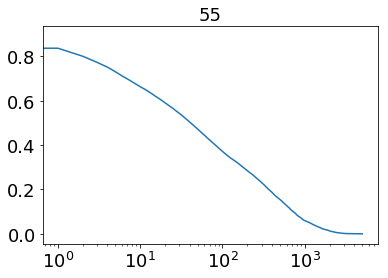

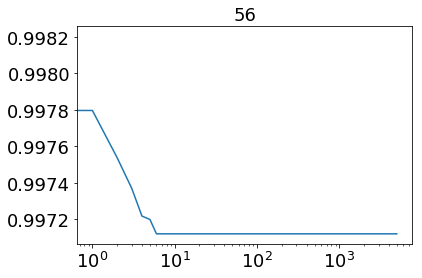

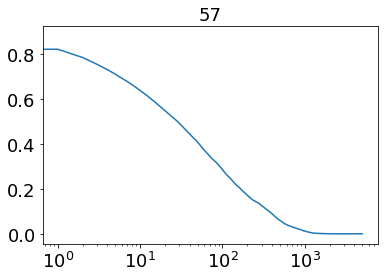

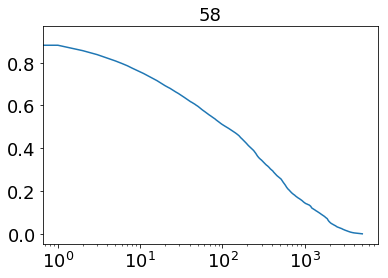

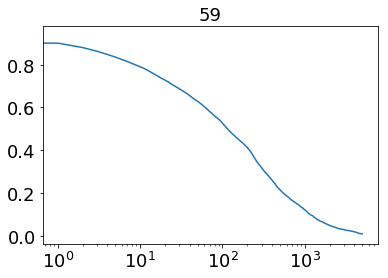

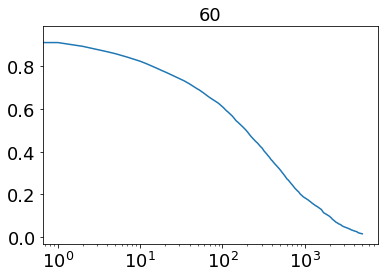

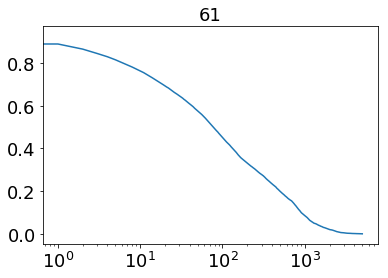

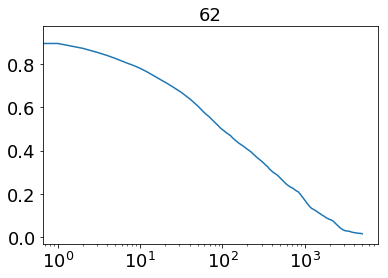

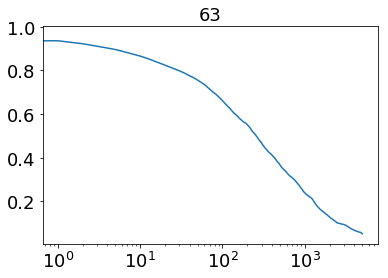

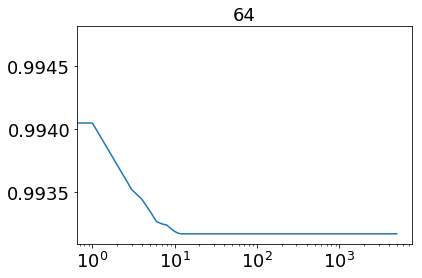

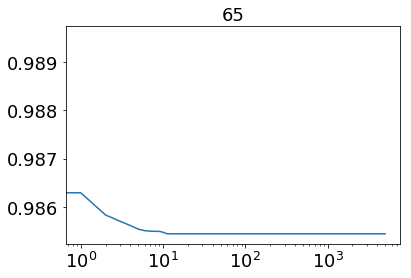

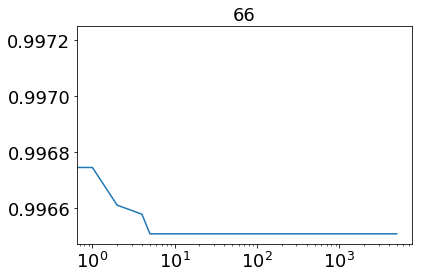

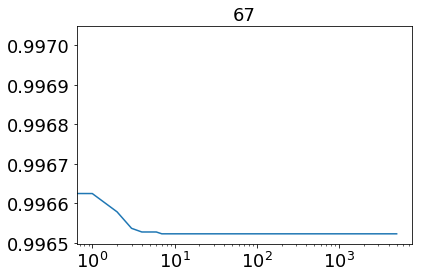

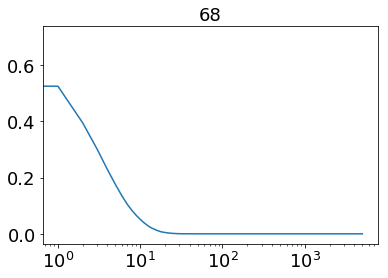

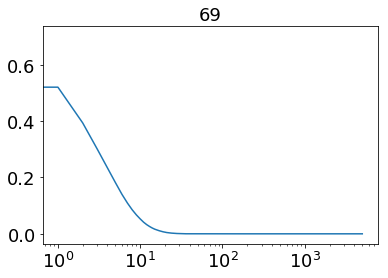

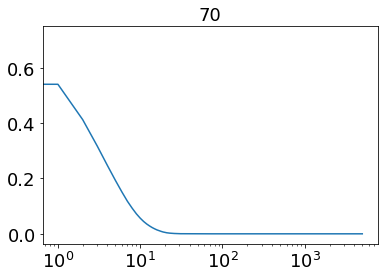

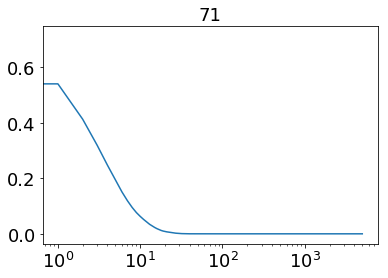

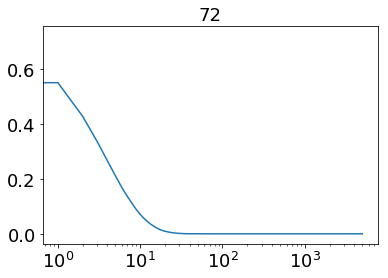

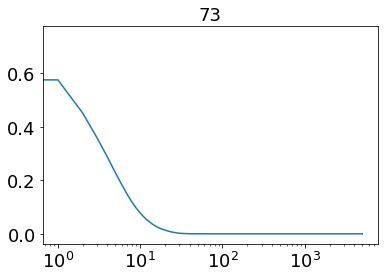

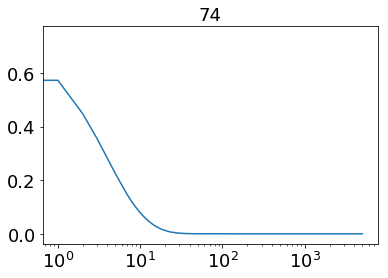

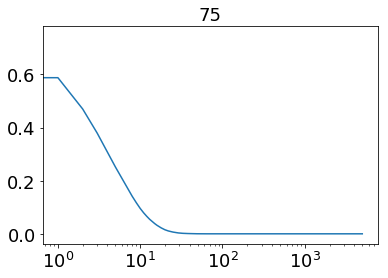

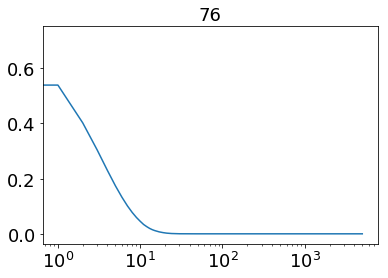

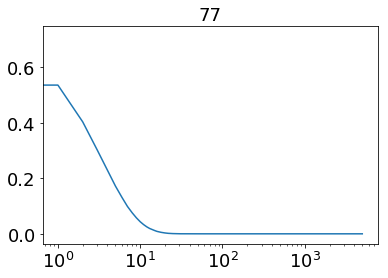

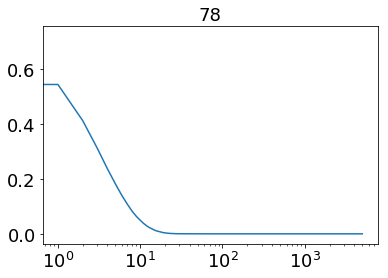

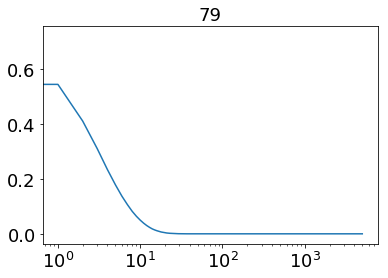

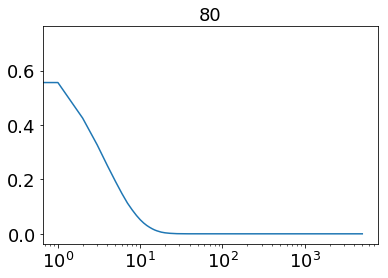

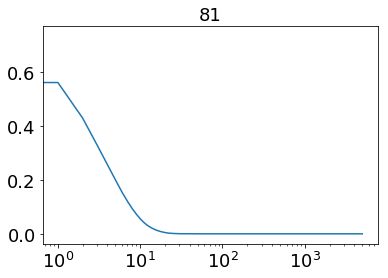

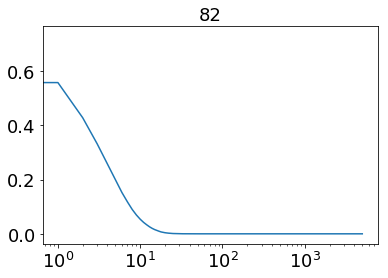

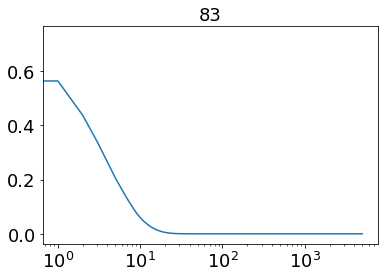

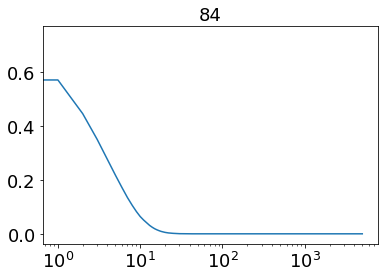

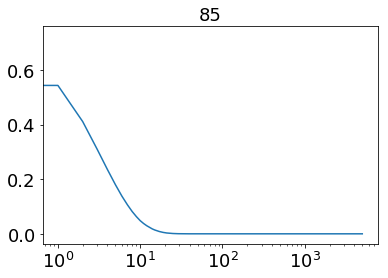

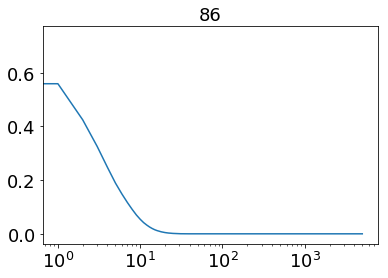

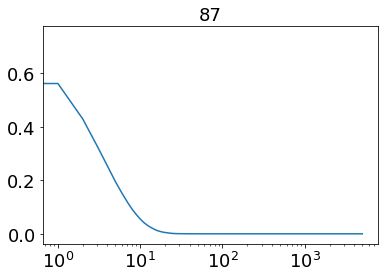

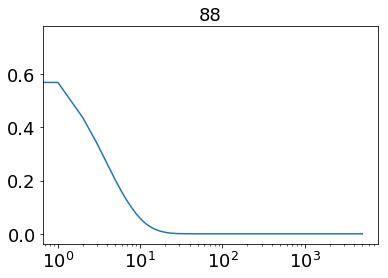

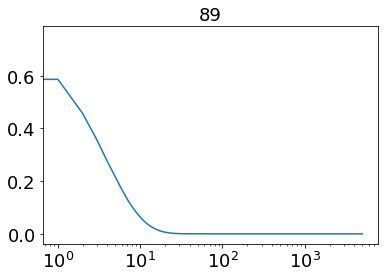

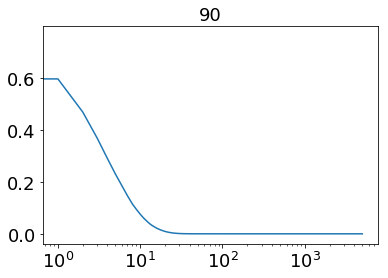

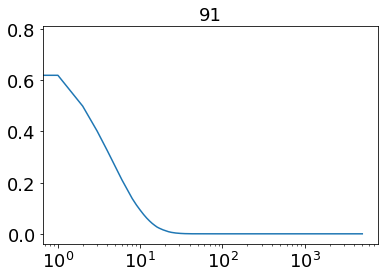

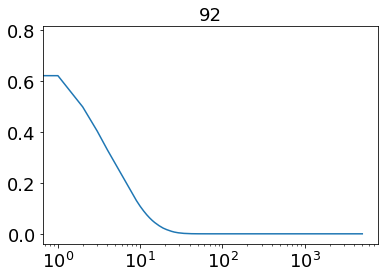

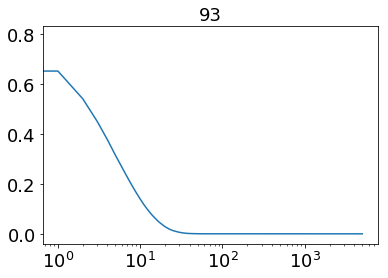

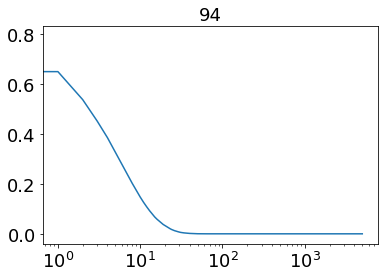

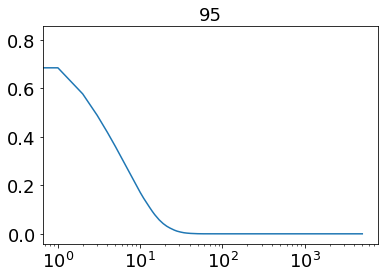

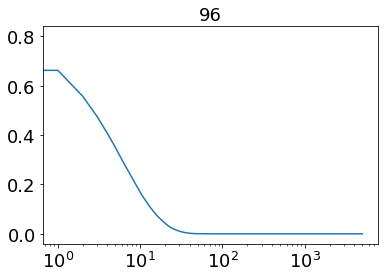

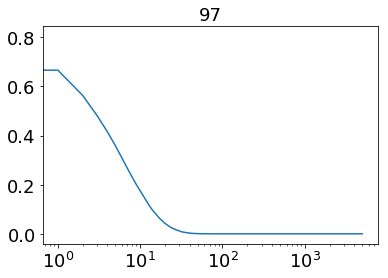

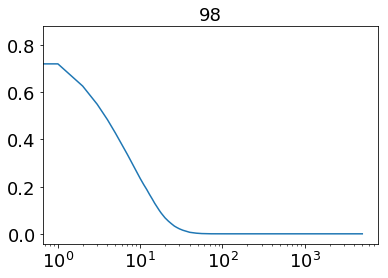

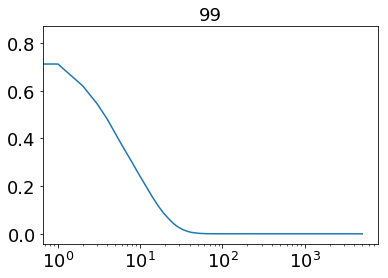

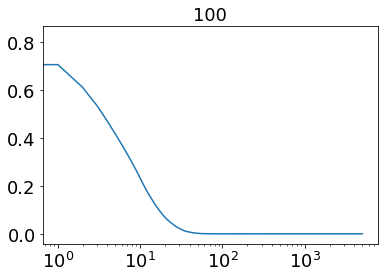

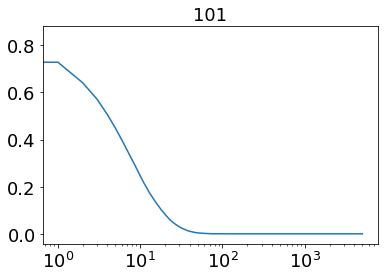

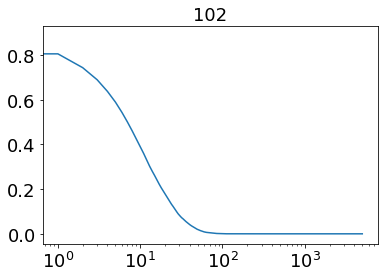

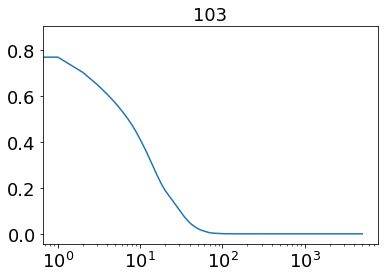

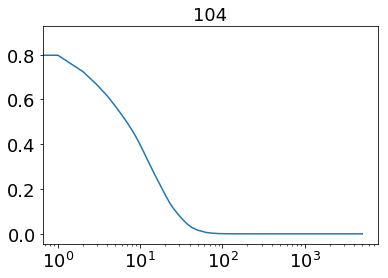

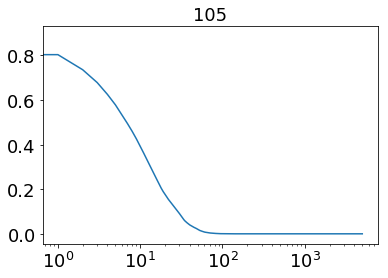

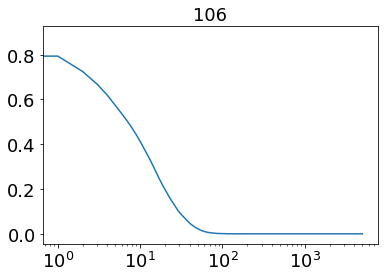

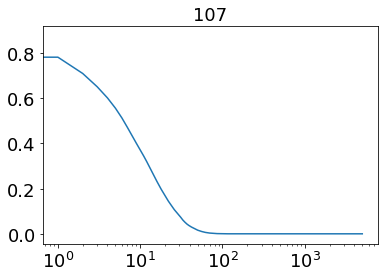

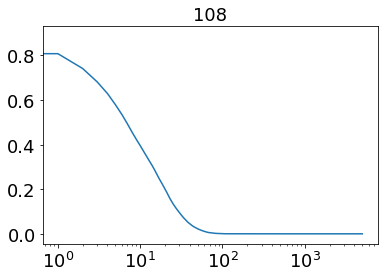

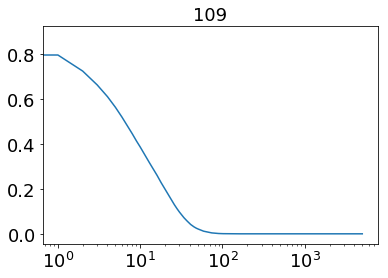

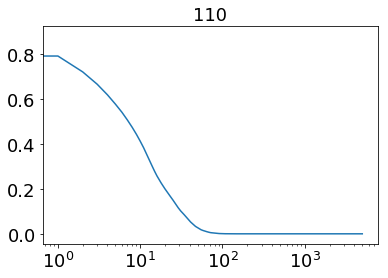

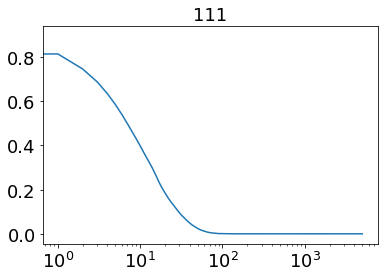

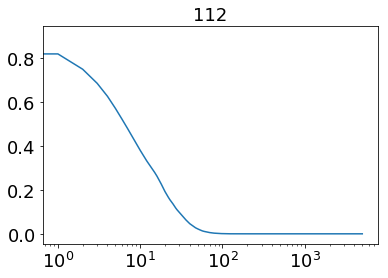

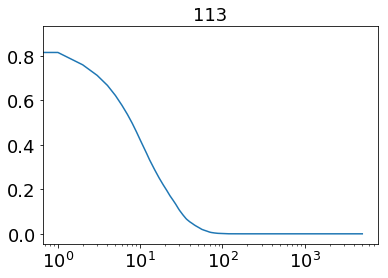

In [7]:
dir_name = 'results\\PERSISTENCE_AFTER_BURN_2\\'
for i in range(len(B)):
    p = np.load(dir_name + str(i) + '_' + '0.npy')
    plt.plot(range(len(p)), p)
    plt.xscale('log')
    plt.title(str(i))
    plt.show()

Странные значения b № : 56, [64, 67], [64, 67]

# Field size 100 
проверка зависсимости плотности от размеров поля

замеры на поле 100х100х1000

In [16]:
dir_name = "results\FIELD_SIZE100\\"
Fc = np.zeros((len(B), 100), dtype=float)
N_FIELDS = 10
for i in range(0, len(B), 10):
    for j in range(N_FIELDS):
        
        fname = dir_name + str(i) + '_' + str(j) + '.npy'
        f = np.load(fname)
        Fc[i] += f
    Fc[i] = Fc[i] / N_FIELDS

# plt.show()

In [17]:
Fc_100 = np.zeros(len(B), dtype=float)
for i in range(len(B)):
    Fc_100[i] = (Fc[i].sum() / len(Fc[i]))

In [18]:
B_100 = [B[i] for i in range(0, len(B), 10)]

<IPython.core.display.Javascript object>


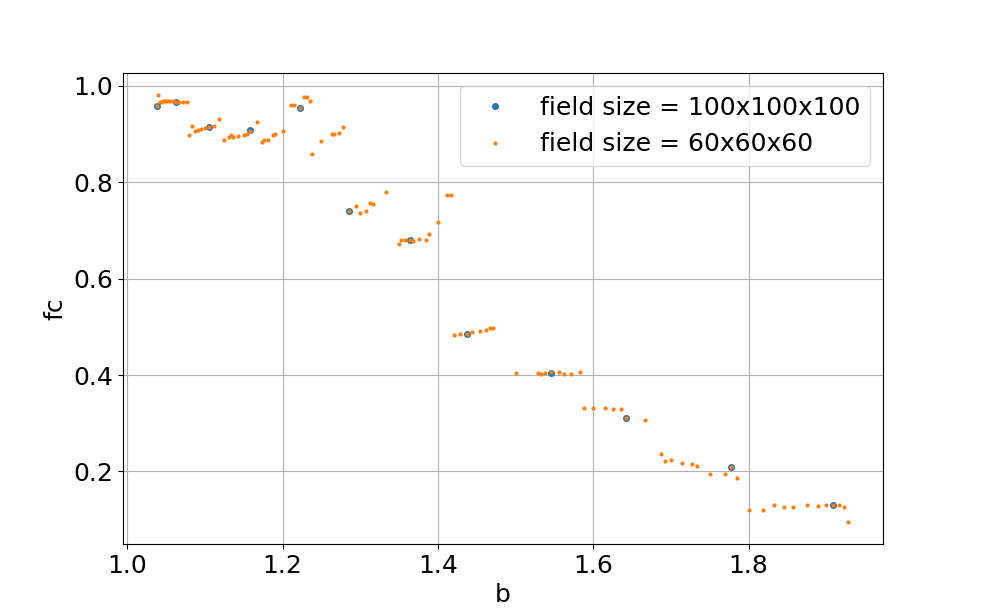

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B_100, [Fc_100[i] for i in range(0, len(B), 10)], 'o', markersize = 4, label = "field size = 100x100x100")
ax.plot(B, Fc_mean, 'o', markersize = 2, label = "field size = 60x60x60")
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

In [34]:
for i in range(0, len(B), 10):
    print(Fc_mean[i] - Fc_100[i])

-2.2870370369965087e-05
-0.0001959830370371618
-0.0002791791851848302
-0.0008579749259258751
-0.0008732650740740366
-0.00020522022222235758
-8.693970370399207e-05
0.00012576251851847964
0.000273263888888875
-4.792588888880012e-05
-5.35691481481082e-05
4.099481481500966e-06


<IPython.core.display.Javascript object>


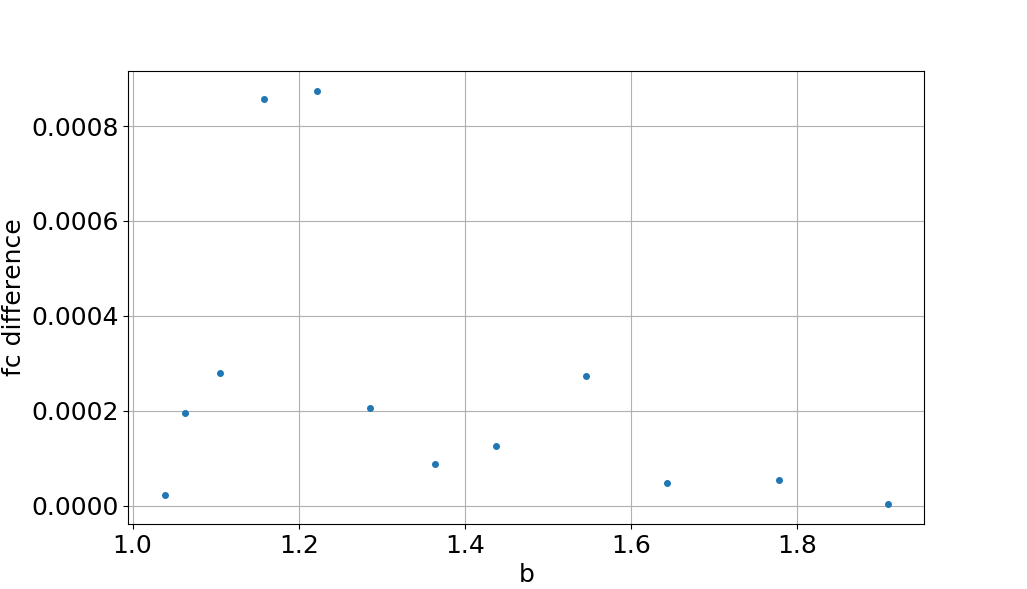

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc difference')
ax.plot(B_100, [abs(Fc_mean[i] - Fc_100[i]) for i in range(0, len(B), 10)], 'o', markersize = 4)

plt.grid(True)
plt.show()

In [34]:
B[44]

1.2380952381952381

In [48]:
SIZE = 60
L = (SIZE, SIZE, SIZE)
neighbors = tabulate_neighbors(L)
rndm = np.random.RandomState(12345)

In [50]:
b = 1.4
field = (rndm.uniform(size=L) > 0.9).astype('int16')

<IPython.core.display.Javascript object>


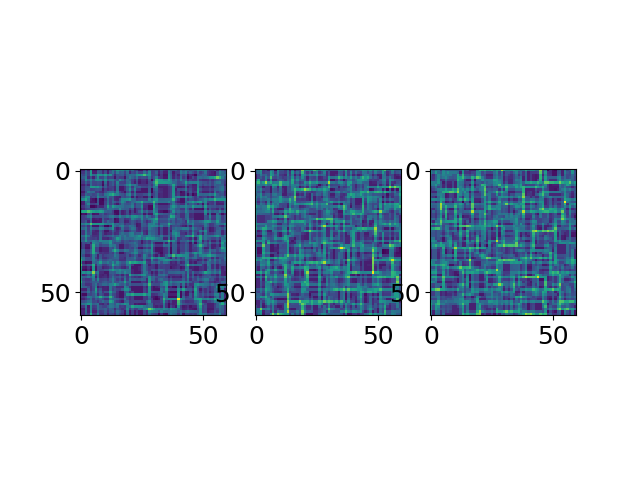

In [81]:
field = evolve3D_2_C(field, neighbors, b, num_steps = 1)
show_grid(field)

In [67]:
(abs(old - field).sum())/ 60**3

0.004657407407407407

In [60]:
old = field.copy()

In [59]:
1 - field.sum() / 60**3

0.7011712962962964

# Svitch time

In [11]:
B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 2:
            B.add(i/j + B_INC)
B = sorted(list(B))
len(B)

114

In [9]:
SIZE = 60
L = (SIZE, SIZE, SIZE)
neighbors = tabulate_neighbors(L)

In [10]:
rndm = np.random.RandomState(25)
C_PROB = 0.9 # test 0.1, 0.5, 0.9
N_MEASUR = 1000
BURN_IN_STEPS = 2500

results = np.zeros((len(B), 2)) # Количество сменивших стратегию, среднее время

for i in range(len(B)):
    b = B[i]
    switches = np.zeros(L, dtype=int)
    field = (rndm.uniform(size=L) > C_PROB).astype('int16')
    field = evolve3D_2_C(field, neighbors, b, num_steps=BURN_IN_STEPS)
    for measure in range(N_MEASUR):
        old_field = field.copy()
        field = evolve3D_2_C(field, neighbors, b, num_steps=1)
        switches = switches + abs(old_field - field)
    results[i, 0]= switches.nonzero()[0].size
    results[i, 1] = np.mean(N_MEASUR / (switches + 1))
np.save('Switch_times.npy', results) 


[[3.02380000e+04 8.80044342e+00]
 [2.46760000e+04 9.13421203e+00]
 [3.02400000e+04 8.99198635e+00]
 [3.15200000e+04 8.97383948e+00]
 [3.23890000e+04 8.94468555e+00]
 [3.31940000e+04 8.94207962e+00]
 [3.43850000e+04 8.90668926e+00]
 [3.56270000e+04 8.86772087e+00]
 [3.55700000e+04 8.87165772e+00]
 [3.61470000e+04 8.87523990e+00]
 [3.54230000e+04 8.91351728e+00]
 [3.61630000e+04 8.88116721e+00]
 [3.60710000e+04 8.89866258e+00]
 [3.78890000e+04 8.83733881e+00]
 [8.04820000e+04 7.34854350e+00]
 [9.11970000e+04 7.20308878e+00]
 [9.80870000e+04 6.95023884e+00]
 [1.00112000e+05 6.87195804e+00]
 [1.01097000e+05 6.83904102e+00]
 [1.02234000e+05 6.84890666e+00]
 [1.06696000e+05 6.71556164e+00]
 [1.07545000e+05 6.69624868e+00]
 [1.08324000e+05 6.70250308e+00]
 [1.52918000e+05 5.33736666e+00]
 [1.63794000e+05 5.18824603e+00]
 [1.62554000e+05 5.21902915e+00]
 [1.64823000e+05 5.14938656e+00]
 [1.64095000e+05 5.23848276e+00]
 [1.64191000e+05 5.20849921e+00]
 [1.67651000e+05 5.12734001e+00]
 [1.652450

In [13]:
results[:, 0]

array([ 30238.,  24676.,  30240.,  31520.,  32389.,  33194.,  34385.,
        35627.,  35570.,  36147.,  35423.,  36163.,  36071.,  37889.,
        80482.,  91197.,  98087., 100112., 101097., 102234., 106696.,
       107545., 108324., 152918., 163794., 162554., 164823., 164095.,
       164191., 167651., 165245., 167002., 191610., 192323., 192605.,
       192737., 191691., 192107., 193332., 194154., 194942., 199811.,
       198480., 199408., 199260., 200446., 198452., 197995., 199420.,
       199654., 199721., 199851., 200835., 200660., 199414., 200442.,
       197758., 196933., 197977., 197747., 196834., 196535., 197522.,
       196451., 195187., 195587., 194283., 193524., 196269., 196416.,
       195639., 197266., 194863., 193387., 195393., 192511., 184151.,
       184776., 182375., 178275., 174400., 185233., 165961., 165339.,
       173269., 168797., 153301., 147991., 150306., 134505., 139039.,
       104452.,  99940.,  79713.,  94025.,  64542.,  69192.,  72210.,
        59903.,  330

In [13]:
switch_time = np.load("Switch_times_1.npy")
time_1 = switch_time.copy()

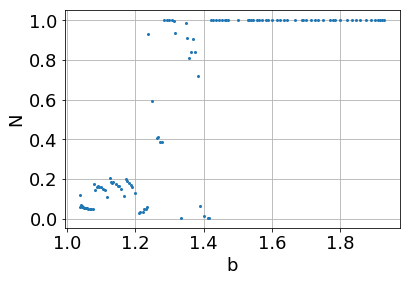

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('N')
ax.plot(B, switch_time[:, 0] / 100**3, 'o', markersize = 2)
plt.grid(True)
plt.show()

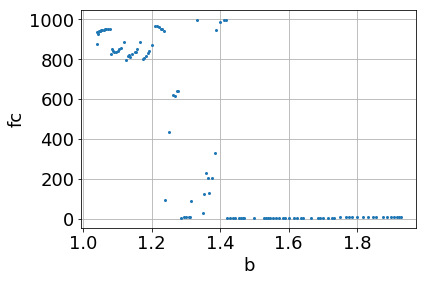

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, switch_time[:, 1], 'o', markersize = 2)
plt.grid(True)
plt.show()

In [16]:
switch_time = np.load("Switch_times_2.npy")
time_2 = switch_time.copy()

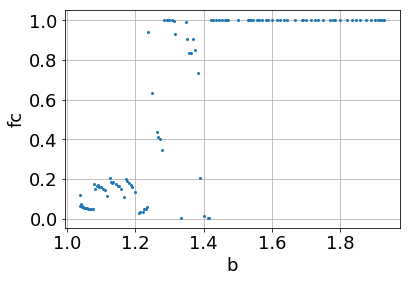

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, switch_time[:, 0] / 100**3, 'o', markersize = 2)
plt.grid(True)
plt.show()

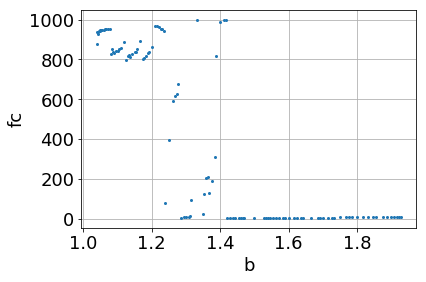

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, switch_time[:, 1], 'o', markersize = 2)
plt.grid(True)
plt.show()

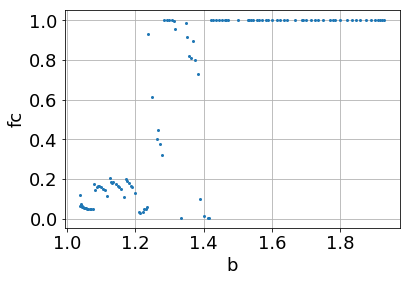

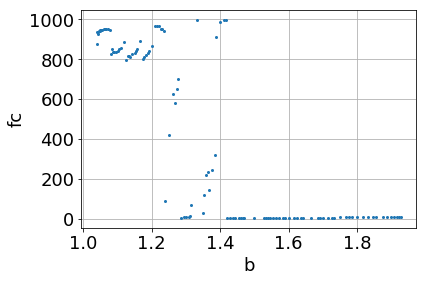

In [19]:
switch_time = np.load("Switch_times_3.npy")
time_3 = switch_time.copy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, switch_time[:, 0] / 100**3, 'o', markersize = 2)
plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, switch_time[:, 1], 'o', markersize = 2)
plt.grid(True)
plt.show()

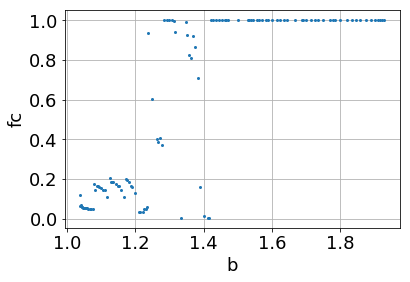

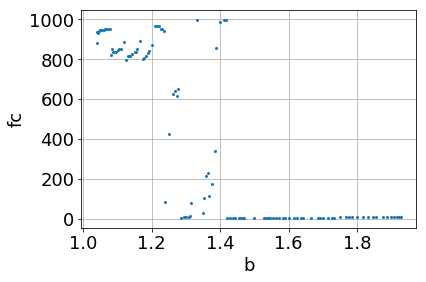

In [20]:
switch_time = np.load("Switch_times_4.npy")
time_4 = switch_time.copy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, switch_time[:, 0] / 100**3, 'o', markersize = 2)
plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, switch_time[:, 1], 'o', markersize = 2)
plt.grid(True)
plt.show()

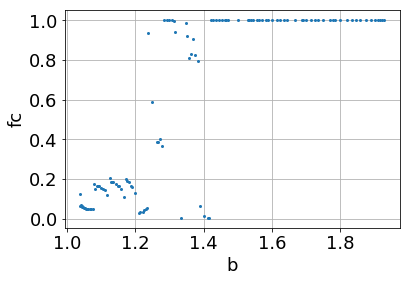

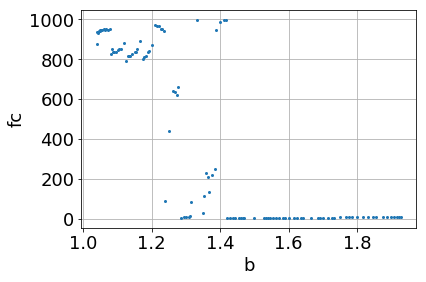

In [21]:
switch_time = np.load("Switch_times_5.npy")
time_5 = switch_time.copy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, switch_time[:, 0] / 100**3, 'o', markersize = 2)
plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('b')
ax.set_ylabel('fc')
ax.plot(B, switch_time[:, 1], 'o', markersize = 2)
plt.grid(True)
plt.show()

In [22]:
# проверка, что результаты не одинаковые
times = [time_1, time_2, time_3, time_4, time_5]

In [23]:
for i in range(5):
    for j in range(5):
        if(i == j):
            continue
        if((times[i] - times[j] == 0).min()):
            print("same")

Исследование трёх точек около 1.4
в этих точках количество агентов меняющих стратегию составляет около одного процента, хотя в соседних точках persistense уходит в 0

In [8]:
for i in range(len(B)):
    if B[i] == 1.4 + B_INC:
        print(i)

65


In [14]:
b1, b2, b3 = B[64:67]

print("b1:")
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 2:
            if(i/j + B_INC == b1):
                print(i, j)
                
print("b2:")
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 2:
            if(i/j + B_INC == b2):
                print(i, j)
                
print("b3:")
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i/j < 2:
            if(i/j + B_INC == b3):
                print(i, j)

b1:
25 18
b2:
7 5
14 10
21 15
b3:
24 17


In [24]:
SIZE = 60
L = (SIZE, SIZE, SIZE)
neighbors = tabulate_neighbors(L)

In [27]:
rndm = np.random.RandomState(25)
b = 1.4
field = (rndm.uniform(size=L) > 0.9).astype('int16')

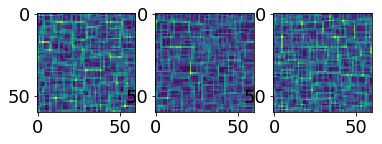

In [34]:
field = evolve3D_2_C(field, neighbors, b, num_steps=250)
show_grid(field)